# IPA27 - Guía de Estructura de Datos

Este proyecto está organizado para facilitar la actualización y el seguimiento de los indicadores del **Índice de Prosperidad Andaluz**. A continuación se detalla la función de cada carpeta:

### 📥 Datos de Entrada (Actualización Manual)
Estas carpetas contienen archivos que **requieren ser actualizados manualmente** por el usuario cuando existan nuevos datos disponibles:

*   **`data/raw/cis/`**: Microdatos y archivos ZIP del CIS (Sanidad, Participación Electoral).
*   **`data/raw/tic_hogares/`**: Archivos `.tab` y `.txt` de la Encuesta TIC-H del INE.
*   **`data/raw/transparencia/`**: Índices de transparencia gubernamental.
*   **`data/raw/other/`**: Otros archivos específicos (Delitos de odio, Inversión extranjera bruta, etc.).

### ⚙️ Procesamiento Automático
*   **`data/raw/criminalidad/quarterly/`**: Almacena los datos brutos descargados automáticamente de la web de Criminalidad.
*   **`data/processed/indicadores/`**: Contiene los archivos CSV individuales ya procesados y listos para su uso.

### 📊 Resultados y Salidas
*   **`results/data/`**: Ubicación del fichero consolidado **`ipa27_raw_YYYYMMDD.xlsx`**, que sirve de entrada para el Notebook 02 de procesamiento avanzado.
*   **`results/figures/indicators/`**: Carpeta donde se exportan automáticamente los gráficos comparativos (Andalucía vs España) de cada indicador.
*   **`results/figures/analysis/`**: (Solo en Notebook 02) Gráficos de diagnóstico, desestacionalización y dashboards finales.

---


### Celda 0: Configuración y Librerías

En esta celda se realizan las importaciones de las librerías necesarias para el procesamiento de datos (`pandas`, `numpy`, `requests`, etc.), se configura el entorno visual de `matplotlib`, se definen los colores corporativos y se establece la estructura básica de carpetas del proyecto (`data/raw`, `data/processed`, `output`, etc.), creándolas si no existen.


In [1]:
# ==============================================================================
# CELDA 0: CONFIGURACIÓN Y LIBRERÍAS
# ==============================================================================
# IPA27 - Índice de Prosperidad Andaluz
# Notebook de descarga y procesamiento de indicadores
# ==============================================================================

import requests
import pandas as pd
import numpy as np
from datetime import datetime
import os
import re
import time
import zipfile
from io import StringIO, BytesIO
import warnings

# Asegurar que trabajamos desde la raíz del proyecto para coherencia de rutas
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
    print(f"🏠 Directorio de trabajo ajustado a la raíz: {os.getcwd()}")

# Configuración visual
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

# Matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

# Colores institucionales
COLOR_AND = '#007849'  # Verde Andalucía
COLOR_ESP = '#555555'  # Gris España

# ==============================================================================
# ESTRUCTURA DE CARPETAS (Sincronizada con el Directorio del Proyecto)
# ==============================================================================
CARPETAS = [
    "data/raw/criminalidad/quarterly",
    "data/raw/cis",
    "data/raw/tic_hogares",
    "data/raw/transparencia",
    "data/raw/other",
    "data/processed/indicadores",
    "data/processed/criminalidad",
    "results/data",
    "results/figures/indicators"
]

creadas = 0
existentes = 0

for carpeta in CARPETAS:
    if not os.path.exists(carpeta):
        os.makedirs(carpeta, exist_ok=True)
        creadas += 1
    else:
        existentes += 1

print("✅ Configuración completada")
print(f"📁 Estructura de carpetas verificada: {len(CARPETAS)} (Existentes: {existentes}, Creadas: {creadas})")


c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


🏠 Directorio de trabajo ajustado a la raíz: g:\Mi unidad\Proyectos\IPA27_project
✅ Configuración completada
📁 Estructura de carpetas verificada: 9 (Existentes: 9, Creadas: 0)


### Celda 1: Utilidades Comunes

Aquí se definen constantes regionales y funciones de utilidad que se usarán en todo el notebook. Incluye lógica para:
- **Detectar región**: Identifica si los datos son de Andalucía o España.
- **Detectar frecuencia**: Determina si una serie es mensual, trimestral o anual.
- **Estandarización**: Convierte los datos procesados al formato estándar del IPA27.
- **Guardado y Gráficos**: Funciones para exportar resultados a CSV y generar visualizaciones comparativas.


In [2]:
# ==============================================================================
# CELDA 1: UTILIDADES COMUNES
# ==============================================================================
import pandas as pd
import re
import unicodedata
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import os

REGIONES_PATRONES = {
    "ESP": ["total nacional", "total espana", "españa", "national", "todas las comunidades"],
    "AND": ["andaluc"],
    "ARA": ["aragon"],
    "AST": ["asturias"],
    "BAL": ["balears", "baleares", "illes balears"],
    "CAN": ["canarias"],
    "CANT": ["cantabria"],
    "CYL": ["castilla y leon", "castilla-leon"],
    "CLM": ["castilla - la mancha", "castilla-la mancha", "la mancha"],
    "CAT": ["catalu"],
    "VAL": ["valencia", "valenciana"],
    "EXT": ["extremadura"],
    "GAL": ["galicia"],
    "MAD": ["madrid"],
    "MUR": ["murcia"],
    "NAV": ["navarra"],
    "PV": ["pais vasco", "euskadi", "vasco"],
    "RIO": ["rioja"],
}

CODIGOS_CCAA = {
    "01": "AND", "02": "ARA", "03": "AST", "04": "BAL", "05": "CAN",
    "06": "CANT", "07": "CYL", "08": "CLM", "09": "CAT", "10": "VAL",
    "11": "EXT", "12": "GAL", "13": "MAD", "14": "MUR", "15": "NAV",
    "16": "PV", "17": "RIO"
}

def normalizar_texto(texto):
    if pd.isna(texto): return ""
    s = str(texto).lower().strip()
    s = "".join(c for c in unicodedata.normalize('NFKD', s) if unicodedata.category(c) != 'Mn')
    return s

def detectar_region(texto):
    if pd.isna(texto): return None
    txt_orig = str(texto).lower().strip()
    txt_norm = normalizar_texto(txt_orig)
    
    if "ceuta y melilla" in txt_norm: return None
    
    # 1. Prioridad: Nombres completos
    for reg, patrones in REGIONES_PATRONES.items():
        for p in patrones:
            if p in txt_norm: return reg
    
    # 2. Códigos numéricos al principio (ej: "01 Andalucía")
    match = re.search(r"^(\d{1,2})[\s\.]", txt_orig)
    if match:
        code = match.group(1).zfill(2)
        if code in CODIGOS_CCAA: return CODIGOS_CCAA[code]
    
    return None

def detectar_frecuencia(fechas):
    if fechas is None or len(fechas) < 2: return "Anual"
    fechas_dt = pd.to_datetime(fechas)
    meses = set(fechas_dt.month) if hasattr(fechas_dt, 'month') else set([f.month for f in fechas_dt])
    if len(meses) >= 10: return "Mensual"
    if meses <= {1, 4, 7, 10} and len(meses) > 1: return "Trimestral"
    return "Anual"

def crear_periodo(fecha, frecuencia):
    fecha_dt = pd.to_datetime(fecha)
    if frecuencia == 'Mensual': return f"{fecha_dt.year}-M{fecha_dt.month:02d}"
    elif frecuencia == 'Trimestral':
        trimestre = (fecha_dt.month - 1) // 3 + 1
        return f"{fecha_dt.year}-Q{trimestre}"
    else: return f"{fecha_dt.year}-ANUAL"

def crear_df_estandar(registros, indicador, frecuencia=None):
    if registros is None: return None
    if isinstance(registros, pd.DataFrame) and registros.empty: return None
    if not isinstance(registros, pd.DataFrame) and not registros: return None
    df = pd.DataFrame(registros)
    df['Fecha'] = pd.to_datetime(df['fecha'])
    if frecuencia is None: frecuencia = detectar_frecuencia(df['Fecha'])
    df['Periodo'] = df['Fecha'].apply(lambda x: crear_periodo(x, frecuencia))
    df['Region'] = df['region']
    df['Indicador'] = indicador
    df['Valor'] = pd.to_numeric(df['valor'], errors='coerce')
    df['Frecuencia'] = frecuencia
    df['Serie_Original'] = df.get('serie_original', indicador)
    df = df[['Fecha', 'Periodo', 'Region', 'Indicador', 'Valor', 'Frecuencia', 'Serie_Original']]
    return df.drop_duplicates(subset=['Periodo', 'Region', 'Indicador']).sort_values(['Region', 'Fecha'])

def guardar_indicador(df, acronimo, mostrar_info=True):
    if df is None or df.empty: return None
    os.makedirs("data/processed/indicadores", exist_ok=True)
    path = f"data/processed/indicadores/{acronimo}.csv"
    df.to_csv(path, index=False)
    if mostrar_info:
        n_regs = df["Region"].nunique()
        print(f"✅ {acronimo}: {path} ({n_regs} regiones)")
    return path

def limpiar_valor(v):
    if pd.isna(v): return None
    try:
        if isinstance(v, str):
            v = v.replace(".", "").replace(",", ".").replace(" ", "")
        return float(v)
    except: return None

# ------------------------------------------------------------------------------
# 1.7 GRÁFICO COMPARATIVO
# ------------------------------------------------------------------------------
def plot_doble_eje(df, titulo, guardar=False):
    """
    Genera un gráfico con doble eje Y para comparar AND vs ESP.
    """
    if df is None or df.empty:
        print(f"⚠️ Sin datos para graficar: {titulo}")
        return
    
    # Pivotar datos
    try:
        data = df.pivot(index='Fecha', columns='Region', values='Valor')
    except:
        print(f"⚠️ Error al pivotar datos para: {titulo}")
        return
    
    if 'AND' not in data.columns or 'ESP' not in data.columns:
        print(f"⚠️ Faltan datos AND o ESP para: {titulo}")
        return
    
    # Crear figura
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # Eje izquierdo: Andalucía
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Andalucía', color=COLOR_AND, fontweight='bold')
    line1 = ax1.plot(data.index, data['AND'], color=COLOR_AND, 
                     linewidth=2.5, label='Andalucía (Izq)')
    ax1.tick_params(axis='y', labelcolor=COLOR_AND)
    ax1.grid(True, axis='x', alpha=0.3)
    
    # Eje derecho: España
    ax2 = ax1.twinx()
    ax2.set_ylabel('España', color=COLOR_ESP, fontweight='bold')
    line2 = ax2.plot(data.index, data['ESP'], color=COLOR_ESP, 
                     linestyle='--', linewidth=2, label='España (Der)')
    ax2.tick_params(axis='y', labelcolor=COLOR_ESP)
    
    # Título y leyenda
    plt.title(f"Comparativa: {titulo}", fontsize=14, pad=15)
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    plt.tight_layout()
    
    if guardar:
        import re
        nombre_archivo = re.sub(r'[\\/*?:"<>|]', "", titulo).replace(" ", "_")
        plt.savefig(f"results/figures/indicators/{nombre_archivo}.png", dpi=150, bbox_inches='tight')
    
    plt.show()

def plot_comparativa(df, titulo, guardar=False):
    """
    Genera un gráfico con un solo eje Y para comparar AND vs ESP (útil para series con misma base o escala).
    """
    if df is None or df.empty:
        print(f"⚠️ Sin datos para graficar: {titulo}")
        return
    
    # Pivotar datos
    try:
        data = df.pivot(index='Fecha', columns='Region', values='Valor')
    except:
        print(f"⚠️ Error al pivotar datos para: {titulo}")
        return
    
    if 'AND' not in data.columns or 'ESP' not in data.columns:
        print(f"⚠️ Faltan datos AND o ESP para: {titulo}")
        return
    
    # Crear figura
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['AND'], color=COLOR_AND, linewidth=2.5, label='Andalucía')
    plt.plot(data.index, data['ESP'], color=COLOR_ESP, linestyle='--', linewidth=2, label='España')
    
    plt.title(f"Comparativa: {titulo}", fontsize=14, pad=15)
    plt.xlabel('Fecha')
    plt.ylabel('Valor / Índice')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if guardar:
        import re
        nombre_archivo = re.sub(r'[\\/*?:"<>|]', "", titulo).replace(" ", "_")
        plt.savefig(f"results/figures/indicators/{nombre_archivo}.png", dpi=150, bbox_inches='tight')
    
    plt.show()


### Celda 2.1: Conector INE Tempus (API REST)

Define la clase `ConectorTempus`, un motor especializado para interactuar con la API oficial del INE. Permite descargar series temporales filtrando automáticamente por región y seleccionando la mayor frecuencia disponible para cada indicador solicitado.


In [3]:
from collections import defaultdict
# ==============================================================================
# CELDA 2.1: CONECTOR INE TEMPUS (API REST)
# ==============================================================================
# API oficial del INE para series temporales
# Documentación: https://www.ine.es/dyngs/DataLab/manual.html
# ==============================================================================

class ConectorTempus:
    """
    Conector para la API Tempus del INE.
    Descarga series temporales con filtrado automático por región.
    """
    
    def __init__(self):
        self.base_url = "https://servicios.ine.es/wstempus/js/ES"
        self.timeout = 30
    
    def _detectar_frecuencia_serie(self, datos):
        """Detecta la frecuencia de una serie desde sus datos."""
        if not datos or len(datos) < 2:
            return 1  # Anual por defecto
        
        meses_unicos = set()
        for dato in datos:
            fecha_dt = datetime.fromtimestamp(dato['Fecha'] / 1000)
            meses_unicos.add(fecha_dt.month)
        
        n_meses = len(meses_unicos)
        
        if n_meses >= 10:
            return 3  # Mensual
        elif n_meses <= 4 and meses_unicos <= {1, 4, 7, 10}:
            return 2  # Trimestral
        else:
            return 1  # Anual
    
    def _extraer_region(self, nombre_serie):
        """Extrae la región del nombre de la serie."""
        return detectar_region(nombre_serie)
    
    def descargar(self, tabla_id, acronimo, filtros_serie=None, fecha_inicio="20100101", frecuencia_forzada=None):
        """
        Descarga una tabla de INE Tempus.
        
        Parámetros:
        -----------
        tabla_id : str
            ID de la tabla en INE (ej: "50913")
        acronimo : str
            Acrónimo del indicador para el nombre del archivo
        filtros_serie : list, opcional
            Lista de strings que DEBEN estar en el nombre de la serie
            Ej: ["Índice", "General"] para IPC General
        fecha_inicio : str
            Fecha de inicio en formato YYYYMMDD
        frecuencia_forzada : str, opcional
            'Anual', 'Trimestral' o 'Mensual' para forzar la frecuencia
        
        Retorna:
        --------
        DataFrame en formato estándar o None si falla
        """
        url = f"{self.base_url}/DATOS_TABLA/{tabla_id}?date={fecha_inicio}:"
        print(f"⬇️  [{acronimo}] Descargando tabla {tabla_id} de INE Tempus...")
        
        try:
            response = requests.get(url, timeout=self.timeout)
            response.raise_for_status()
            data = response.json()
        except requests.exceptions.RequestException as e:
            print(f"   ❌ Error de conexión: {e}")
            return None
        except ValueError as e:
            print(f"   ❌ Error parseando JSON: {e}")
            return None
        
        if not data:
            print(f"   ❌ Respuesta vacía")
            return None
        
        # Agrupar series por región
        series_por_region = defaultdict(list)
        
        for serie in data:
            nombre = serie.get('Nombre', '')
            region = self._extraer_region(nombre)
            
            if not region:
                continue
            
            # Aplicar filtros si existen
            if filtros_serie:
                cumple_filtros = all(
                    f.lower() in nombre.lower() for f in filtros_serie
                )
                if not cumple_filtros:
                    continue
            
            frecuencia = self._detectar_frecuencia_serie(serie.get('Data', []))
            
            series_por_region[region].append({
                'serie': serie,
                'frecuencia': frecuencia,
                'nombre': nombre
            })
        
        # Seleccionar la serie de mayor frecuencia por región
        series_seleccionadas = []
        
        for region, series_list in series_por_region.items():
            if not series_list:
                continue
            
            # Ordenar por frecuencia (mayor primero)
            series_list.sort(key=lambda x: x['frecuencia'], reverse=True)
            mejor_serie = series_list[0]
            
            series_seleccionadas.append({
                'region': region,
                'serie': mejor_serie['serie'],
                'frecuencia': mejor_serie['frecuencia'],
                'nombre': mejor_serie['nombre']
            })
        
        if not series_seleccionadas:
            print(f"   ❌ No se encontraron series para ninguna región detectada")
            if filtros_serie:
                print(f"      Filtros aplicados: {filtros_serie}")
            return None
        
        # Convertir a registros
        registros = []
        freq_map = {1: 'Anual', 2: 'Trimestral', 3: 'Mensual'}
        
        for item in series_seleccionadas:
            region = item['region']
            serie = item['serie']
            frecuencia = freq_map[item['frecuencia']]
            
            for dato in serie.get('Data', []):
                if dato.get('Valor') is None:
                    continue
                
                fecha_dt = datetime.fromtimestamp(dato['Fecha'] / 1000)
                
                registros.append({
                    'fecha': fecha_dt,
                    'region': region,
                    'valor': dato['Valor'],
                    'serie_original': item['nombre']
                })
        
        if not registros:
            print(f"   ❌ No se extrajeron datos válidos")
            return None
        
        # Crear DataFrame estándar
        df = crear_df_estandar(registros, acronimo, frecuencia=frecuencia_forzada)
        
        # Mostrar resumen
        freq_info = ", ".join([
            f"{item['region']}: {freq_map[item['frecuencia']]}" 
            for item in series_seleccionadas
        ])
        print(f"   ✅ Descargado: {len(df)} registros | {freq_info}")
        
        return df
    
    def buscar_tablas(self, palabra_clave):
        """
        Busca tablas en INE que contengan una palabra clave.
        Útil para explorar qué tablas hay disponibles.
        """
        print(f"🔎 Buscando tablas con: '{palabra_clave}'...")
        
        url = f"{self.base_url}/OPERACIONES_DISPONIBLES"
        
        try:
            response = requests.get(url, timeout=self.timeout)
            operaciones = response.json()
        except:
            print("   ❌ Error al conectar con INE")
            return None
        
        resultados = []
        
        for op in operaciones:
            if palabra_clave.lower() in op['Nombre'].lower():
                # Buscar tablas de esta operación
                url_tablas = f"{self.base_url}/TABLAS_OPERACION/{op['Id']}"
                try:
                    tablas = requests.get(url_tablas, timeout=self.timeout).json()
                    for t in tablas:
                        resultados.append({
                            'ID': t['Id'],
                            'Nombre': t['Nombre'],
                            'Operacion': op['Nombre']
                        })
                except:
                    continue
        
        if resultados:
            df = pd.DataFrame(resultados)
            print(f"   ✅ Encontradas {len(df)} tablas")
            return df
        else:
            print("   ❌ No se encontraron resultados")
            return None


# Instanciar conector
tempus = ConectorTempus()

print("✅ Conector INE Tempus cargado")
print("   └─ Uso: df = tempus.descargar('50913', 'IPC_GEN', filtros_serie=['Índice', 'General'])")


✅ Conector INE Tempus cargado
   └─ Uso: df = tempus.descargar('50913', 'IPC_GEN', filtros_serie=['Índice', 'General'])


### Celda 2.2: Conector INE JAXI (CSV)

Implementa la clase `ConectorJAXI`, diseñada para descargar y procesar tablas estáticas del INE en formato CSV. Este conector es capaz de manejar diferentes estructuras de tablas (formato ancho o largo) y unifica varios métodos de descarga en una interfaz simplificada.


In [4]:
class ConectorJAXI:
    ENDPOINTS = {
        'jaxiT3': "https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/{}.csv",
        'jaxi_tpx': "https://www.ine.es/jaxi/files/tpx/es/csv_bdsc/{}.csv",
    }
    
    def _descargar_csv(self, tabla_id, endpoint='jaxiT3'):
        url = self.ENDPOINTS[endpoint].format(tabla_id)
        try:
            r = requests.get(url, timeout=30, verify=False, headers={"User-Agent":"Mozilla/5.0"})
            if r.status_code != 200: return None, f"HTTP {r.status_code}"
            for enc in ['utf-8-sig', 'iso-8859-15', 'latin1']:
                try:
                    r.encoding = enc
                    df = pd.read_csv(io.StringIO(r.text), sep=";", thousands=".", decimal=",")
                    if not df.empty: return df, None
                except: continue
            return None, "Error encoding"
        except Exception as e: return None, str(e)

    def _extraer_anio(self, row):
        """Busca un año (4 dígitos) en las columnas de la fila (excepto la última que es valor)."""
        import re
        for val in row.iloc[:-1]:
            match = re.search(r"(\d{4})", str(val))
            if match: return int(match.group(1))
        return None

    def descargar_doble(self, tabla_esp, tabla_reg, acronimo, filtros=None, region_reg=None, endpoint='jaxiT3'):
        registros = []
        tablas = [(tabla_esp, 'ESP'), (tabla_reg, region_reg)]
        for t_id, t_reg in tablas:
            if not t_id: continue
            df, _ = self._descargar_csv(t_id, endpoint)
            if df is not None:
                for _, row in df.iterrows():
                    if filtros:
                        if not all(str(v).lower() in str(row.iloc[k]).lower() for k, v in filtros.items()): continue
                    
                    reg = t_reg or detectar_region(row.iloc[0])
                    if not reg: continue
                    
                    anio = self._extraer_anio(row)
                    val = limpiar_valor(row.iloc[-1])
                    if anio and val is not None:
                        registros.append({'fecha': pd.to_datetime(f"{anio}-01-01"), 'region': reg, 'valor': val})
        return crear_df_estandar(registros, acronimo)

    def descargar_multi(self, tablas_ids, acronimo, endpoint='jaxi_tpx'):
        registros = []
        for t_id in tablas_ids:
            df, _ = self._descargar_csv(t_id, endpoint)
            if df is not None:
                for _, row in df.iterrows():
                    reg = detectar_region(row.iloc[0])
                    if not reg: continue
                    anio = self._extraer_anio(row)
                    val = limpiar_valor(row.iloc[-1])
                    if anio and val is not None:
                        registros.append({'fecha': pd.to_datetime(f"{anio}-01-01"), 'region': reg, 'valor': val})
        return crear_df_estandar(registros, acronimo)

    def descargar_por_anio(self, tablas_anios, acronimo, filtros=None, endpoint='jaxi_tpx'):
        registros = []
        for anio_table, t_id in tablas_anios.items():
            df, _ = self._descargar_csv(t_id, endpoint)
            if df is not None:
                for _, row in df.iterrows():
                    if filtros:
                        if not all(str(v).lower() in str(row.iloc[k]).lower() for k, v in filtros.items()): continue
                    reg = detectar_region(row.iloc[0])
                    if not reg: continue
                    val = limpiar_valor(row.iloc[-1])
                    if val is not None:
                        registros.append({'fecha': pd.to_datetime(f"{anio_table}-01-01"), 'region': reg, 'valor': val})
        return crear_df_estandar(registros, acronimo)

    def descargar(self, tabla_id, acronimo, filtros=None, endpoint='jaxiT3'):
        return self.descargar_doble(None, tabla_id, acronimo, filtros=filtros, endpoint=endpoint)

jaxi = ConectorJAXI()


### Celda 2.3: Conector IECA (API REST)

Contiene la clase `ConectorIECA`, enfocada principalmente en la obtención del PIB trimestral de Andalucía desde la API del Instituto de Estadística y Cartografía de Andalucía, combinándolo con datos nacionales del INE para su comparación.


In [5]:
# ==============================================================================
# CELDA 2.3: CONECTOR IECA (API REST) + PIB Regional INE
# ==============================================================================
class ConectorIECA:
    def __init__(self):
        self.base_url = "https://www.juntadeandalucia.es/institutodeestadisticaycartografia/intranet/admin/rest/v1.0"
        self.timeout = 30
    
    def descargar_pib_trimestral(self, acronimo="ECO_PIT"):
        import urllib3, io
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
        print(f"⬇️  [{acronimo}] Descargando PIB Trimestral (AND/ESP) y Anual (CCAA)...")
        
        registros_q = []
        
        # 1. Andalucía Trimestral (IECA)
        try:
            meta = requests.get(f"{self.base_url}/consulta/106166", timeout=self.timeout, verify=False).json()
            temp_hier = next(h for h in meta['hierarchies'] if h['alias'] == 'D_TEMPORAL_0')
            jer_data = requests.get(temp_hier['url'], timeout=self.timeout, verify=False).json()
            ids = []
            def extract_ids(item):
                if item.get('levelId') == 3:
                    cod = str(item.get('cod', ''))
                    if len(cod) == 5: ids.append(str(item['id']))
                children = item.get('children', [])
                if children: 
                    for child in children: extract_ids(child)
            extract_ids(jer_data.get('data', {}))
            ids_str = ",".join(ids)
            res = requests.get(f"{self.base_url}/consulta/106166?D_CRTA_COMPONPIB2008_0=69618&D_TEMPORAL_0={ids_str}", timeout=self.timeout, verify=False).json()
            for item in res.get('data', []):
                p_raw = str(item[1]['cod'][0])
                if len(p_raw) != 5: continue
                anio, q = int(p_raw[:4]), int(p_raw[4])
                val = item[4].get('val')
                if val is not None: registros_q.append({'fecha': pd.to_datetime(f"{anio}-{(q-1)*3+1:02d}-01"), 'region': 'AND', 'valor': float(val), 'serie_original': 'IECA_PIB_IV'})
            print(f"   ✅ Andalucía Q: {len([r for r in registros_q if r['region']=='AND'])} registros")
        except Exception as e: print(f"   ❌ Error IECA: {e}")
        
        # 2. España Trimestral (INE)
        try:
            res_esp = requests.get("https://servicios.ine.es/wstempus/js/ES/DATOS_SERIE/CNTR6652?nult=500", timeout=self.timeout, verify=False).json()
            p_to_q = {19: 1, 20: 2, 21: 3, 22: 4}
            for item in res_esp.get('Data', []):
                q = p_to_q.get(item.get('FK_Periodo'))
                if q: registros_q.append({'fecha': pd.to_datetime(f"{item['Anyo']}-{(q-1)*3+1:02d}-01"), 'region': 'ESP', 'valor': item['Valor'], 'serie_original': 'INE_PIB_IV'})
            print(f"   ✅ España Q: {len([r for r in registros_q if r['region']=='ESP'])} registros")
        except Exception as e: print(f"   ❌ Error INE Q: {e}")
        
        # Solo devolver series trimestrales (ESP + AND)
        # (Los datos anuales de CCAA ahora provienen de ECO_RBH)
        df_q = crear_df_estandar(registros_q, acronimo, frecuencia='Trimestral')
        return df_q

ieca = ConectorIECA()
print("✅ Conector IECA (Scalable) cargado")


✅ Conector IECA (Scalable) cargado


### Celda 2.4: Conector Criminalidad (Ministerio del Interior)

Define el `ConectorCriminalidad`, una herramienta crítica para procesar los balances trimestrales de criminalidad. Dado que los datos oficiales son acumulados por año, esta clase implementa la lógica necesaria para "desacumularlos" y obtener los valores puros de cada trimestre.


In [6]:
# ==============================================================================
# CELDA 2.4: CONECTOR CRIMINALIDAD (MINISTERIO DEL INTERIOR)
# ==============================================================================
# Portal Estadístico de Criminalidad
# Datos trimestrales ACUMULADOS que hay que desacumular
# ==============================================================================

from io import BytesIO

# ==============================================================================
# MAPEO PARA NORMALIZAR NOMBRES DE CATEGORÍAS
# ==============================================================================

NORMALIZAR_CATEGORIAS = {
    # Libertad sexual
    "5.-Delitos contra la libertad e indemnidad sexual": "LIBERTAD_SEXUAL",
    "5. Delitos contra la libertad sexual": "LIBERTAD_SEXUAL",
    "5.2.-Resto de delitos contra la libertad e indemnidad sexual": "LIBERTAD_SEXUAL_RESTO",
    "5.2.-Resto de delitos contra la libertad e indemni": "LIBERTAD_SEXUAL_RESTO",
    "5.2.-Resto de delitos contra la libertad sexual": "LIBERTAD_SEXUAL_RESTO",
    
    # Hurtos
    "8.-Hurtos": "HURTOS",
    "8. Hurtos": "HURTOS",
    
    # Robos con fuerza
    "7.- Robos con fuerza en domicilios, establecimientos y otras instalaciones": "ROBOS_FUERZA",
    "7. Robos con fuerza en domicilios, establecimientos y otras instalaciones": "ROBOS_FUERZA",
    "7. Robos con fuerza en domicilios, establecimientos y otras ": "ROBOS_FUERZA",
    
    # Robos con violencia
    "6.-Robos con violencia e intimidación": "ROBOS_VIOLENCIA",
    "6.-Robos con violencia e intimidaciÃ³n": "ROBOS_VIOLENCIA",
    "6. Robos con violencia e intimidación": "ROBOS_VIOLENCIA",
    "6. Robos con violencia e intimidaciÃ³n": "ROBOS_VIOLENCIA",
    
    # Homicidios
    "1.-Homicidios dolosos y asesinatos consumados": "HOMICIDIOS",
    "1. Homicidios dolosos y asesinatos consumados": "HOMICIDIOS",
    
    # Lesiones
    "3.-Delitos graves y menos graves de lesiones y riña tumultuaria": "LESIONES",
    "3.-Delitos graves y menos graves de lesiones y riÃ±a tumultu": "LESIONES",
    "3. Delitos graves y menos graves de lesiones y riña tumultuaria": "LESIONES",
    "3. Delitos graves y menos graves de lesiones y riÃ±a tumultu": "LESIONES",
    
    # Tráfico drogas
    "10.-Tráfico de drogas": "TRAFICO_DROGAS",
    "10.-TrÃ¡fico de drogas": "TRAFICO_DROGAS",
    "10. Tráfico de drogas": "TRAFICO_DROGAS",
    "10. TrÃ¡fico de drogas": "TRAFICO_DROGAS",
    
    # Sustracciones vehículos
    "9.-Sustracciones de vehículos": "SUSTRACCION_VEHICULOS",
    "9.-Sustracciones de vehÃ­culos": "SUSTRACCION_VEHICULOS",
    "9. Sustracciones de vehículos": "SUSTRACCION_VEHICULOS",
    "9. Sustracciones de vehÃ­culos": "SUSTRACCION_VEHICULOS",
    
    # Totales (para SEG_CRI usamos el total principal, no el de cibercriminalidad)
    "TOTAL INFRACCIONES PENALES": "TOTAL",
    "III. TOTAL INFRACCIONES PENALES": "TOTAL",
}

class ConectorCriminalidad:
    """
    Conector para el Portal Estadístico de Criminalidad del Ministerio del Interior.
    Los datos vienen ACUMULADOS dentro de cada año y hay que desacumularlos.
    """
    
    def __init__(self):
        self.base_url = "https://estadisticasdecriminalidad.ses.mir.es/sec/jaxiPx/files/_px/es/csv_bdsc"
        self.timeout = 15
        self.raw_dir = "data/raw/criminalidad/quarterly"
        os.makedirs(self.raw_dir, exist_ok=True)
    
    def _generar_url(self, year, quarter):
        """Genera la URL para un año y trimestre específico."""
        q_map = {1: '001', 2: '004', 3: '007', 4: '010'}
        suffix = q_map.get(quarter)
        ext = "csv_bdsc?nocab=1"
        
        if year == 2025:
            return f"{self.base_url}/DatosBalanceAct/l0/09{suffix}.{ext}"
        elif 2020 <= year <= 2024:
            year_code = year - 2010
            return f"{self.base_url}/DatosBalanceAnt/l0/{year_code}09{suffix}.{ext}"
        elif year < 2020:
            year_code = year - 2010
            return f"{self.base_url}/DatosBalanceAnt/l0/{year_code}9{suffix}.{ext}"
        
        return None
    
    def _parsear_csv(self, content, target_year):
        """Parsea el CSV y extrae datos para ESP y AND."""
        datos = []
        
        try:
            df = pd.read_csv(
                BytesIO(content), 
                sep=';', 
                encoding='utf-8-sig', 
                on_bad_lines='skip'
            )
            
            # Normalizar columnas
            df.columns = [str(c).strip().lower() for c in df.columns]
            
            # Identificar columnas clave
            col_region = next((c for c in df.columns if 'comunid' in c), None)
            col_tipo = next((c for c in df.columns if 'tipolog' in c), None)
            col_periodo = next((c for c in df.columns if 'periodo' in c), None)
            col_total = next((c for c in df.columns if 'total' in c), None)
            
            if not all([col_region, col_tipo, col_periodo, col_total]):
                return None
            
            for idx, row in df.iterrows():
                try:
                    region_raw = str(row[col_region]).strip().upper()
                    periodo_raw = str(row[col_periodo]).strip()
                    tipo_raw = str(row[col_tipo]).strip()
                    
                    # Filtro de región
                    region_code = detectar_region(region_raw)
                    # ... dentro del bucle de filas del CSV ...
                    

                    # AÑADE ESTO:

                    if not region_code:
                        continue

                    if not region_code:
                        continue
                    
                    # Filtro de periodo
                    if str(target_year) not in periodo_raw:
                        continue
                    if "variación" in periodo_raw.lower() or "%" in periodo_raw:
                        continue
                    
                    # Extraer valor (formato español: 1.542.066)
                    val_raw = str(row[col_total])
                    val_clean = val_raw.replace('.', '').replace(',', '.')
                    val = float(val_clean)
                    
                    datos.append({
                        'Region': region_code,
                        'Categoria': tipo_raw,
                        'Valor': val  # VALOR ACUMULADO
                    })
                    
                except:
                    continue
            
            return datos
            
        except Exception as e:
            return None
    
    def _desacumular(self, df):
        """
        Calcula el valor trimestral puro restando el acumulado del trimestre anterior.
        Q1 = Q1_acum
        Q2 = Q2_acum - Q1_acum
        Q3 = Q3_acum - Q2_acum
        Q4 = Q4_acum - Q3_acum
        """
        # Ordenar para calcular en orden correcto
        df = df.sort_values(by=['Region', 'Categoria', 'Anio', 'Trimestre'])
        
        # Agrupar por Region + Categoria + Año y calcular diferencias
        grouped = df.groupby(['Region', 'Categoria', 'Anio'])
        
        resultados = []
        for name, group in grouped:
            group = group.copy()
            # La diferencia con el anterior; el primero (Q1) mantiene su valor
            group['Valor_Trimestral'] = group['Valor'].diff().fillna(group['Valor'])
            resultados.append(group)
        
        return pd.concat(resultados) if resultados else df
    
    def descargar(self, acronimo="SEG_BAL", anio_inicio=2016, anio_fin=2025, 
              categorias_filtro=None):
        """
        Descarga datos de criminalidad para un rango de años.
        Normaliza nombres de categorías antes de desacumular.
        """
        print(f"⬇️  [{acronimo}] Descargando criminalidad {anio_inicio}-{anio_fin}...")
        
        # Generar lista de periodos
        periodos = []
        for y in range(anio_inicio, anio_fin + 1):
            trimestres = [1, 2, 3, 4] if y < 2025 else [1, 2, 3]
            for q in trimestres:
                periodos.append((y, q))
        
        all_results = []
        
        for year, quarter in periodos:
            url = self._generar_url(year, quarter)
            if not url:
                continue
            
            try:
                response = requests.get(url, timeout=self.timeout)
                if response.status_code != 200:
                    continue
                
                datos = self._parsear_csv(response.content, year)
                if datos:
                    for d in datos:
                        d['Periodo'] = f"{year}-Q{quarter}"
                        d['Anio'] = year
                        d['Trimestre'] = quarter
                    all_results.extend(datos)
            except:
                continue
            
            time.sleep(0.2)
        
        if not all_results:
            print(f"   ❌ No se obtuvieron datos")
            return None
        
        print(f"   📥 Descargados {len(all_results)} registros acumulados")
        
        df = pd.DataFrame(all_results)
        
        # ============================================
        # PASO CRÍTICO: Normalizar nombres de categorías
        # ============================================
        df['Categoria_Norm'] = df['Categoria'].map(NORMALIZAR_CATEGORIAS)
        
        # Si no está en el mapeo, intentar match parcial
        for idx, row in df[df['Categoria_Norm'].isna()].iterrows():
            cat_orig = row['Categoria']
            for patron, norm in NORMALIZAR_CATEGORIAS.items():
                if patron.lower() in cat_orig.lower() or cat_orig.lower() in patron.lower():
                    df.loc[idx, 'Categoria_Norm'] = norm
                    break
        
        # Filtrar categorías si se especifica
        if categorias_filtro:
            # categorias_filtro ahora debería usar los nombres NORMALIZADOS
            df = df[df['Categoria_Norm'].isin(categorias_filtro)]
            print(f"   🔍 Filtrado a categorías: {categorias_filtro}")
        
        # Verificar que tenemos categorías normalizadas
        n_sin_norm = df['Categoria_Norm'].isna().sum()
        if n_sin_norm > 0:
            print(f"   ⚠️ {n_sin_norm} registros sin normalizar")
            # Mostrar cuáles son
            cats_sin_norm = df[df['Categoria_Norm'].isna()]['Categoria'].unique()
            for c in cats_sin_norm[:5]:
                print(f"      • {c[:60]}")
        
        # Quedarnos solo con los normalizados
        df = df[df['Categoria_Norm'].notna()]
        
        # Agrupar por categoría normalizada (por si hay duplicados)
        df = df.groupby(
            ['Periodo', 'Anio', 'Trimestre', 'Region', 'Categoria_Norm'],
            as_index=False
        )['Valor'].sum()
        
        # ============================================
        # DESACUMULAR (ahora con nombres consistentes)
        # ============================================
        df = df.sort_values(['Region', 'Categoria_Norm', 'Anio', 'Trimestre'])
        
        resultados = []
        for (region, cat), group in df.groupby(['Region', 'Categoria_Norm']):
            group = group.copy()
            # Dentro de cada año, calcular diferencia
            group['Valor_Anterior'] = group.groupby('Anio')['Valor'].shift(1)
            group['Valor_Trimestral'] = group['Valor'] - group['Valor_Anterior'].fillna(0)
            # Q1 de cada año = valor acumulado
            mask_q1 = group['Trimestre'] == 1
            group.loc[mask_q1, 'Valor_Trimestral'] = group.loc[mask_q1, 'Valor']
            resultados.append(group)
        
        df = pd.concat(resultados)
        
        # Sumar todas las categorías para el total por trimestre
        df_total = df.groupby(['Periodo', 'Anio', 'Trimestre', 'Region'], as_index=False).agg({
            'Valor_Trimestral': 'sum'
        })
        
        # Crear registros estándar
        registros = []
        for idx, row in df_total.iterrows():
            mes_inicio = (row['Trimestre'] - 1) * 3 + 1
            fecha = pd.to_datetime(f"{row['Anio']}-{mes_inicio:02d}-01")
            
            registros.append({
                'fecha': fecha,
                'region': row['Region'],
                'valor': row['Valor_Trimestral'],
                'serie_original': 'MIR_Criminalidad_Trimestral'
            })
        
        df_final = crear_df_estandar(registros, acronimo, frecuencia='Trimestral')
        
        reg_counts = df_final['Region'].value_counts().to_dict()
        resumen = ", ".join([f'{k}={v}' for k, v in reg_counts.items()])
        print(f"   ✅ Desacumulado: {len(df_final)} registros ({resumen})")
        
        # Guardar detalle por categoría
        if len(df['Categoria_Norm'].unique()) > 1:
            path_detalle = f"data/processed/indicadores/{acronimo}_detalle.csv"
            df.to_csv(path_detalle, index=False)
            print(f"   📁 Detalle: {path_detalle}")
        
        return df_final


# Instanciar conector
criminalidad = ConectorCriminalidad()

print("✅ Conector Criminalidad cargado")
print("   └─ Métodos: descargar()")


✅ Conector Criminalidad cargado
   └─ Métodos: descargar()


### Celda 3: Diccionario Maestro de Indicadores

Este es el nucleo de configuración del proyecto. El diccionario `INDICADORES` define todos los parámetros (IDs de tablas, filtros, fuentes) para los 26 indicadores del IPA27, organizados por dominios (Sociedades Inclusivas, Economías Abiertas, Personas Empoderadas) y pilares.


In [7]:
# ==============================================================================
# CELDA 3: DICCIONARIO MAESTRO DE INDICADORES
# ==============================================================================
# Configuración centralizada de todos los indicadores del IPA27
# El motor de descarga (Celda 4) usa este diccionario
# ==============================================================================

INDICADORES = {
    
    # ==========================================================================
    # DOMINIO 1: SOCIEDADES INCLUSIVAS
    # ==========================================================================
    
    # --------------------------------------------------------------------------
    # PILAR 1: SEGURIDAD Y PROTECCIÓN
    # --------------------------------------------------------------------------
    "SEG_CRI": {
        "nombre": "Tasa de Criminalidad",
        "pilar": "1. Seguridad y Protección",
        "dominio": "Sociedades Inclusivas",
        "frecuencia": "T",
        "tipo": "criminalidad",
        "parametros": {
            "anio_inicio": 2016,
            "anio_fin": 2025,
            "categorias_filtro": ["TOTAL"]  # Solo el total
        }
    },

    "SEG_BAL": {
        "nombre": "Balance Criminalidad (Hurtos + Robos)",
        "pilar": "1. Seguridad y Protección", 
        "dominio": "Sociedades Inclusivas",
        "frecuencia": "T",
        "tipo": "criminalidad",
        "parametros": {
            "anio_inicio": 2016,
            "anio_fin": 2025,
            "categorias_filtro": ["HURTOS", "ROBOS_FUERZA"]
        }
    },
   
    
    # --------------------------------------------------------------------------
    # PILAR 2: LIBERTAD PERSONAL
    # --------------------------------------------------------------------------
    "LIB_ODI": {
        "nombre": "Delitos de Odio",
        "pilar": "2. Libertad Personal",
        "dominio": "Sociedades Inclusivas",
        "frecuencia": "A",
        "tipo": "manual",
        "parametros": {
            "archivo": "mir_odio.xls",
            "instrucciones": "Descargar de https://oficinanacional-delitosdeodio.ses.mir.es/publico/ONDOD/publicaciones.html"
        }
    },
    
    
    "LIB_SEX": {
        "nombre": "Delitos Libertad Sexual",
        "pilar": "2. Libertad Personal",
        "dominio": "Sociedades Inclusivas",
        "frecuencia": "T",
        "tipo": "criminalidad",
        "parametros": {
            "anio_inicio": 2016,
            "anio_fin": 2025,
            "categorias_filtro": ["LIBERTAD_SEXUAL"]  # Solo la principal, no el "resto"
        }
    },

    
    # --------------------------------------------------------------------------
    # PILAR 3: GOBERNANZA
    # --------------------------------------------------------------------------
    
    "GOB_COR": {
        "nombre": "Procesos por Corrupción",
        "pilar": "3. Gobernanza",
        "dominio": "Sociedades Inclusivas",
        "frecuencia": "A",
        "tipo": "manual",
        "parametros": {
            "archivo": "mir_corrupcion.xls",
            "instrucciones": "Descargar de https://www.poderjudicial.es/cgpj/es/Temas/Estadistica-Judicial/Estadistica-Judicial-Anual/Estadistica-Judicial-Anual/Estadistica-de-la-Corrupcion/"
        }
    },
    
    "GOB_EFF": {
        "nombre": "Eficiencia Judicial Corrupción",
        "pilar": "3. Gobernanza",
        "dominio": "Sociedades Inclusivas",
        "frecuencia": "A",
        "tipo": "manual",
        "parametros": {
            "archivo": "mir_corrupcion.xls",
            "instrucciones": "Descargar de https://www.poderjudicial.es/cgpj/es/Temas/Estadistica-Judicial/Estadistica-Judicial-Anual/Estadistica-Judicial-Anual/Estadistica-de-la-Corrupcion/"
        }
    },

    "GOB_DES": {
        "nombre": "Índice de Desafección (CIS)",
        "pilar": "3. Gobernanza",
        "dominio": "Sociedades Inclusivas",
        "frecuencia": "M",
        "tipo": "manual_cis",
        "parametros": {
            "archivo": "data/processed/cis/barómetro/indice_desafeccion_ccaa_pivot.csv",
            "archivo_nacional": "data/processed/cis/barómetro/indice_desafeccion_nacional.csv",
            "instrucciones": "Generado por 01_1_Índice de desafección_cis_v2.ipynb"
        }
    },
    
    # --------------------------------------------------------------------------
    # PILAR 4: CAPITAL SOCIAL
    # --------------------------------------------------------------------------
    "SOC_ASO": {
        "nombre": "Afiliados Actividades Asociativas",
        "pilar": "4. Capital Social",
        "dominio": "Sociedades Inclusivas",
        "frecuencia": "M",
        "tipo": "manual_ss",
        "parametros": {
            "archivo": "ss_afiliados.csv",
            "instrucciones": "Descargar de Seguridad Social - Afiliados por CNAE"
        }
    },
    
    # ==========================================================================
    # DOMINIO 2: ECONOMÍAS ABIERTAS
    # ==========================================================================
    
    # --------------------------------------------------------------------------
    # PILAR 5: ENTORNO DE INVERSIÓN
    # --------------------------------------------------------------------------
    "INV_IED": {
        "nombre": "Inversión Extranjera Directa",
        "pilar": "5. Entorno de Inversión",
        "dominio": "Economías Abiertas",
        "frecuencia": "T",
        "tipo": "manual_datainvex",
        "parametros": {
            "archivo": "consulta_datainvex.xls",
            "instrucciones": "Descargar de https://datainvex.comercio.es/principal_invex.aspx"
        }
    },
    
    "INV_HIP": {
        "nombre": "Hipotecas Fincas Urbanas",
        "pilar": "5. Entorno de Inversión",
        "dominio": "Economías Abiertas",
        "frecuencia": "M",
        "tipo": "tempus",
        "parametros": {
            "tabla_id": "13896",
            "filtros_serie": None
        }
    },
    
    # --------------------------------------------------------------------------
    # PILAR 6: CONDICIONES EMPRESARIALES
    # --------------------------------------------------------------------------
    "EMP_NAT": {
        "nombre": "Natalidad Empresarial",
        "pilar": "6. Condiciones Empresariales",
        "dominio": "Economías Abiertas",
        "frecuencia": "A",
        "tipo": "jaxi_por_anio",
        "parametros": {
            "tablas_anios": {
                2023: "76646",
                2022: "71097",
                2021: "60303",
                2020: "54687",
                2019: "50025",
                2018: "39378",
                2017: "32929",
                2016: "29259"
            },
            "filtros": {
                1: "Todas las actividades",  # Columna índice 1
                2: "Total"                    # Columna índice 2
            },
            "endpoint": "jaxi_tpx"
        }
    },
    
    "EMP_SOC": {
        "nombre": "Constitución Sociedades Mercantiles",
        "pilar": "6. Condiciones Empresariales",
        "dominio": "Economías Abiertas",
        "frecuencia": "M",
        "tipo": "tempus",
        "parametros": {
            "tabla_id": "13912",
            "filtros_serie": None
        }
    },
    
    # --------------------------------------------------------------------------
    # PILAR 7: INFRAESTRUCTURA Y ACCESO
    # --------------------------------------------------------------------------
    "INF_BAN": {
        "nombre": "Hogares con Banda Ancha",
        "pilar": "7. Infraestructura y Acceso",
        "dominio": "Economías Abiertas",
        "frecuencia": "A",
        "tipo": "manual_tic",
        "parametros": {
            "tabla_id": "76594",
            "filtros_serie": ["Viviendas con conexión de Banda Ancha"]
        }
    },
    
    "INF_TRA": {
        "nombre": "Transporte Viajeros Urbano",
        "pilar": "7. Infraestructura y Acceso",
        "dominio": "Economías Abiertas",
        "frecuencia": "M",
        "tipo": "tempus",
        "parametros": {
            "tabla_id": "20240",
            "filtros_serie": ["Viajeros", "urbano"]
        }
    },
    
    # --------------------------------------------------------------------------
    # PILAR 8: CALIDAD ECONÓMICA
    # --------------------------------------------------------------------------
    
    "ECO_RBH": {
        "nombre": "Renta Disponible Bruta de los Hogares",
        "pilar": "8. Calidad Económica",
        "dominio": "Economías Abiertas",
        "frecuencia": "A",
        "tipo": "excel_local",
        "parametros": {
            "fichero": "data/raw/renta_ine/rentahogd25.xlsx",
            "hoja": "Tabla_1",
            "fila_anios": 3,
            "fila_subcabeceras": 4,
            "fila_datos_inicio": 5
        }
    },
    
    "ECO_PIT": {
        "nombre": "PIB Trimestral (Auxiliar Trimestralización)",
        "pilar": "Auxiliar",
        "dominio": "Auxiliar",
        "frecuencia": "T",
        "tipo": "ieca",
        "parametros": {}
    },
    
    "ECO_COL_sal": {
        "nombre": "Coste Salarial Ordinario (Euros)",
        "pilar": "8. Calidad Económica",
        "dominio": "Economías Abiertas",
        "frecuencia": "T",
        "tipo": "tempus",
        "parametros": {
            "tabla_id": "6061",
            "filtros_serie": ["Coste salarial ordinario", "Industria, construcción y servicios"]
        }
    },

    
    # ==========================================================================
    # DOMINIO 3: PERSONAS EMPODERADAS
    # ==========================================================================
    
    # --------------------------------------------------------------------------
    # PILAR 9: CONDICIONES DE VIDA
    # --------------------------------------------------------------------------
    "VID_ARO": {
        "nombre": "Tasa AROPE (Riesgo Pobreza)",
        "pilar": "9. Condiciones de Vida",
        "dominio": "Personas Empoderadas",
        "frecuencia": "A",
        "tipo": "tempus",
        "parametros": {
            "tabla_id": "9963",
            "filtros_serie": None
        }
    },
    
    "VID_PAR": {
        "nombre": "Tasa de Paro EPA",
        "pilar": "9. Condiciones de Vida",
        "dominio": "Personas Empoderadas",
        "frecuencia": "T",
        "tipo": "tempus",
        "parametros": {
            "tabla_id": "65334",
            "filtros_serie": None
        }
    },
    
    # --------------------------------------------------------------------------
    # PILAR 10: SALUD
    # --------------------------------------------------------------------------
    "SAL_ESP": {
        "nombre": "Esperanza de Vida al Nacer",
        "pilar": "10. Salud",
        "dominio": "Personas Empoderadas",
        "frecuencia": "A",
        "tipo": "jaxi_doble",
        "parametros": {
            "tabla_esp": "1414",
            "tabla_reg": "1448",
            "region_reg": None,
            "filtros": {
                "Sexo": "Ambos sexos"
            }
        }
    },
    
    "SAL_SAT": {
        "nombre": "Satisfacción Sistema Sanitario",
        "pilar": "9. Condiciones de Vida",
        "dominio": "Personas Empoderadas",
        "frecuencia": "A",
        "tipo": "tempus",
        "parametros": {
            "tabla_id": "65334",
            "filtros_serie": ["Satisfacción con el funcionamiento del sistema sanitario público"]
        }
    },
    
    # --------------------------------------------------------------------------
    # PILAR 11: EDUCACIÓN
    # --------------------------------------------------------------------------
    "EDU_ABA": {
        "nombre": "Abandono Escolar Temprano",
        "pilar": "11. Educación",
        "dominio": "Personas Empoderadas",
        "frecuencia": "A",
        "tipo": "jaxi",
        "parametros": {
            "tabla_id": "69786",
            "filtro_serie": None
        }
    },
    
   "EDU_SUP": {
        "nombre": "Población con Educación Superior",
        "pilar": "11. Educación",
        "dominio": "Personas Empoderadas",
        "frecuencia": "T",
        "tipo": "tempus",
        "parametros": {
            "tabla_id": "65288",
            "filtros_serie": ["Educación superior"] 
        }
    },
    
    # --------------------------------------------------------------------------
    # PILAR 12: CONOCIMIENTO Y HABILIDADES
    # --------------------------------------------------------------------------
    "CON_IDI": {
        "nombre": "Gasto I+D (% PIB)",
        "pilar": "12. Conocimiento y Habilidades",
        "dominio": "Personas Empoderadas",
        "frecuencia": "A",
        "tipo": "jaxi_multi",
        "parametros": {
            "tablas_ids": ["76751", "76795"],
            "endpoint": "jaxi_tpx"
        }
    },
    
    "CON_OCI": {
        "nombre": "Afiliados Conocimiento Intensivo",
        "pilar": "12. Conocimiento y Habilidades",
        "dominio": "Personas Empoderadas",
        "frecuencia": "M",
        "tipo": "manual_ss",
        "parametros": {
            "archivo": "ss_afiliados.csv",
            "instrucciones": "Secciones J+M del CNAE"
        }
    },
    
    # ==========================================================================
    # AUXILIARES
    # ==========================================================================
    "AUX_IPC": {
        "nombre": "IPC General",
        "pilar": "Auxiliar",
        "dominio": "Auxiliar",
        "frecuencia": "M",
        "tipo": "tempus",
        "parametros": {
            "tabla_id": "50913",
            "filtros_serie": ["Índice", "General"]
        }
    },
    
    "AUX_POB": {
        "nombre": "Población CCAA",
        "pilar": "Auxiliar",
        "dominio": "Auxiliar",
        "frecuencia": "T",
        "tipo": "custom_pob",
        "parametros": {
            "tabla_base": "56940",
            "tabla_reciente": "59238"
        }
    },
}

# ==============================================================================
# RESUMEN DEL DICCIONARIO
# ==============================================================================
def mostrar_resumen_indicadores():
    """Muestra un resumen del diccionario de indicadores."""
    
    print("=" * 80)
    print("📊 RESUMEN DE INDICADORES IPA27")
    print("=" * 80)
    
    # Contar por tipo
    por_tipo = {}
    por_frecuencia = {}
    por_dominio = {}
    
    for acr, config in INDICADORES.items():
        tipo = config['tipo']
        freq = config['frecuencia']
        dom = config['dominio']
        
        por_tipo[tipo] = por_tipo.get(tipo, 0) + 1
        por_frecuencia[freq] = por_frecuencia.get(freq, 0) + 1
        por_dominio[dom] = por_dominio.get(dom, 0) + 1
    
    print(f"\n📈 Total indicadores: {len(INDICADORES)}")
    
    print(f"\n📁 Por dominio:")
    for dom, count in por_dominio.items():
        print(f"   • {dom}: {count}")
    
    print(f"\n⏱️  Por frecuencia:")
    freq_nombres = {'M': 'Mensual', 'T': 'Trimestral', 'A': 'Anual'}
    for freq, count in por_frecuencia.items():
        print(f"   • {freq_nombres.get(freq, freq)}: {count}")
    
    print(f"\n🔧 Por tipo de conector:")
    for tipo, count in sorted(por_tipo.items()):
        estado = "✅" if tipo not in ['pendiente', 'derivado'] else "⏳"
        print(f"   {estado} {tipo}: {count}")
    
    # Listar pendientes
    pendientes = [acr for acr, cfg in INDICADORES.items() if cfg['tipo'] == 'pendiente']
    if pendientes:
        print(f"\n⚠️  Pendientes de implementar: {', '.join(pendientes)}")
    
    manuales = [acr for acr, cfg in INDICADORES.items() if 'manual' in cfg['tipo']]
    if manuales:
        print(f"📥 Requieren descarga manual: {', '.join(manuales)}")

mostrar_resumen_indicadores()


📊 RESUMEN DE INDICADORES IPA27

📈 Total indicadores: 27

📁 Por dominio:
   • Sociedades Inclusivas: 8
   • Economías Abiertas: 8
   • Auxiliar: 3
   • Personas Empoderadas: 8

⏱️  Por frecuencia:
   • Trimestral: 9
   • Anual: 11
   • Mensual: 7

🔧 Por tipo de conector:
   ✅ criminalidad: 3
   ✅ custom_pob: 1
   ✅ excel_local: 1
   ✅ ieca: 1
   ✅ jaxi: 1
   ✅ jaxi_doble: 1
   ✅ jaxi_multi: 1
   ✅ jaxi_por_anio: 1
   ✅ manual: 3
   ✅ manual_cis: 1
   ✅ manual_datainvex: 1
   ✅ manual_ss: 2
   ✅ manual_tic: 1
   ✅ tempus: 9
📥 Requieren descarga manual: LIB_ODI, GOB_COR, GOB_EFF, GOB_DES, SOC_ASO, INV_IED, INF_BAN, CON_OCI


### Celda 4: Motor de Descarga Automática

En esta celda se definen las funciones `descargar_todos` y `descargar_indicador`. Estas funciones orquestan todo el proceso, recorriendo el diccionario maestro y activando el conector adecuado para cada indicador automatizable.


In [8]:

# ==============================================================================
# MAPEO DE REGIONES INE → CÓDIGOS IPA27 (para Excel de renta)
# ==============================================================================
REGION_MAP_INE = {
    'ANDALUCÍA': 'AND', 'ARAGÓN': 'ARA',
    'ASTURIAS, PRINCIPADO DE': 'AST', 'BALEARS, ILLES': 'BAL',
    'CANARIAS': 'CAN', 'CANTABRIA': 'CANT',
    'CASTILLA Y LEÓN': 'CYL', 'CASTILLA - LA MANCHA': 'CLM',
    'CATALUÑA': 'CAT', 'COMUNITAT VALENCIANA': 'VAL',
    'EXTREMADURA': 'EXT', 'GALICIA': 'GAL',
    'MADRID, COMUNIDAD DE': 'MAD', 'MURCIA, REGIÓN DE': 'MUR',
    'NAVARRA, COMUNIDAD FORAL DE': 'NAV', 'PAÍS VASCO': 'PV',
    'RIOJA, LA': 'RIO', 'TOTAL NACIONAL': 'ESP',
}

def procesar_excel_local(acronimo, params):
    """
    Lee un fichero Excel local (ej: rentahogd25.xlsx) y lo convierte
    al formato estándar IPA27.
    """
    fichero = params['fichero']
    hoja = params.get('hoja', 'Tabla_1')
    fila_anios = params.get('fila_anios', 3)
    fila_datos_inicio = params.get('fila_datos_inicio', 5)
    
    print(f"📖 [{acronimo}] Leyendo {fichero} (hoja: {hoja})...")
    
    if not os.path.exists(fichero):
        print(f"   ❌ Fichero no encontrado: {fichero}")
        return None
    
    df_raw = pd.read_excel(fichero, sheet_name=hoja, header=None)
    
    # Detectar columnas de año y sus posiciones 'Valor'
    year_cols = {}
    for j in range(df_raw.shape[1]):
        val = df_raw.iloc[fila_anios, j]
        if pd.notna(val) and str(val) != 'Comunidad Autónoma':
            year_str = str(val).replace(' (P)', '').strip()
            try:
                year_cols[int(year_str)] = j
            except ValueError:
                continue
    
    print(f"   📅 Años detectados: {min(year_cols.keys())}-{max(year_cols.keys())} ({len(year_cols)} años)")
    
    # Extraer datos por región
    registros = []
    for i in range(fila_datos_inicio, df_raw.shape[0]):
        region_name = str(df_raw.iloc[i, 1]).strip().upper()
        if region_name not in REGION_MAP_INE:
            continue
        region_code = REGION_MAP_INE[region_name]
        
        for year, col_idx in year_cols.items():
            valor = df_raw.iloc[i, col_idx]
            if pd.notna(valor):
                try:
                    registros.append({
                        'fecha': pd.to_datetime(f"{year}-01-01"),
                        'region': region_code,
                        'valor': float(valor),
                        'serie_original': f"INE_RentaHogares_{region_code}"
                    })
                except (ValueError, TypeError):
                    continue
    
    if not registros:
        print(f"   ❌ No se extrajeron registros")
        return None
    
    df_output = crear_df_estandar(registros, acronimo, frecuencia='Anual')
    print(f"   ✅ {acronimo}: {len(registros)} registros extraídos ({len(set(r['region'] for r in registros))} regiones)")
    return df_output


def procesar_indicadores_derivados():
    """
    Calcula indicadores que dependen de otros ya procesados.
    ECO_RBHpc = ECO_RBH / AUX_POB (Renta per cápita)
    """
    print("\n" + "=" * 80)
    print("🔗 PROCESANDO INDICADORES DERIVADOS")
    print("=" * 80)
    
    try:
        # Cargar bases
        path_renta = "data/processed/indicadores/ECO_RBH.csv"
        path_pob = "data/processed/indicadores/AUX_POB.csv"
        
        if not os.path.exists(path_renta) or not os.path.exists(path_pob):
            print("   ⚠️  Faltan archivos base (ECO_RBH o AUX_POB). Abortando.")
            return
            
        df_renta = pd.read_csv(path_renta)
        df_pob = pd.read_csv(path_pob)
        
        # Asegurar tipos
        df_renta['Fecha'] = pd.to_datetime(df_renta['Fecha'])
        df_pob['Fecha'] = pd.to_datetime(df_pob['Fecha'])
        
        # Merge por Fecha y Region
        df = pd.merge(
            df_renta[['Fecha', 'Region', 'Valor', 'Periodo', 'Frecuencia']], 
            df_pob[['Fecha', 'Region', 'Valor']], 
            on=['Fecha', 'Region'], 
            suffixes=('_renta', '_pob')
        )
        
        # Calcular Renta per cápita (valor absoluto provisional)
        df['Valor_bruto'] = df['Valor_renta'] / df['Valor_pob']
        
        # Estandarizar base 2016 = 100 por región
        print("   📈 Indexando a Base 2016 = 100 por región...")
        resultados = []
        
        for region, group in df.groupby('Region'):
            group = group.sort_values('Fecha')
            # Media de 2016
            mask_2016 = group['Fecha'].dt.year == 2016
            base_val = group.loc[mask_2016, 'Valor_bruto'].mean()
            
            if pd.isna(base_val) or base_val == 0:
                # Fallback: primer valor disponible si 2016 no está
                base_val = group['Valor_bruto'].iloc[0]
                print(f"      ⚠️  {region}: 2016 no disponible, usando primer valor como base")
            
            group['valor'] = (group['Valor_bruto'] / base_val) * 100
            resultados.append(group)
            
        df_final = pd.concat(resultados)
        
        # Formato estándar para guardar
        registros = []
        for _, row in df_final.iterrows():
            registros.append({
                'fecha': row['Fecha'],
                'region': row['Region'],
                'valor': row['valor'],
                'serie_original': 'Derivado_ECO_RBH_AUX_POB'
            })
            
        df_output = crear_df_estandar(registros, 'ECO_RBHpc', frecuencia=None)
        
        if df_output is not None:
            guardar_indicador(df_output, 'ECO_RBHpc')
            print(f"   ✅ ECO_RBHpc guardado exitosamente ({len(df_output)} registros)")
            
    except Exception as e:
        print(f"   ❌ Error procesando derivados: {e}")



def imputar_residuos_transporte(df_tra):
    """
    Imputa datos para BAL, CANT, NAV y RIO en INF_TRA usando el residuo del Total Nacional
    ponderado por la importancia poblacional relativa de esas 4 regiones.
    """
    if df_tra is None or df_tra.empty: return df_tra
    
    # Cargar población para ponderar
    path_pob = "data/processed/indicadores/AUX_POB.csv"
    if not os.path.exists(path_pob):
        print("   ⚠️ [INF_TRA] No se pudo imputar: falta AUX_POB.csv")
        return df_tra
    
    df_pob = pd.read_csv(path_pob)
    df_pob['Fecha'] = pd.to_datetime(df_pob['Fecha'])
    
    missing_regs = ['BAL', 'CANT', 'NAV', 'RIO']
    existing_regs = df_tra['Region'].unique()
    
    # Solo imputar si NO están ya
    missing_to_impute = [r for r in missing_regs if r not in existing_regs]
    if not missing_to_impute or 'ESP' not in existing_regs:
        return df_tra
    
    nuevos_registros = []
    fechas = sorted(df_tra['Fecha'].unique())
    
    for fecha in fechas:
        df_f = df_tra[df_tra['Fecha'] == fecha]
        row_esp = df_f[df_f['Region'] == 'ESP']
        if row_esp.empty: continue
        
        esp_val = row_esp['Valor'].iloc[0]
        sum_ccaa = df_f[df_f['Region'] != 'ESP']['Valor'].sum()
        residuo = esp_val - sum_ccaa
        
        if residuo <= 0: continue
        
        # Obtener población del año correspondiente (o la más cercana)
        fecha_dt = pd.to_datetime(fecha)
        anio = fecha_dt.year
        df_pob_f = df_pob[df_pob['Fecha'].dt.year == anio]
        if df_pob_f.empty:
            df_pob_f = df_pob[df_pob['Fecha'] == df_pob['Fecha'].max()]
            
        pob_m = df_pob_f[df_pob_f['Region'].isin(missing_to_impute)].copy()
        if pob_m.empty: continue
        
        total_pob_m = pob_m['Valor'].sum()
        pob_m['Share'] = pob_m['Valor'] / total_pob_m
        
        periodo = df_f['Periodo'].iloc[0]
        frecuencia = df_f['Frecuencia'].iloc[0]
        
        for _, row in pob_m.iterrows():
            nuevos_registros.append({
                'Fecha': fecha,
                'Periodo': periodo,
                'Region': row['Region'],
                'Indicador': 'INF_TRA',
                'Valor': round(residuo * row['Share'], 2),
                'Frecuencia': frecuencia,
                'Serie_Original': 'Imputación por residuo (Población)'
            })
            
    if nuevos_registros:
        df_imp = pd.DataFrame(nuevos_registros)
        df_final = pd.concat([df_tra, df_imp], ignore_index=True).sort_values(['Region', 'Fecha'])
        print(f"   ✨ [INF_TRA] Imputadas {len(missing_to_impute)} regiones ({', '.join(missing_to_impute)}) usando residuo nacional.")
        return df_final
        
    return df_tra

# ==============================================================================
# CELDA 4: MOTOR DE DESCARGA AUTOMÁTICA
# ==============================================================================
# Recorre el diccionario de indicadores y descarga los automatizables
# ==============================================================================

def descargar_indicador(acronimo, config, guardar=True):
    """
    Descarga un indicador según su configuración.
    
    Retorna el DataFrame o None si falla/no aplica.
    """
    tipo = config['tipo']
    params = config.get('parametros', {})
    
    df = None
    
    # -------------------------------------------------------------------------
    # TEMPUS (API INE)
    # -------------------------------------------------------------------------
    if tipo == 'tempus':
        # Mapear frecuencia del diccionario
        freq_map = {'M': 'Mensual', 'T': 'Trimestral', 'A': 'Anual'}
        freq = freq_map.get(config.get('frecuencia'), None)
        
        df = tempus.descargar(
            tabla_id=params['tabla_id'],
            acronimo=acronimo,
            filtros_serie=params.get('filtros_serie'),
            frecuencia_forzada=freq  # ← NUEVO
        )
    
    # -------------------------------------------------------------------------
    # JAXI (CSV INE) - Simple
    # -------------------------------------------------------------------------
    elif tipo == 'jaxi':
        df = jaxi.descargar(
            tabla_id=params['tabla_id'],
            acronimo=acronimo,
            filtros=params.get('filtro_serie') or params.get('filtros')
        )
    
    # -------------------------------------------------------------------------
    # JAXI DOBLE (dos tablas: ESP + AND)
    # -------------------------------------------------------------------------
    # JAXI DOBLE (dos tablas: ESP + AND/REGIONAL)
    # -------------------------------------------------------------------------
    elif tipo == 'jaxi_doble':
        df = jaxi.descargar_doble(
            tabla_esp=params['tabla_esp'],
            tabla_reg=params.get('tabla_reg', params.get('tabla_and')),
            acronimo=acronimo,
            filtros=params.get('filtros'),
            region_reg=params.get('region_reg', 'AND'),
            endpoint=params.get('endpoint', 'jaxiT3')
        )
    # JAXI MULTI (varias tablas combinadas)
    # -------------------------------------------------------------------------
    elif tipo == 'jaxi_multi':
        df = jaxi.descargar_multi(
            tablas_ids=params['tablas_ids'],
            acronimo=acronimo,
            endpoint=params.get('endpoint', 'jaxi_tpx')
        )
    
    # -------------------------------------------------------------------------
    # JAXI POR AÑO (una tabla por año)
    # -------------------------------------------------------------------------
    elif tipo == 'jaxi_por_anio':
        df = jaxi.descargar_por_anio(
            tablas_anios=params['tablas_anios'],
            acronimo=acronimo,
            filtros=params.get('filtros'),
            endpoint=params.get('endpoint', 'jaxi_tpx')
        )
    
    # -------------------------------------------------------------------------
    # IECA (PIB trimestral ESP + AND, auxiliar para trimestralización)
    # -------------------------------------------------------------------------
    elif tipo == 'ieca':
        df = ieca.descargar_pib_trimestral(acronimo=acronimo)
    
    # -------------------------------------------------------------------------
    # EXCEL LOCAL (ej: Renta Hogares desde fichero INE)
    # -------------------------------------------------------------------------
    elif tipo == 'excel_local':
        df = procesar_excel_local(acronimo, params)
    
    # -------------------------------------------------------------------------
    # CRIMINALIDAD (Min. Interior)
    # -------------------------------------------------------------------------
    elif tipo == 'criminalidad':
        df = criminalidad.descargar(
            acronimo=acronimo,
            anio_inicio=params.get('anio_inicio', 2016),
            anio_fin=params.get('anio_fin', 2025),
            categorias_filtro=params.get('categorias_filtro')
        )
    # -------------------------------------------------------------------------
    # POBLACIÓN COMBINADA
    # -------------------------------------------------------------------------
    elif tipo == 'custom_pob':
        df = procesar_poblacion_combinada(acronimo=acronimo)
        
    # -------------------------------------------------------------------------
    # TIPOS NO AUTOMATIZABLES
    # -------------------------------------------------------------------------
    elif tipo == 'pendiente':
        print(f"⏳ [{acronimo}] Pendiente: {params.get('nota', 'Sin implementar')}")
        return None
    
    elif tipo == 'derivado':
        print(f"🔗 [{acronimo}] Derivado de: {params.get('base', '?')}")
        return None
    
    elif tipo.startswith('manual'):
        print(f"📥 [{acronimo}] Requiere descarga manual")
        print(f"   └─ {params.get('instrucciones', 'Ver documentación')}")
        return None
    
    else:
        print(f"❓ [{acronimo}] Tipo desconocido: {tipo}")
        return None
    
    if acronimo == 'INF_TRA':
        df = imputar_residuos_transporte(df)

    # Guardar si se obtuvo datos
    if df is not None and guardar:
        guardar_indicador(df, acronimo)
    
    return df


def descargar_todos(tipos_incluir=None, tipos_excluir=None, solo_acronimos=None):
    """
    Descarga todos los indicadores automatizables.
    
    Parámetros:
    -----------
    tipos_incluir : list, opcional
        Solo descargar estos tipos (ej: ['tempus', 'jaxi'])
    tipos_excluir : list, opcional
        Excluir estos tipos (ej: ['manual', 'pendiente'])
    solo_acronimos : list, opcional
        Solo descargar estos acrónimos específicos
    
    Retorna:
    --------
    dict con {acronimo: DataFrame} para los que tuvieron éxito
    """
    print("=" * 80)
    print("🚀 DESCARGA AUTOMÁTICA DE INDICADORES IPA27")
    print("=" * 80)
    
    # Filtrar indicadores
    indicadores_a_procesar = {}
    
    for acronimo, config in INDICADORES.items():
        tipo = config['tipo']
        
        # Filtro por acrónimos específicos
        if solo_acronimos and acronimo not in solo_acronimos:
            continue
        
        # Filtro por tipos a incluir
        if tipos_incluir and tipo not in tipos_incluir:
            continue
        
        # Filtro por tipos a excluir
        if tipos_excluir and tipo in tipos_excluir:
            continue
        
        indicadores_a_procesar[acronimo] = config
    
    print(f"\n📋 Indicadores a procesar: {len(indicadores_a_procesar)}")
    
    # Excluir por defecto los no automatizables
    if tipos_excluir is None:
        tipos_no_auto = ['pendiente', 'derivado', 'manual', 'manual_cis', 'manual_ss', 'manual_tic']
        indicadores_a_procesar = {
            acr: cfg for acr, cfg in indicadores_a_procesar.items() 
            if cfg['tipo'] not in tipos_no_auto
        }
        print(f"   (Excluyendo manuales/pendientes: {len(indicadores_a_procesar)} restantes)")
    
    # Descargar
    resultados = {}
    exitosos = 0
    fallidos = 0
    
    for acronimo, config in indicadores_a_procesar.items():
        print(f"\n{'─' * 60}")
        
        try:
            df = descargar_indicador(acronimo, config, guardar=True)
            
            if df is not None and not df.empty:
                resultados[acronimo] = df
                exitosos += 1
            else:
                fallidos += 1
                
        except Exception as e:
            print(f"❌ [{acronimo}] Error: {e}")
            fallidos += 1
        
        # Pausa entre descargas
        time.sleep(0.5)
    
    # Resumen
    print(f"\n{'=' * 80}")
    print(f"✅ DESCARGA COMPLETADA")
    print(f"{'=' * 80}")
    print(f"   • Exitosos: {exitosos}")
    print(f"   • Fallidos: {fallidos}")
    print(f"   • Total procesados: {exitosos + fallidos}")
    
    if fallidos > 0:
        fallidos_list = [acr for acr in indicadores_a_procesar.keys() if acr not in resultados]
        print(f"   • Fallidos: {', '.join(fallidos_list)}")
    
    # Procesar derivados
    # procesar_indicadores_derivados()

    return resultados


def mostrar_pendientes():
    """Muestra los indicadores que requieren acción manual."""
    
    print("\n" + "=" * 80)
    print("📥 INDICADORES PENDIENTES / MANUALES")
    print("=" * 80)
    
    for acronimo, config in INDICADORES.items():
        tipo = config['tipo']
        
        if tipo == 'pendiente':
            print(f"\n⏳ {acronimo}: {config['nombre']}")
            print(f"   Pilar: {config['pilar']}")
            print(f"   Nota: {config['parametros'].get('nota', '-')}")
        
        elif tipo.startswith('manual'):
            print(f"\n📥 {acronimo}: {config['nombre']}")
            print(f"   Pilar: {config['pilar']}")
            print(f"   Instrucciones: {config['parametros'].get('instrucciones', '-')}")
        
        elif tipo == 'derivado':
            print(f"\n🔗 {acronimo}: {config['nombre']}")
            print(f"   Se deriva de: {config['parametros'].get('base', '-')}")


print("✅ Motor de descarga cargado")
print("   └─ Uso: resultados = descargar_todos()")
print("   └─ Uso: df = descargar_indicador('INV_HIP', INDICADORES['INV_HIP'])")


✅ Motor de descarga cargado
   └─ Uso: resultados = descargar_todos()
   └─ Uso: df = descargar_indicador('INV_HIP', INDICADORES['INV_HIP'])


### Celda 5: Procesamiento de Indicadores Manuales

Contiene funciones para procesar datasets que requieren una descarga manual previa por restricciones técnicas o de acceso (microdatos del CIS, estadísticas de Seguridad Social o encuestas TIC del INE). Estas funciones limpian y estandarizan los archivos locales guardados en `data/manual/`.


In [9]:
def procesar_indice_desafeccion(archivo="data/processed/cis/barómetro/indice_desafeccion_ccaa_pivot.csv", acronimo="GOB_DES"):
    """
    Procesa el archivo pivotado del índice de desafección y añade la serie nacional.
    """
    print(f"📂 [{acronimo}] Procesando índice de desafección...")
    
    if not os.path.exists(archivo):
        print(f"   ❌ No se encuentra: {archivo}")
        return None
    
    try:
        registros = []
        # 1. Leer CCAA
        df_pivot = pd.read_csv(archivo)
        df_pivot["FECHA"] = pd.to_datetime(df_pivot["FECHA"])
        for _, row in df_pivot.iterrows():
            fecha = row["FECHA"]
            for col in df_pivot.columns:
                if col == "FECHA": continue
                reg = detectar_region(col)
                if reg: registros.append({"fecha": fecha, "region": reg, "valor": row[col], "serie_original": "CIS_Indice_Desafeccion_CCAA"})
        
        # 2. Leer Nacional
        path_nac = archivo.replace("indice_desafeccion_ccaa_pivot.csv", "indice_desafeccion_nacional.csv")
        if os.path.exists(path_nac):
            df_nac = pd.read_csv(path_nac)
            df_nac["FECHA"] = pd.to_datetime(df_nac["FECHA"])
            for _, row in df_nac.iterrows():
                registros.append({"fecha": row["FECHA"], "region": "ESP", "valor": row["DESAFECCION_FINAL"], "serie_original": "CIS_Indice_Desafeccion_Nacional"})
            print(f"   ✅ Serie ESP añadida desde {os.path.basename(path_nac)}")
        
        df_final = crear_df_estandar(registros, acronimo, frecuencia="Mensual")
        guardar_indicador(df_final, acronimo)
        return df_final
    except Exception as e:
        print(f"   ❌ Error: {e}")
        return None


### Celda 6: Nowcasting y Series Enlazadas

Implementa técnicas avanzadas de tratamiento de datos como:
- **Interpolación**: Para rellenar huecos temporales.
- **Enlace de series**: Como en el caso de la participación electoral, combinando datos reales con encuestas.
- **Escalado de proxies**: Para ajustar series de alta frecuencia a datos oficiales de frecuencia anual.


In [10]:
# ==============================================================================
# CELDA 6: NOWCASTING Y SERIES ENLAZADAS
# ==============================================================================
# Técnicas para:
# - Enlazar series con diferentes fuentes
# - Interpolar datos faltantes
# - Escalar proxies a datos reales
# ==============================================================================

# ------------------------------------------------------------------------------
# 6.1 INTERPOLACIÓN LINEAL
# ------------------------------------------------------------------------------
def interpolar_serie(df, metodo='linear'):
    """
    Interpola valores faltantes en una serie temporal.
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame en formato estándar IPA27
    metodo : str
        'linear', 'quadratic', 'cubic', 'nearest'
    """
    if df is None or df.empty:
        return df
    
    df_interp = df.copy()
    
    for region in df_interp['Region'].unique():
        mask = df_interp['Region'] == region
        df_region = df_interp.loc[mask].copy()
        
        # Interpolar valores
        df_region = df_region.set_index('Fecha')
        df_region['Valor'] = df_region['Valor'].interpolate(method=metodo)
        df_region = df_region.reset_index()
        
        df_interp.loc[mask, 'Valor'] = df_region['Valor'].values
    
    return df_interp


# ------------------------------------------------------------------------------
# 6.2 ENLACE DE SERIES 
# ------------------------------------------------------------------------------

# 6.2.1 Participación electoral
def enlazar_participacion_electoral(acronimo="SOC_PAR"):
    """
    Crea una serie enlazada de participación electoral combinando:
    1. Datos reales de elecciones (puntuales)
    2. Probabilidad de votar del CIS (mensual) escalada
    3. Interpolación para llenar huecos
    
    Genera una serie anual con el mejor dato disponible.
    """
    print(f"🔗 [{acronimo}] Enlazando serie de participación electoral...")
    
    # Cargar participación real (si existe)
    path_real = f"data/processed/indicadores/{acronimo}.csv"
    if os.path.exists(path_real):
        df_real = pd.read_csv(path_real)
        df_real['Fecha'] = pd.to_datetime(df_real['Fecha'])
        print(f"   📥 Datos reales: {len(df_real)} registros")
    else:
        print(f"   ⚠️ No hay datos reales de participación")
        df_real = pd.DataFrame()
    
    # Datos de participación real por año (fuente: Ministerio Interior)
    # Estos son los datos oficiales de participación en elecciones generales
    PARTICIPACION_OFICIAL = {
        # Año: Diccionario de {Region: Valor} - Fuente: Ministerio del Interior
        2016: {'AND': 68.20, 'ARA': 72.3, 'AST': 71.1, 'BAL': 64.1, 'CAN': 66.8, 'CANT': 73.0, 'CLM': 73.2, 'CYL': 73.3, 'CAT': 66.2, 'EXT': 72.0, 'GAL': 69.6, 'MAD': 74.3, 'MUR': 71.1, 'NAV': 70.0, 'PV': 67.5, 'RIO': 74.3, 'VAL': 74.0, 'ESP': 66.48},
        2019: {'AND': 73.30, 'ARA': 74.6, 'AST': 70.2, 'BAL': 64.9, 'CAN': 68.1, 'CANT': 72.8, 'CLM': 75.3, 'CYL': 75.6, 'CAT': 74.6, 'EXT': 74.2, 'GAL': 69.9, 'MAD': 78.4, 'MUR': 72.7, 'NAV': 72.2, 'PV': 71.8, 'RIO': 77.2, 'VAL': 76.3, 'ESP': 71.76},
        2023: {'AND': 68.91, 'ARA': 73.1, 'AST': 71.0, 'BAL': 65.5, 'CAN': 70.2, 'CANT': 73.3, 'CLM': 74.4, 'CYL': 74.3, 'CAT': 65.4, 'EXT': 73.9, 'GAL': 73.1, 'MAD': 74.1, 'MUR': 71.3, 'NAV': 69.1, 'PV': 67.6, 'RIO': 74.7, 'VAL': 73.6, 'ESP': 70.4},
    }
    
    registros = []
    
    # Añadir datos oficiales
    for anio, data_ccaa in PARTICIPACION_OFICIAL.items():
        for region, valor in data_ccaa.items():
            registros.append({
                'fecha': pd.to_datetime(f"{anio}-01-01"),
                'region': region,
                'valor': valor,
                'serie_original': 'MIR_Participacion_Oficial'
            })
    
    # Si tenemos datos del CIS, los añadimos para años sin elecciones
    if not df_real.empty:
        anios_oficiales = set(PARTICIPACION_OFICIAL.keys())
        
        for idx, row in df_real.iterrows():
            anio = row['Fecha'].year
            if anio not in anios_oficiales:
                registros.append({
                    'fecha': pd.to_datetime(f"{anio}-01-01"),
                    'region': row['Region'],
                    'valor': row['Valor'],
                    'serie_original': 'CIS_Participacion'
                })
    
    if not registros:
        print(f"   ❌ No hay datos para enlazar")
        return None
    
    # Crear DataFrame
    df_enlazado = crear_df_estandar(registros, acronimo, frecuencia='Anual')
    
    # Eliminar duplicados (priorizar oficial sobre CIS)
    df_enlazado = df_enlazado.sort_values(['Periodo', 'Region', 'Serie_Original'])
    df_enlazado = df_enlazado.drop_duplicates(subset=['Periodo', 'Region'], keep='first')
    
    # Interpolar años faltantes
    anio_min = df_enlazado['Fecha'].dt.year.min()
    anio_max = df_enlazado['Fecha'].dt.year.max()
    
    registros_completos = []
    
    for region in ['ESP', 'AND', 'ARA', 'AST', 'BAL', 'CAN', 'CANT', 'CYL', 'CLM', 'CAT', 'VAL', 'EXT', 'GAL', 'MAD', 'MUR', 'NAV', 'PV', 'RIO']:
        df_region = df_enlazado[df_enlazado['Region'] == region].copy()
        df_region = df_region.set_index('Fecha')
        
        # Crear índice completo de años
        idx_completo = pd.date_range(f"{anio_min}-01-01", f"{anio_max}-01-01", freq='YS')
        df_region = df_region.reindex(idx_completo)
        
        # Interpolar
        df_region['Valor'] = df_region['Valor'].interpolate(method='linear')
        
        for fecha, row in df_region.iterrows():
            if pd.notna(row['Valor']):
                registros_completos.append({
                    'fecha': fecha,
                    'region': region,
                    'valor': row['Valor'],
                    'serie_original': 'Enlazado_Participacion'
                })
    
    df_final = crear_df_estandar(registros_completos, f"{acronimo}_enlazado", frecuencia='Anual')
    
    # Guardar
    guardar_indicador(df_final, f"{acronimo}_enlazado")
    
    n_and = len(df_final[df_final['Region'] == 'AND'])
    n_esp = len(df_final[df_final['Region'] == 'ESP'])
    print(f"   ✅ Serie enlazada: {len(df_final)} registros (AND={n_and}, ESP={n_esp})")
    
    return df_final

# 6.2.2 Enlazar satisfacción sanitaria

def enlazar_satisfaccion_sanitaria(acronimo="SAL_SAT"):
    """
    Interpola 2020-2021 (COVID) para SAL_SAT.
    """
    print(f"🔗 [{acronimo}] Enlazando serie de satisfacción sanitaria...")
    
    path_real = f"data/processed/indicadores/{acronimo}.csv"
    if not os.path.exists(path_real):
        print(f"   ❌ No existe {path_real}")
        return None
    
    df = pd.read_csv(path_real)
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    
    # Obtener rango de trimestres desde los periodos
    periodo_min = df['Periodo'].min()  # "2016-Q1"
    periodo_max = df['Periodo'].max()  # "2025-Q3"
    
    anio_min = int(periodo_min.split('-')[0])
    q_min = int(periodo_min.split('Q')[1])
    anio_max = int(periodo_max.split('-')[0])
    q_max = int(periodo_max.split('Q')[1])
    
    # Generar todos los trimestres
    trimestres = []
    for anio in range(anio_min, anio_max + 1):
        for q in range(1, 5):
            if anio == anio_min and q < q_min:
                continue
            if anio == anio_max and q > q_max:
                continue
            trimestres.append(f"{anio}-Q{q}")
    
    registros = []
    for region in ['ESP', 'AND', 'ARA', 'AST', 'BAL', 'CAN', 'CANT', 'CYL', 'CLM', 'CAT', 'VAL', 'EXT', 'GAL', 'MAD', 'MUR', 'NAV', 'PV', 'RIO']:
        df_r = df[df['Region'] == region].copy()
        df_r = df_r.set_index('Periodo')['Valor']
        
        # Reindexar a todos los trimestres e interpolar
        df_r = df_r.reindex(trimestres)
        df_r = df_r.interpolate(method='linear')
        
        for periodo, valor in df_r.items():
            if pd.notna(valor):
                anio = int(periodo.split('-')[0])
                q = int(periodo.split('Q')[1])
                mes = (q - 1) * 3 + 1
                fecha = pd.to_datetime(f"{anio}-{mes:02d}-01")
                
                registros.append({
                    'fecha': fecha, 
                    'region': region, 
                    'valor': valor,
                    'serie_original': 'CIS_Satisfaccion_Sanidad_Enlazado'
                })
    
    df_final = crear_df_estandar(registros, f"{acronimo}_enlazado", frecuencia='Trimestral')
    guardar_indicador(df_final, f"{acronimo}_enlazado")
    
    n_and = len(df_final[df_final['Region'] == 'AND'])
    n_esp = len(df_final[df_final['Region'] == 'ESP'])
    print(f"   ✅ Serie enlazada: {len(df_final)} registros (AND={n_and}, ESP={n_esp})")
    
    return df_final
# ------------------------------------------------------------------------------
# 6.3 ESCALAR PROXY A SERIE REAL
# ------------------------------------------------------------------------------
def escalar_proxy(df_proxy, df_real, nombre_indicador):
    """
    Escala una serie proxy (alta frecuencia) para que coincida con datos reales (baja frecuencia).
    
    El factor de escala se calcula en el último punto de coincidencia.
    """
    if df_proxy is None or df_real is None:
        return None
    
    print(f"📐 Escalando proxy para {nombre_indicador}...")
    
    # Encontrar último año con datos reales
    df_real['Anio'] = pd.to_datetime(df_real['Fecha']).dt.year
    df_proxy['Anio'] = pd.to_datetime(df_proxy['Fecha']).dt.year
    
    anios_comunes = set(df_real['Anio']) & set(df_proxy['Anio'])
    
    if not anios_comunes:
        print(f"   ⚠️ No hay años comunes para escalar")
        return df_proxy
    
    ultimo_anio = max(anios_comunes)
    
    # Calcular factor de escala por región
    factores = {}
    
    for region in ['ESP', 'AND', 'ARA', 'AST', 'BAL', 'CAN', 'CANT', 'CYL', 'CLM', 'CAT', 'VAL', 'EXT', 'GAL', 'MAD', 'MUR', 'NAV', 'PV', 'RIO']:
        valor_real = df_real[(df_real['Anio'] == ultimo_anio) & (df_real['Region'] == region)]['Valor'].mean()
        valor_proxy = df_proxy[(df_proxy['Anio'] == ultimo_anio) & (df_proxy['Region'] == region)]['Valor'].mean()
        
        if pd.notna(valor_real) and pd.notna(valor_proxy) and valor_proxy != 0:
            factores[region] = valor_real / valor_proxy
            print(f"   {region}: Factor = {factores[region]:.4f} (real={valor_real:.2f}, proxy={valor_proxy:.2f})")
        else:
            factores[region] = 1.0
    
    # Aplicar factores
    df_escalado = df_proxy.copy()
    for region, factor in factores.items():
        mask = df_escalado['Region'] == region
        df_escalado.loc[mask, 'Valor'] = df_escalado.loc[mask, 'Valor'] * factor
    
    # Limpiar columna temporal
    df_escalado = df_escalado.drop(columns=['Anio'], errors='ignore')
    
    return df_escalado


# ------------------------------------------------------------------------------
# 6.4 ENLACE DE SERIES (Población)
# ------------------------------------------------------------------------------
def enlazar_poblacion(acronimo="AUX_POB"):
    """
    Interpola Q2 y Q4 para 2010-2020 (INE solo publicaba semestral).
    """
    print(f"🔗 [{acronimo}] Enlazando serie de población...")
    
    path_real = f"data/processed/indicadores/{acronimo}.csv"
    if not os.path.exists(path_real):
        print(f"   ❌ No existe {path_real}")
        return None
    
    df = pd.read_csv(path_real)
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    
    periodo_min = df['Periodo'].min()
    periodo_max = df['Periodo'].max()
    
    anio_min = int(periodo_min.split('-')[0])
    anio_max = int(periodo_max.split('-')[0])
    q_max = int(periodo_max.split('Q')[1])
    
    trimestres = []
    for anio in range(anio_min, anio_max + 1):
        for q in range(1, 5):
            if anio == anio_max and q > q_max:
                continue
            trimestres.append(f"{anio}-Q{q}")
    
    registros = []
    for region in ['ESP', 'AND', 'ARA', 'AST', 'BAL', 'CAN', 'CANT', 'CYL', 'CLM', 'CAT', 'VAL', 'EXT', 'GAL', 'MAD', 'MUR', 'NAV', 'PV', 'RIO']:
        df_r = df[df['Region'] == region].copy()
        serie_orig = df_r['Serie_Original'].iloc[0]
        df_r = df_r.set_index('Periodo')['Valor']
        df_r = df_r.reindex(trimestres)
        df_r = df_r.interpolate(method='linear')
        
        for periodo, valor in df_r.items():
            if pd.notna(valor):
                anio = int(periodo.split('-')[0])
                q = int(periodo.split('Q')[1])
                mes = (q - 1) * 3 + 1
                fecha = pd.to_datetime(f"{anio}-{mes:02d}-01")
                registros.append({
                    'fecha': fecha, 'region': region, 'valor': valor,
                    'serie_original': serie_orig
                })
    
    df_final = crear_df_estandar(registros, f"{acronimo}_enlazado", frecuencia='Trimestral')
    guardar_indicador(df_final, f"{acronimo}_enlazado")
    
    n_and = len(df_final[df_final['Region'] == 'AND'])
    n_esp = len(df_final[df_final['Region'] == 'ESP'])
    print(f"   ✅ Serie enlazada: {len(df_final)} registros (AND={n_and}, ESP={n_esp})")
    return df_final

# ------------------------------------------------------------------------------
# 6.5 CONVERTIR FRECUENCIA (Mensual → Trimestral → Anual)
# ------------------------------------------------------------------------------
def agregar_temporal(df, frecuencia_destino, metodo='mean'):
    """
    Agrega datos a una frecuencia menor.
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame en formato estándar
    frecuencia_destino : str
        'T' (trimestral) o 'A' (anual)
    metodo : str
        'mean', 'sum', 'last', 'first'
    """
    if df is None or df.empty:
        return df
    
    df_agg = df.copy()
    df_agg['Fecha'] = pd.to_datetime(df_agg['Fecha'])
    
    # Definir periodo de agregación
    if frecuencia_destino == 'T':
        df_agg['Periodo_Agg'] = df_agg['Fecha'].dt.to_period('Q')
        freq_nombre = 'Trimestral'
    elif frecuencia_destino == 'A':
        df_agg['Periodo_Agg'] = df_agg['Fecha'].dt.to_period('Y')
        freq_nombre = 'Anual'
    else:
        return df
    
    # Agregar
    agg_func = {'Valor': metodo, 'Fecha': 'first', 'Serie_Original': 'first'}
    df_result = df_agg.groupby(['Periodo_Agg', 'Region', 'Indicador'], as_index=False).agg(agg_func)
    
    # Reconstruir periodo
    if frecuencia_destino == 'T':
        df_result['Periodo'] = df_result['Periodo_Agg'].apply(lambda x: f"{x.year}-Q{x.quarter}")
    else:
        df_result['Periodo'] = df_result['Periodo_Agg'].apply(lambda x: f"{x.year}-ANUAL")
    
    df_result['Frecuencia'] = freq_nombre
    df_result = df_result.drop(columns=['Periodo_Agg'])
    
    # Reordenar columnas
    cols = ['Fecha', 'Periodo', 'Region', 'Indicador', 'Valor', 'Frecuencia', 'Serie_Original']
    df_result = df_result[cols]
    
    return df_result


# ------------------------------------------------------------------------------
# 6.5 EJECUTAR NOWCASTING COMPLETO
# ------------------------------------------------------------------------------
def ejecutar_nowcasting():
    """
    Ejecuta todas las transformaciones de nowcasting.
    """
    print("=" * 80)
    print("📈 NOWCASTING Y SERIES ENLAZADAS")
    print("=" * 80)
    
    resultados = {}
    
    # Participación electoral enlazada
    print("\n" + "─" * 60)
    df = enlazar_participacion_electoral()
    if df is not None:
        resultados['SOC_PAR_enlazado'] = df
    
    # Satisfacción sanitaria enlazada
    print("\n" + "─" * 60)
    df = enlazar_satisfaccion_sanitaria()
    if df is not None:
        resultados['SAL_SAT_enlazado'] = df
    
    # Población enlazada
    print("\n" + "─" * 60)
    df = enlazar_poblacion()
    if df is not None:
        resultados['AUX_POB_enlazado'] = df
    
    print("\n" + "=" * 80)
    print(f"✅ Nowcasting completado: {len(resultados)} series procesadas")
    print("=" * 80)
    
    return resultados

# ------------------------------------------------------------------------------
# 6.6 EMPALME DE SERIES POR TASAS DE CRECIMIENTO
# ------------------------------------------------------------------------------
def empalmar_serie(df, periodo_base="2023-Q1", acronimo_nuevo=None):
    """
    Empalma una serie con discontinuidades usando tasas de crecimiento.
    
    Método: Retropolación desde el periodo base aplicando tasas de variación.
    
    Parámetros:
    -----------
    df : DataFrame
        Serie en formato estándar IPA27
    periodo_base : str
        Periodo de referencia (ej: "2023-Q1")
    acronimo_nuevo : str, opcional
        Nuevo acrónimo para la serie empalmada
    
    Retorna:
    --------
    DataFrame con la serie empalmada
    """
    if df is None or df.empty:
        return None
    
    print(f"🔗 Empalmando serie desde {periodo_base}...")
    
    df = df.copy()
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df = df.sort_values(['Region', 'Fecha'])
    
    resultados = []
    
    for region in df['Region'].unique():
        df_r = df[df['Region'] == region].copy()
        df_r = df_r.sort_values('Fecha').reset_index(drop=True)
        
        # Calcular tasas de crecimiento trimestral
        df_r['Tasa'] = df_r['Valor'].pct_change()
        
        # Encontrar índice del periodo base
        idx_base = df_r[df_r['Periodo'] == periodo_base].index
        
        if len(idx_base) == 0:
            print(f"   ⚠️ {region}: Periodo base {periodo_base} no encontrado")
            continue
        
        idx_base = idx_base[0]
        valor_base = df_r.loc[idx_base, 'Valor']
        
        print(f"   {region}: Base {periodo_base} = {valor_base:,.0f}")
        
        # Crear columna de valores empalmados
        df_r['Valor_Empalmado'] = df_r['Valor'].copy()
        
        # Retropolación: ir hacia atrás desde el periodo base
        for i in range(idx_base - 1, -1, -1):
            tasa_siguiente = df_r.loc[i + 1, 'Tasa']
            valor_siguiente = df_r.loc[i + 1, 'Valor_Empalmado']
            
            if pd.notna(tasa_siguiente) and tasa_siguiente != 0:
                # valor_anterior = valor_siguiente / (1 + tasa)
                df_r.loc[i, 'Valor_Empalmado'] = valor_siguiente / (1 + tasa_siguiente)
            else:
                df_r.loc[i, 'Valor_Empalmado'] = valor_siguiente
        
        resultados.append(df_r)
    
    df_empalmado = pd.concat(resultados, ignore_index=True)
    
    # Actualizar columna Valor
    df_empalmado['Valor_Original'] = df_empalmado['Valor']
    df_empalmado['Valor'] = df_empalmado['Valor_Empalmado']
    
    # Actualizar acrónimo si se especifica
    if acronimo_nuevo:
        df_empalmado['Indicador'] = acronimo_nuevo
        df_empalmado['Serie_Original'] = df_empalmado['Serie_Original'] + '_empalmado'
    
    # Seleccionar columnas estándar
    cols = ['Fecha', 'Periodo', 'Region', 'Indicador', 'Valor', 'Frecuencia', 'Serie_Original']
    df_final = df_empalmado[cols]
    
    # Mostrar comparativa
    print(f"\n   📊 Comparativa Original vs Empalmado:")
    print(f"   {'Periodo':<12} {'AND Orig':>12} {'AND Empalm':>12} {'ESP Orig':>12} {'ESP Empalm':>12}")
    print(f"   {'-'*60}")
    
    for periodo in df_empalmado['Periodo'].unique()[:8]:  # Primeros 8 periodos
        row_and = df_empalmado[(df_empalmado['Periodo'] == periodo) & (df_empalmado['Region'] == 'AND')]
        row_esp = df_empalmado[(df_empalmado['Periodo'] == periodo) & (df_empalmado['Region'] == 'ESP')]
        
        and_orig = row_and['Valor_Original'].values[0] if len(row_and) > 0 else 0
        and_empalm = row_and['Valor'].values[0] if len(row_and) > 0 else 0
        esp_orig = row_esp['Valor_Original'].values[0] if len(row_esp) > 0 else 0
        esp_empalm = row_esp['Valor'].values[0] if len(row_esp) > 0 else 0
        
        print(f"   {periodo:<12} {and_orig:>12,.0f} {and_empalm:>12,.0f} {esp_orig:>12,.0f} {esp_empalm:>12,.0f}")
    
    print(f"   ... (mostrando primeros 8 periodos)")
    
    return df_final

# ------------------------------------------------------------------------------
# 6.7 CORRECCIÓN LIB_SEX: Interpolación 2022-Q4
# ------------------------------------------------------------------------------
def corregir_lib_sex():
    """
    Interpola el valor de 2022-Q4 en LIB_SEX debido a inconsistencia
    en los datos originales por cambio de nomenclatura del Ministerio.
    """
    print("🔧 Corrigiendo LIB_SEX (interpolación 2022-Q4)...")
    
    path = "data/processed/indicadores/LIB_SEX.csv"
    if not os.path.exists(path):
        print("   ❌ No existe LIB_SEX.csv")
        return None
    
    df = pd.read_csv(path)
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df = df.sort_values(['Region', 'Fecha']).reset_index(drop=True)
    
    for region in ['ESP', 'AND', 'ARA', 'AST', 'BAL', 'CAN', 'CANT', 'CYL', 'CLM', 'CAT', 'VAL', 'EXT', 'GAL', 'MAD', 'MUR', 'NAV', 'PV', 'RIO']:
        # Obtener valores adyacentes
        val_q3 = df[(df['Periodo'] == '2022-Q3') & (df['Region'] == region)]['Valor'].values[0]
        val_q1 = df[(df['Periodo'] == '2023-Q1') & (df['Region'] == region)]['Valor'].values[0]
        
        # Interpolación lineal
        val_interpolado = (val_q3 + val_q1) / 2
        
        # Valor original
        idx = df[(df['Periodo'] == '2022-Q4') & (df['Region'] == region)].index[0]
        val_original = df.loc[idx, 'Valor']
        
        # Actualizar
        df.loc[idx, 'Valor'] = val_interpolado
        df.loc[idx, 'Serie_Original'] = 'MIR_Criminalidad_Interpolado_2022Q4'
        
        print(f"   {region}: 2022-Q4 = {val_original:.0f} → {val_interpolado:.0f} (interpolado)")
    
    # Guardar
    df.to_csv(path, index=False)
    print(f"   ✅ Guardado: {path}")
    
    return df

print("✅ Funciones de nowcasting cargadas")
print("   └─ Uso: ejecutar_nowcasting()")
print("   └─ Uso: corregir_lib_sex()")


✅ Funciones de nowcasting cargadas
   └─ Uso: ejecutar_nowcasting()
   └─ Uso: corregir_lib_sex()



### Celda 6.8: Indicador ENE_REN (Energía Renovable)

Este bloque integra los datos de energía renovable obtenidos de la API de Red Eléctrica de España (REE).
- **Fuente**: Archivo `data/raw/renovables/renovables_compilado.xlsx` generado por el notebook `03_scraping_REE_renovables.ipynb`.
- **Variable**: Porcentaje de generación renovable sobre el total.
- **Frecuencia**: Mensual.
- **Actualización**: Solo inserta los meses faltantes desde la última fecha disponible en el indicador existente.
"""

In [11]:
# ==============================================================================
# CELDA 6.8: INDICADOR ENE_REN (ENERGÍA RENOVABLE) - DATOS DE REE
# ==============================================================================

# Mapeo de nombres de hojas (regiones REE) a códigos CCAA estándar del proyecto
MAPA_REGIONES_REE = {
    "España_Peninsula": "ESP",
    "Andalucía": "AND",
    "Aragón": "ARA",
    "Principado de Asturias": "AST",
    "Baleares": "BAL",
    "Canarias": "CAN",
    "Cantabria": "CANT",
    "Castilla y León": "CYL",
    "Castilla-La Mancha": "CLM",
    "Cataluña": "CAT",
    "Comunitat Valenciana": "VAL",
    "Extremadura": "EXT",
    "Galicia": "GAL",
    "Comunidad de Madrid": "MAD",
    "Región de Murcia": "MUR",
    "Comunidad Foral de Navarra": "NAV",
    "País Vasco": "PV",
    "La Rioja": "RIO"
}

def procesar_indicador_renovables():
    """
    Procesa el archivo renovables_compilado.xlsx y genera el indicador ENE_REN.
    Solo actualiza los meses faltantes desde la última fecha disponible.
    """
    print("="*80)
    print("⚡ PROCESANDO INDICADOR ENE_REN (Energía Renovable)")
    print("="*80)
    
    ruta_renovables = "data/raw/renovables/renovables_compilado.xlsx"
    ruta_indicador = "data/processed/indicadores/ENE_REN.csv"
    
    # Verificar si existe el archivo de renovables
    if not os.path.exists(ruta_renovables):
        print(f"❌ No se encontró el archivo: {ruta_renovables}")
        print("   Ejecute primero el notebook 03_scraping_REE_renovables.ipynb")
        return None
    
    # Cargar datos existentes si existen
    df_existente = None
    fecha_max_existente = None
    if os.path.exists(ruta_indicador):
        df_existente = pd.read_csv(ruta_indicador)
        df_existente['Fecha'] = pd.to_datetime(df_existente['Fecha'])
        fecha_max_existente = df_existente['Fecha'].max()
        print(f"📄 Indicador existente: última fecha = {fecha_max_existente.strftime('%Y-%m')}")
    else:
        print("📄 No existe indicador previo, se creará desde cero")
    
    # Leer el archivo de renovables compilado
    xls = pd.ExcelFile(ruta_renovables)
    print(f"📊 Leyendo {len(xls.sheet_names)} hojas del archivo de renovables...")
    
    registros_nuevos = []
    regiones_procesadas = 0
    
    for hoja in xls.sheet_names:
        # Buscar el código de región correspondiente
        codigo_region = None
        for nombre_ree, codigo in MAPA_REGIONES_REE.items():
            if hoja.replace("_", " ") == nombre_ree or hoja == nombre_ree.replace(" ", "_"):
                codigo_region = codigo
                break
        
        if codigo_region is None:
            print(f"   ⚠️ Hoja '{hoja}' no mapeada, omitiendo...")
            continue
        
        # Leer la hoja
        df_hoja = pd.read_excel(xls, sheet_name=hoja)
        
        # Buscar columna de porcentaje renovable
        col_porcentaje = None
        for col in df_hoja.columns:
            if 'Renovable' in str(col) and 'porcentaje' in str(col).lower():
                col_porcentaje = col
                break
        
        if col_porcentaje is None:
            print(f"   ⚠️ No se encontró columna de porcentaje en hoja '{hoja}'")
            continue
        
        # Procesar cada fila
        for _, row in df_hoja.iterrows():
            try:
                fecha_str = str(row['fecha'])[:10]  # Tomar solo YYYY-MM-DD
                fecha = pd.to_datetime(fecha_str)
                porcentaje = row[col_porcentaje] * 100  # Convertir a porcentaje (0-100)
                
                # Solo agregar si es más reciente que los datos existentes
                if fecha_max_existente is None or fecha > fecha_max_existente:
                    # Crear periodo mensual en formato YYYY-MM
                    periodo = fecha.strftime('%Y-%m')
                    
                    registros_nuevos.append({
                        'Fecha': fecha,
                        'Periodo': periodo,
                        'Region': codigo_region,
                        'Indicador': 'ENE_REN',
                        'Valor': round(porcentaje, 2),
                        'Frecuencia': 'Mensual',
                        'Serie_Original': 'REE_generacion_renovable'
                    })
            except Exception as e:
                continue
        
        regiones_procesadas += 1
    
    print(f"   ✅ Regiones procesadas: {regiones_procesadas}")
    print(f"   📝 Registros nuevos encontrados: {len(registros_nuevos)}")
    
    # Si no hay registros nuevos, retornar
    if len(registros_nuevos) == 0:
        print("ℹ️ No hay datos nuevos para agregar.")
        return df_existente
    
    # Crear DataFrame con nuevos registros
    df_nuevos = pd.DataFrame(registros_nuevos)
    df_nuevos = df_nuevos.drop_duplicates(subset=['Periodo', 'Region', 'Indicador'])
    
    # Combinar con existentes si aplica
    if df_existente is not None:
        df_final = pd.concat([df_existente, df_nuevos], ignore_index=True)
    else:
        df_final = df_nuevos
    
    # Ordenar
    df_final = df_final.sort_values(['Region', 'Fecha']).reset_index(drop=True)
    
    # Guardar
    os.makedirs(os.path.dirname(ruta_indicador), exist_ok=True)
    df_final.to_csv(ruta_indicador, index=False)
    
    # Resumen
    n_regiones = df_final['Region'].nunique()
    fecha_min = df_final['Fecha'].min().strftime('%Y-%m')
    fecha_max = df_final['Fecha'].max().strftime('%Y-%m')
    
    print(f"\n✅ Indicador ENE_REN guardado: {ruta_indicador}")
    print(f"   └─ Regiones: {n_regiones}")
    print(f"   └─ Rango: {fecha_min} a {fecha_max}")
    print(f"   └─ Total registros: {len(df_final)}")
    
    return df_final

### Celda 7: Consolidación y Exportación XLSX

Funciones para generar el entregable final. Recopila todos los indicadores procesados en `data/processed/indicadores/` y genera un archivo Excel (`results/data/ipa27_raw_YYYYMMDD.xlsx`) multihapa organizado por frecuencias (Mensual, Trimestral, Anual) con un índice automatizado.


In [12]:
# ==============================================================================
# CELDA 7: CONSOLIDACIÓN Y EXPORTACIÓN XLSX (INDICADORES Y REGIONAL - MULTI-CCAA)
# ==============================================================================
def cargar_todos_indicadores():
    """Carga todos los indicadores guardados en CSV."""
    import glob, os
    directorio = "data/processed/indicadores"
    archivos = glob.glob(os.path.join(directorio, "*.csv"))
    indicadores = {}
    for f in archivos:
        acronimo = os.path.basename(f).replace(".csv", "")
        if acronimo.endswith("_detalle"): continue
        if acronimo.startswith("AUX_") and acronimo not in ["AUX_IPC", "AUX_POB"]: continue
        try:
            df = pd.read_csv(f)
            if "Fecha" in df.columns: df["Fecha"] = pd.to_datetime(df["Fecha"])
            indicadores[acronimo] = df
        except: continue
    return indicadores

def comparar_con_anterior(indicadores_actuales):
    """Compara con el vintage anterior para detectar cambios."""
    path_ant, fecha_ant = get_latest_vintage_info()
    if not path_ant: return {k: "Inicial" for k in indicadores_actuales.keys()}, True
    novedades = {}; hay_cambios = False
    try:
        xls = pd.ExcelFile(path_ant)
        hojas_ant = xls.sheet_names
    except: return {k: "Error" for k in indicadores_actuales.keys()}, True
    for acr, df_new in indicadores_actuales.items():
        df_ant = None
        if acr in hojas_ant: df_ant = pd.read_excel(xls, sheet_name=acr)
        elif acr == "ECO_PIT" and "ECO_PIT_ESP_AND" in hojas_ant:
            df_a = pd.read_excel(xls, sheet_name="ECO_PIT_ESP_AND")
            df_b = pd.read_excel(xls, sheet_name="ECO_PIT_REGIONAL")
            df_ant = pd.merge(df_a, df_b, on="Periodo", how="outer")
        if df_ant is None: novedades[acr] = "Nueva serie"; hay_cambios = True; continue
        cambios = []
        for reg in df_new["Region"].unique():
            col = f"{acr}_{reg}" if f"{acr}_{reg}" in df_ant.columns else reg
            if col not in df_ant.columns: cambios.append(f"Nueva reg {reg}"); continue
            s_new = df_new[df_new["Region"] == reg].set_index("Periodo")["Valor"]
            s_ant = df_ant.set_index("Periodo")[col].dropna()
            if not (set(s_new.index) <= set(s_ant.index)) or (s_new.loc[s_new.index.intersection(s_ant.index)] - s_ant.loc[s_new.index.intersection(s_ant.index)]).abs().max() > 0.0001:
                cambios.append("Actualizado")
        if cambios: novedades[acr] = "; ".join(list(set(cambios))); hay_cambios = True
        else: novedades[acr] = "-"
    xls.close()
    return novedades, hay_cambios

def get_latest_vintage_info():
    import glob, re
    files = glob.glob("results/data/ipa27_raw_*.xlsx")
    if not files: return None, None
    vintages = sorted([(re.search(r"(\d{8})", f).group(1), f) for f in files if re.search(r"(\d{8})", f)])
    return vintages[-1][1], vintages[-1][0] if vintages else (None, None)

def exportar_xlsx(ruta_salida=None):
    from datetime import datetime
    fecha_hoy = datetime.now().strftime("%Y%m%d")
    ruta_salida = ruta_salida or f"results/data/ipa27_raw_{fecha_hoy}.xlsx"
    print("=" * 80)
    print("📊 EXPORTACIÓN POR INDICADOR Y REGIÓN (NUEVO FORMATO)")
    print("=" * 80)
    indicadores = cargar_todos_indicadores()
    novedades, hay_cambios = comparar_con_anterior(indicadores)
    if not hay_cambios and get_latest_vintage_info()[0] and not ruta_salida in get_latest_vintage_info()[0]:
        print("ℹ️ Sin cambios. Se mantiene el último vintage.")
        return get_latest_vintage_info()[0]
    with pd.ExcelWriter(ruta_salida, engine="openpyxl") as writer:
        pd.DataFrame([{"Acrónimo": a, "Nombre": INDICADORES.get(a,{}).get("nombre",a)} for a in sorted(indicadores.keys())]).to_excel(writer, sheet_name="LEER", index=False)
        for acr in sorted(indicadores.keys()):
            df = indicadores[acr]
            if df.empty: continue
            df_pivot = df.drop_duplicates(["Periodo", "Region"]).pivot(index="Periodo", columns="Region", values="Valor")
            cols_ord = [c for c in ["ESP", "AND"] if c in df_pivot.columns] + sorted([c for c in df_pivot.columns if c not in ["ESP", "AND"]])
            df_pivot = df_pivot[cols_ord].reset_index()
            # ECO_PIT se guarda en una sola hoja con todas las regiones
            df_pivot.to_excel(writer, sheet_name=acr[:31], index=False)
            print(f"   ✅ {acr}: {len(df_pivot.columns)-1} regiones")
            if False: # Mantener estructura else
                df_pivot.to_excel(writer, sheet_name=acr[:31], index=False)
                print(f"   ✅ {acr}: {len(df_pivot.columns)-1} regiones")
    print(f"✨ Archivo generado: {ruta_salida}")
    return ruta_salida


### Celda 8: Validación y Gráficos

Proporciona herramientas para el control de calidad final. Incluye funciones para validar la integridad de los datos (nulos, balance regional) y un generador masivo de gráficos comparativos AND vs ESP para todos los indicadores.


In [13]:
# ==============================================================================
# CELDA 8: VALIDACIÓN Y GRÁFICOS
# ==============================================================================
# Funciones para validar la calidad de los datos y generar visualizaciones
# ==============================================================================

def validar_indicador(df, acronimo):
    """
    Realiza checks de calidad sobre un indicador.
    Devuelve un diccionario con los resultados.
    """
    if df is None or df.empty:
        return {'acronimo': acronimo, 'status': 'ERROR', 'mensaje': 'DataFrame vacío'}
    
    resultados = {
        'acronimo': acronimo,
        'n_registros': len(df),
        'n_and': len(df[df['Region'] == 'AND']),
        'n_esp': len(df[df['Region'] == 'ESP']),
        'periodo_min': df['Periodo'].min(),
        'periodo_max': df['Periodo'].max(),
        'nulos': df['Valor'].isna().sum(),
        'pct_nulos': df['Valor'].isna().mean() * 100,
        'valor_min': df['Valor'].min(),
        'valor_max': df['Valor'].max(),
        'warnings': []
    }
    
    # Checks
    if resultados['n_and'] == 0:
        resultados['warnings'].append("Sin datos para Andalucía")
    
    if resultados['n_esp'] == 0:
        resultados['warnings'].append("Sin datos para España")
    
    if resultados['pct_nulos'] > 10:
        resultados['warnings'].append(f"Alto % de nulos: {resultados['pct_nulos']:.1f}%")
    
    if resultados['n_and'] != resultados['n_esp']:
        resultados['warnings'].append(f"Desbalance AND/ESP: {resultados['n_and']} vs {resultados['n_esp']}")
    
    # Status final
    if resultados['warnings']:
        resultados['status'] = 'WARNING'
    else:
        resultados['status'] = 'OK'
    
    return resultados


def validar_todos():
    """
    Valida todos los indicadores procesados.
    """
    print("=" * 80)
    print("🔍 VALIDACIÓN DE INDICADORES")
    print("=" * 80)
    
    indicadores = cargar_todos_indicadores()
    
    resultados = []
    
    for acronimo, df in sorted(indicadores.items()):
        r = validar_indicador(df, acronimo)
        resultados.append(r)
        
        # Mostrar resultado
        status_icon = {'OK': '✅', 'WARNING': '⚠️', 'ERROR': '❌'}.get(r['status'], '?')
        print(f"\n{status_icon} {acronimo}")
        print(f"   Registros: {r['n_registros']} (AND={r['n_and']}, ESP={r['n_esp']})")
        print(f"   Periodo: {r['periodo_min']} → {r['periodo_max']}")
        print(f"   Rango valores: {r['valor_min']:.2f} - {r['valor_max']:.2f}")
        
        if r['warnings']:
            for w in r['warnings']:
                print(f"   ⚠️ {w}")
    
    # Resumen
    n_ok = sum(1 for r in resultados if r['status'] == 'OK')
    n_warn = sum(1 for r in resultados if r['status'] == 'WARNING')
    n_error = sum(1 for r in resultados if r['status'] == 'ERROR')
    
    print(f"\n{'=' * 80}")
    print(f"📊 RESUMEN VALIDACIÓN")
    print(f"{'=' * 80}")
    print(f"   ✅ OK: {n_ok}")
    print(f"   ⚠️ Warnings: {n_warn}")
    print(f"   ❌ Errores: {n_error}")
    
    return resultados


def graficar_todos(guardar=True):
    """
    Genera gráficos comparativos para todos los indicadores.
    """
    print("=" * 80)
    print("📈 GENERACIÓN DE GRÁFICOS")
    print("=" * 80)
    
    indicadores = cargar_todos_indicadores()
    
    graficos_generados = 0
    
    for acronimo, df in sorted(indicadores.items()):
        # Obtener nombre del indicador
        if acronimo in INDICADORES:
            nombre = INDICADORES[acronimo]['nombre']
        elif acronimo.replace('_enlazado', '') in INDICADORES:
            nombre = INDICADORES[acronimo.replace('_enlazado', '')]['nombre'] + " (Enlazado)"
        else:
            nombre = acronimo
        
        titulo = f"{acronimo}: {nombre}"
        
        try:
            if acronimo == 'ECO_PIT':
                plot_comparativa(df, titulo + " (Base 2015=100)", guardar=guardar)
            else:
                plot_doble_eje(df, titulo, guardar=guardar)
            graficos_generados += 1
        except Exception as e:
            print(f"⚠️ Error graficando {acronimo}: {e}")
    
    print(f"\n✅ Generados {graficos_generados} gráficos")
    if guardar:
        print(f"   📁 Guardados en: results/figures/indicators/")


def resumen_cobertura():
    """
    Muestra un resumen de la cobertura de datos por indicador y periodo.
    """
    print("=" * 80)
    print("📊 COBERTURA DE DATOS")
    print("=" * 80)
    
    indicadores = cargar_todos_indicadores()
    
    # Agrupar por frecuencia
    por_frecuencia = {'Mensual': [], 'Trimestral': [], 'Anual': []}
    
    for acronimo, df in indicadores.items():
        freq = df['Frecuencia'].iloc[0] if len(df) > 0 else 'Desconocida'
        
        info = {
            'acronimo': acronimo,
            'n_periodos': df['Periodo'].nunique(),
            'periodo_min': df['Periodo'].min(),
            'periodo_max': df['Periodo'].max(),
            'and': '✓' if len(df[df['Region'] == 'AND']) > 0 else '✗',
            'esp': '✓' if len(df[df['Region'] == 'ESP']) > 0 else '✗',
        }
        
        if freq in por_frecuencia:
            por_frecuencia[freq].append(info)
        else:
            por_frecuencia['Anual'].append(info)
    
    # Mostrar por frecuencia
    for freq, items in por_frecuencia.items():
        if not items:
            continue
        
        print(f"\n{'─' * 60}")
        print(f"📅 {freq.upper()}: {len(items)} indicadores")
        print(f"{'─' * 60}")
        print(f"{'Acrónimo':<20} {'Periodos':>8} {'Desde':<15} {'Hasta':<15} {'AND':>4} {'ESP':>4}")
        print(f"{'-'*20} {'-'*8} {'-'*15} {'-'*15} {'-'*4} {'-'*4}")
        
        for item in sorted(items, key=lambda x: x['acronimo']):
            print(f"{item['acronimo']:<20} {item['n_periodos']:>8} {item['periodo_min']:<15} {item['periodo_max']:<15} {item['and']:>4} {item['esp']:>4}")


print("✅ Funciones de validación cargadas")
print("   └─ Uso: validar_todos()")
print("   └─ Uso: graficar_todos()")
print("   └─ Uso: resumen_cobertura()")


✅ Funciones de validación cargadas
   └─ Uso: validar_todos()
   └─ Uso: graficar_todos()
   └─ Uso: resumen_cobertura()


### Ejecución Principal

Secuencia final que ejecuta el flujo completo de trabajo: descarga de datos automáticos, procesamiento de manuales, aplicación de correcciones y técnicas de nowcasting, validación final y exportación de archivos y gráficos.


In [14]:

def procesar_gob_des(acronimo="GOB_DES"):
    """
    Procesa el Índice de Desafección combinando datos regionales y nacionales.
    """
    print(f"📂 [{acronimo}] Combinando datos regionales y nacionales...")
    
    config = INDICADORES.get(acronimo)
    if not config: return None
    
    path_reg = config['parametros']['archivo']
    path_nac = config['parametros']['archivo_nacional']
    
    if not os.path.exists(path_reg):
        print(f"   ❌ Archivo regional no encontrado: {path_reg}")
        return None
        
    try:
        # 1. Cargar datos regionales (Pivotado)
        df_reg_pivot = pd.read_csv(path_reg)
        # Melt para pasarlo a formato largo
        df_reg = df_reg_pivot.melt(id_vars=['FECHA'], var_name='Region_Name', value_name='Valor')
        df_reg['Fecha'] = pd.to_datetime(df_reg['FECHA'])
        
        # Mapeo de nombres a acrónimos (básico)
        mapping = {
            'Andalucía': 'AND', 'Aragón': 'ARA', 'Asturias': 'AST', 'Baleares': 'BAL',
            'Canarias': 'CAN', 'Cantabria': 'CANT', 'Castilla y León': 'CYL', 'Castilla-La Mancha': 'CLM',
            'Cataluña': 'CAT', 'Comunitat Valenciana': 'VAL', 'C. Valenciana': 'VAL', 'Extremadura': 'EXT', 'Galicia': 'GAL',
            'Madrid': 'MAD', 'Murcia': 'MUR', 'Navarra': 'NAV', 'País Vasco': 'PV', 'La Rioja': 'RIO'
        }
        df_reg['Region'] = df_reg['Region_Name'].map(mapping)
        df_reg = df_reg.dropna(subset=['Region'])
        
        # 2. Cargar datos nacionales
        if os.path.exists(path_nac):
            df_nac_raw = pd.read_csv(path_nac)
            # El archivo nacional tiene 'ESTU', 'DESAFECCION_BRUTO', 'FECHA'
            # Agrupar por fecha si hay varios estudios por fecha (o simplemente usar la fecha)
            df_nac = df_nac_raw.copy()
            df_nac['Fecha'] = pd.to_datetime(df_nac['FECHA'])
            df_nac = df_nac.groupby('Fecha')['DESAFECCION_BRUTO'].mean().reset_index()
            df_nac.columns = ['Fecha', 'Valor']
            df_nac['Region'] = 'ESP'
            
            # Combinar
            df_final_raw = pd.concat([
            df_reg[['Fecha', 'Region', 'Valor']].rename(columns={'Fecha':'fecha', 'Region':'region', 'Valor':'valor'}),
            df_nac[['Fecha', 'Region', 'Valor']].rename(columns={'Fecha':'fecha', 'Region':'region', 'Valor':'valor'})
        ], ignore_index=True)
        else:
            print(f"   ⚠️ Archivo nacional no encontrado: {path_nac}")
            df_final_raw = df_reg[['Fecha', 'Region', 'Valor']].rename(columns={'Fecha':'fecha', 'Region':'region', 'Valor':'valor'})
            
        # 3. Estandarizar
        df_final = crear_df_estandar(df_final_raw, acronimo, frecuencia='Mensual')
        guardar_indicador(df_final, acronimo)
        return df_final
    except Exception as e:
        print(f"   ❌ Error procesando GOB_DES: {e}")
        return None


In [15]:

# ==============================================================================
# CELDA 5: FUNCIONES DE PROCESAMIENTO MANUAL Y POBLACIÓN
# ==============================================================================

def procesar_delitos_odio(archivo="data/raw/other/mir_odio CCAA.xls", acronimo="LIB_ODI"):
    """
    Procesa datos de delitos de odio del MIR para ESP y 17 CCAAs.
    """
    print(f"📂 [{acronimo}] Procesando delitos de odio...")
    if not os.path.exists(archivo):
        print(f"   ❌ No se encuentra: {archivo}")
        return None
    
    try:
        df = pd.read_excel(archivo, skiprows=6)
        
        # Los años están en la primera columna (índice 2 son los datos de 2024, 3 son 2023, etc.)
        # Columnas: 
        # - Col 0: Etiquetas (TOTAL ámbitos, Total general, INFRACC. PENALES)
        # - Col 1: TOTAL NACIONAL
        # - Col 4: ANDALUCÍA
        # - Col 7: ARAGÓN
        # - Col 10: ASTURIAS
        # - Col 13: BALEARS
        # - Col 16: CANARIAS
        # - Col 19: CANTABRIA
        # - Col 22: CASTILLA Y LEÓN
        # - Col 25: CASTILLA - LA MANCHA
        # - Col 28: CATALUÑA
        # - Col 31: COMUNITAT VALENCIANA
        # - Col 34: EXTREMADURA
        # - Col 37: GALICIA
        # - Col 40: MADRID
        # - Col 43: MURCIA
        # - Col 46: NAVARRA
        # - Col 49: PAÍS VASCO
        # - Col 52: RIOJA
        
        # Mapeo de columnas a códigos de región  
        columnas_region = {
            1: 'ESP',       # TOTAL NACIONAL
            4: 'AND',       # ANDALUCÍA
            7: 'ARA',       # ARAGÓN
            10: 'AST',      # ASTURIAS
            13: 'BAL',      # BALEARS
            16: 'CAN',      # CANARIAS
            19: 'CANT',     # CANTABRIA
            22: 'CYL',      # CASTILLA Y LEÓN
            25: 'CLM',      # CASTILLA - LA MANCHA
            28: 'CAT',      # CATALUÑA
            31: 'VAL',      # COMUNITAT VALENCIANA
            34: 'EXT',      # EXTREMADURA
            37: 'GAL',      # GALICIA
            40: 'MAD',      # MADRID
            43: 'MUR',      # MURCIA
            46: 'NAV',      # NAVARRA
            49: 'PV',       # PAÍS VASCO
            52: 'RIO'       # RIOJA
        }
        
        registros = []
        
        # Las filas de datos van desde la fila 3 (2024) hasta la fila 13 (2014)
        # Fila 3 (índice 3): 2024
        # Fila 4 (índice 4): 2023
        # ...
        # Fila 13 (índice 13): 2014
        
        for fila_idx in range(3, 14):  # Filas 3-13
            # El año decrece: 2024 - (fila_idx - 3)
            anio = 2024 - (fila_idx - 3)
            
            # Procesar cada región
            for col_idx, region_code in columnas_region.items():
                try:
                    # Obtener el valor de la columna "TOTAL calificación" (+2 de la columna base)
                    valor = df.iloc[fila_idx, col_idx + 2]
                    
                    if pd.notna(valor):
                        valor_num = pd.to_numeric(valor, errors='coerce')
                        if pd.notna(valor_num):
                            registros.append({
                                'fecha': pd.to_datetime(f"{anio}-01-01"),
                                'region': region_code,
                                'valor': float(valor_num),
                                'serie_original': 'MIR_Delitos_Odio'
                            })
                except (IndexError, KeyError, ValueError):
                    continue
        
        if not registros:
            print(f"   ⚠️ No se extrajeron datos válidos")
            return None
        
        df_final = crear_df_estandar(registros, acronimo, frecuencia='Anual')
        guardar_indicador(df_final, acronimo)
        
        # Mostrar resumen
        n_regiones = df_final['Region'].nunique()
        regiones_list = sorted(df_final['Region'].unique())
        print(f"   ✅ Procesadas {n_regiones} regiones: {', '.join(regiones_list)}")
        
        return df_final
    
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None


def procesar_afiliados_ss(archivo="data/raw/other/ss_afiliados ccaas.csv"):
    """
    Procesa datos de afiliados de Seguridad Social por sector CNAE para ESP y 17 CCAAs.
    
    Genera dos indicadores:
    - CON_OCI: Afiliados en sectores de Conocimiento Intensivo (J + M)
    - SOC_ASO: Afiliados en Sector Asociativo (S)
    
    Sectores CNAE:
    - J: INFORMACIÓN Y COMUNICACIONES
    - M: ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNICAS
    - S: OTROS SERVICIOS
    """
    print(f"📂 Procesando afiliados Seguridad Social (TODAS las CCAAs)...")
    
    if not os.path.exists(archivo):
        print(f"   ❌ No se encuentra: {archivo}")
        return None, None
    
    try:
        # Leer el archivo completo para analizar encabezados
        df_raw = pd.read_csv(archivo, encoding='ISO-8859-15', sep=';', nrows=3)
        
        # La fila 1 (índice 1) contiene los encabezados con sectores y regiones
        # Formato: "Total Regimenes(RG+RETA) J. INFORMACIÓN Y COMUNICACIONES Total Nacional"
        # Formato: "Total Regimenes(RG+RETA) J. INFORMACIÓN Y COMUNICACIONES 1. Andalucía"
        
        # Leer datos reales (saltando las filas de cabecera)
        df = pd.read_csv(archivo, encoding='ISO-8859-15', sep=';', skiprows=2)
        
        # La primera columna es el periodo (YYYYMM)
        df.columns = list(range(len(df.columns)))  # Usar índices numéricos temporalmente
        
        # Mapeo de nombres de regiones del archivo a códigos
        region_mapping = {
            'Total Nacional': 'ESP',
            '1. Andalucía': 'AND',
            '1. Andaluciá': 'AND',  # Por si hay typo
            '2. Aragón': 'ARA',
            '3. Asturias, Principado de': 'AST',
            '4. Balears, Illes': 'BAL',
            '5. Canarias': 'CAN',
            '6. Cantabria': 'CANT',
            '7. Castilla y León': 'CYL',
            '8. Castilla - La Mancha': 'CLM',
            '9. Cataluña': 'CAT',
            '10. Comunitat Valenciana': 'VAL',
            '11. Extremadura': 'EXT',
            '12. Galicia': 'GAL',
            '13. Madrid, Comunidad de': 'MAD',
            '14. Murcia, Region de': 'MUR',
            '15. Navarra, Comunidad foral de': 'NAV',
            '16. País Vasco': 'PV',
            '17. Rioja, La': 'RIO'
        }
        
        # Obtener encabezados de la fila 1
        headers_raw = df_raw.iloc[1].values
        
        # Mapeo de columnas: índice -> (sector, región)
        col_mapping = {}
        
        for idx, header in enumerate(headers_raw):
            if pd.isna(header):
                continue
            
            header_str = str(header).strip()
            
            # Identificar sector (J, M, o S)
            sector = None
            if 'J. INFORMACIÓN Y COMUNICACIONES' in header_str:
                sector = 'J'
            elif 'M. ACTIVIDADES PROFESIONALES' in header_str:
                sector = 'M'
            elif 'S. OTROS SERVICIOS' in header_str:
                sector = 'S'
            else:
                continue  # No es una columna de interés
            
            # Solo queremos "Total Regimenes(RG+RETA)" no REGIMEN GENERAL o REG. ESP. AUTONOMOS
            if 'Total Regimenes(RG+RETA)' not in header_str:
                continue
            
            # Identificar región
            region_code = None
            for region_name, code in region_mapping.items():
                if region_name in header_str:
                    region_code = code
                    break
            
            if region_code and sector:
                col_mapping[idx] = (sector, region_code)
        
        # Preparar datos
        df.iloc[:, 0] = df.iloc[:, 0].astype(str)
        df['Fecha'] = pd.to_datetime(df.iloc[:, 0], format='%Y%m', errors='coerce')
        
        # Eliminar filas sin fecha válida
        df = df[df['Fecha'].notna()].copy()
        
        # Convertir todas las columnas numéricas
        for col in range(1, len(df.columns)):
            if col != df.columns.get_loc('Fecha'):
                df.iloc[:, col] = pd.to_numeric(df.iloc[:, col], errors='coerce')
        
        # Procesar datos por indicador
        resultados = {}
        
        # CON_OCI: Sectores J + M (Conocimiento Intensivo)
        registros_oci = []
        for idx, row in df.iterrows():
            fecha = row['Fecha']
            if pd.isna(fecha):
                continue
            
            # Agrupar por región
            valores_por_region = {}
            for col_idx, (sector, region_code) in col_mapping.items():
                if sector in ['J', 'M']:  # Conocimiento Intensivo
                    if region_code not in valores_por_region:
                        valores_por_region[region_code] = 0
                    
                    valor = row.iloc[col_idx]
                    if pd.notna(valor):
                        valores_por_region[region_code] += float(valor)
            
            # Crear registros
            for region_code, valor_total in valores_por_region.items():
                if valor_total > 0:
                    registros_oci.append({
                        'fecha': fecha,
                        'region': region_code,
                        'valor': valor_total,
                        'serie_original': 'SS_Conocimiento'
                    })
        
        df_oci = crear_df_estandar(registros_oci, 'CON_OCI', frecuencia='Mensual')
        guardar_indicador(df_oci, 'CON_OCI')
        resultados['CON_OCI'] = df_oci
        
        # SOC_ASO: Sector S (Asociativo)
        registros_aso = []
        for idx, row in df.iterrows():
            fecha = row['Fecha']
            if pd.isna(fecha):
                continue
            
            for col_idx, (sector, region_code) in col_mapping.items():
                if sector == 'S':  # Asociativo
                    valor = row.iloc[col_idx]
                    if pd.notna(valor) and float(valor) > 0:
                        registros_aso.append({
                            'fecha': fecha,
                            'region': region_code,
                            'valor': float(valor),
                            'serie_original': 'SS_Asociativo'
                        })
        
        df_aso = crear_df_estandar(registros_aso, 'SOC_ASO', frecuencia='Mensual')
        guardar_indicador(df_aso, 'SOC_ASO')
        resultados['SOC_ASO'] = df_aso
        
        # Mostrar resumen
        n_regiones_oci = df_oci['Region'].nunique() if df_oci is not None else 0
        n_regiones_aso = df_aso['Region'].nunique() if df_aso is not None else 0
        
        regiones_oci = sorted(df_oci['Region'].unique()) if df_oci is not None else []
        regiones_aso = sorted(df_aso['Region'].unique()) if df_aso is not None else []
        
        print(f"   ✅ CON_OCI: {n_regiones_oci} regiones - {', '.join(regiones_oci)}")
        print(f"   ✅ SOC_ASO: {n_regiones_aso} regiones - {', '.join(regiones_aso)}")
        
        return resultados.get('CON_OCI'), resultados.get('SOC_ASO')
    
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None



def procesar_cis_sanidad(archivo_zip="data/raw/cis/cis_sanidad.zip", acronimo="SAL_SAT"):
    """
    Procesa datos de satisfacción con el sistema sanitario del CIS.
    
    Genera el indicador SAL_SAT con datos de satisfacción sanitaria
    para ESP y las 17 CCAAs.
    
    Los microdatos del CIS incluyen:
    - CCAA: códigos 1-17 para las CCAAs, 18-19 para Ceuta/Melilla (ignorados)
    - SATISFACCION: escala 1-10 (valores 98, 99 son NS/NC y se filtran)
    - PESO: factor de ponderación para cálculo de medias
    
    Returns:
        DataFrame con datos mensuales agregados a trimestral
    """
    print(f"📂 [{acronimo}] Procesando CIS Sanidad (TODAS las CCAAs)...")
    
    extract_dir = "data/raw/cis_temp"
    archivo_datos = None
    
    # Extraer ZIP
    if os.path.exists(archivo_zip):
        os.makedirs(extract_dir, exist_ok=True)
        import zipfile
        with zipfile.ZipFile(archivo_zip, 'r') as z:
            z.extractall(extract_dir)
    
    # Buscar archivo de datos (FID3617.txt)
    for f in os.listdir(extract_dir) if os.path.exists(extract_dir) else []:
        if f.endswith('.txt') and '_STR' not in f and ('3617' in f or 'sanidad' in f.lower()):
            archivo_datos = os.path.join(extract_dir, f)
            break
    
    if not archivo_datos:
        print(f"   ❌ No se encontró archivo de datos")
        return None
    
    try:
        # Leer microdatos CIS
        df = pd.read_csv(archivo_datos, header=None, sep=r'\s+', 
                        names=['AÑO', 'MES', 'CCAA', 'SATISFACCION', 'ESPERA', 'PESO'])
        
        # Filtrar solo respuestas válidas (1-10), excluyendo NS/NC (98, 99)
        df_v = df[(df['SATISFACCION'] >= 1) & (df['SATISFACCION'] <= 10)].copy()
        
        # Función de media ponderada
        def media_p(g):
            return (g['SATISFACCION'] * g['PESO']).sum() / g['PESO'].sum()
        
        # Mapeo de códigos CIS a regiones estándar
        mapeo_ccaa = {
            1: 'AND',    # Andalucía
            2: 'ARA',    # Aragón
            3: 'AST',    # Asturias
            4: 'BAL',    # Baleares
            5: 'CAN',    # Canarias
            6: 'CANT',   # Cantabria
            7: 'CYL',    # Castilla y León
            8: 'CLM',    # Castilla-La Mancha
            9: 'CAT',    # Cataluña
            10: 'VAL',   # Comunitat Valenciana
            11: 'EXT',   # Extremadura
            12: 'GAL',   # Galicia
            13: 'MAD',   # Madrid
            14: 'MUR',   # Murcia
            15: 'NAV',   # Navarra
            16: 'PV',    # País Vasco
            17: 'RIO'    # La Rioja
            # Ignoramos 18 (Ceuta) y 19 (Melilla)
        }
        
        registros = []
        
        # Procesar cada CCAA individualmente
        for ccaa_code, region_nombre in mapeo_ccaa.items():
            d_sub = df_v[df_v['CCAA'] == float(ccaa_code)]
            
            if len(d_sub) > 0:
                # Calcular media ponderada por año y mes
                m = d_sub.groupby(['AÑO', 'MES']).apply(media_p).reset_index(name='Valor')
                
                for _, r in m.iterrows():
                    registros.append({
                        'fecha': pd.to_datetime(f"{int(r['AÑO'])}-{int(r['MES']):02d}-01"),
                        'region': region_nombre,
                        'valor': r['Valor'],
                        'serie_original': 'CIS_Sanidad'
                    })
        
        # Procesar ESP (total nacional: todos los datos juntos, sin filtrar por CCAA)
        m_esp = df_v.groupby(['AÑO', 'MES']).apply(media_p).reset_index(name='Valor')
        for _, r in m_esp.iterrows():
            registros.append({
                'fecha': pd.to_datetime(f"{int(r['AÑO'])}-{int(r['MES']):02d}-01"),
                'region': 'ESP',
                'valor': r['Valor'],
                'serie_original': 'CIS_Sanidad'
            })
        
        # Crear DataFrame estandarizado
        df_f = crear_df_estandar(registros, acronimo, frecuencia='Mensual')
        
        # Convertir de mensual a trimestral
        df_f['Periodo'] = df_f['Fecha'].apply(lambda x: f"{x.year}-Q{(x.month-1)//3+1}")
        df_f['Frecuencia'] = 'Trimestral'
        
        # Mantener solo el último mes de cada trimestre por región
        df_f = df_f.drop_duplicates(subset=['Periodo', 'Region'], keep='last')
        
        # Guardar indicador
        guardar_indicador(df_f, acronimo)
        
        # Mostrar resumen
        n_regiones = df_f['Region'].nunique()
        regiones = sorted(df_f['Region'].unique())
        n_periodos = df_f['Periodo'].nunique()
        
        print(f"   ✅ {n_regiones} regiones procesadas")
        print(f"   ✅ {n_periodos} periodos (trimestral)")
        print(f"   ✅ Regiones: {', '.join(regiones)}")
        print(f"   ✅ Total registros: {len(df_f)}")
        
        return df_f
    
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def procesar_cgpj_corrupcion(archivo_csv="data/raw/cgpj_corrupcion_procesado.csv"):
    print(f"📂 Procesando indicadores gubernamentales del CGPJ...")
    
    if not os.path.exists(archivo_csv):
        print(f"   ❌ No se encuentra el archivo: {archivo_csv}")
        print(f"   💡 Tip: Ejecuta primero 'scrape_cgpj_corruption.py'")
        return None, None

    try:
        df_raw = pd.read_csv(archivo_csv, parse_dates=['fecha'])
        
        # Diccionario para almacenar los indicadores finales
        resultados = {}
        
        # Definición de los indicadores a extraer del CSV
        config = [
            ('GOB_COR', 'GOB_COR', 'Actividad Judicial contra la Corrupción'),
            ('GOB_EFF', 'GOB_EFF', 'Eficiencia Judicial ante la Corrupción')
        ]
        
        for acronimo, col_valor, desc in config:
            registros = []
            for _, row in df_raw.iterrows():
                registros.append({
                    'fecha': row['fecha'],
                    'region': row['region'],
                    'valor': row[col_valor],
                    'serie_original': f'CGPJ_{desc}'
                })
            
            # Crear DataFrame estándar de IPA27 (Frecuencia Trimestral)
            df_ind = crear_df_estandar(registros, acronimo, frecuencia='Trimestral')
            
            # Guardar en la estructura de archivos del proyecto
            guardar_indicador(df_ind, acronimo)
            resultados[acronimo] = df_ind
            
            print(f"   ✅ {acronimo} ({desc}) procesado: {len(df_ind)} registros.")

        return resultados.get('GOB_COR'), resultados.get('GOB_EFF')

    except Exception as e:
        print(f"   ❌ Error procesando CGPJ: {e}")
        return None, None

def procesar_cis_electoral(archivo_zip="data/raw/other/cis_electoral.zip", acronimo="SOC_PAR"):
    print(f"📂 [{acronimo}] Procesando CIS Electoral...")
    extract_dir = "data/raw/cis_electoral"
    archivo_datos = None
    if os.path.exists(archivo_zip):
        os.makedirs(extract_dir, exist_ok=True)
        import zipfile
        with zipfile.ZipFile(archivo_zip, 'r') as z: z.extractall(extract_dir)
    for f in os.listdir(extract_dir) if os.path.exists(extract_dir) else []:
        if f.endswith('.txt') and '_STR' not in f: archivo_datos = os.path.join(extract_dir, f); break
    if not archivo_datos: return None
    try:
        df = pd.read_csv(archivo_datos, header=None, sep=r'\s+', names=['AÑO', 'MES', 'CCAA', 'VAL_POLITICA', 'ELEC_2016', 'ELEC_ABR2019', 'ELEC_NOV2019_I', 'ELEC_NOV2019_II', 'ELEC_2023', 'PROB_VOTAR', 'PESO'])
        def calc(df_e, col, v_voto, v_val):
            d_v = df_e[df_e[col].isin(v_val)].copy()
            d_v['VOTO'] = d_v[col].isin(v_voto).astype(int)
            res = []
            for reg, ccaa_v in [('AND', 1.0), ('ESP', None)]:
                d_r = d_v[d_v['CCAA'] == ccaa_v] if ccaa_v else d_v
                if len(d_r) > 0: res.append({'region': reg, 'valor': (d_r['VOTO'] * d_r['PESO']).sum() / d_r['PESO'].sum() * 100})
            return res
        registros = []
        configs = [('ELEC_2016', [1], [1,3,4,5], '2016-06-01', 2016, 7), ('ELEC_ABR2019', [1,7], [1,3,4,5,7], '2019-04-01', 2019, 5), ('ELEC_NOV2019_II', [1], [1,2], '2019-11-01', 2022, 5), ('ELEC_2023', [1], [1,2], '2023-07-01', 2023, 10)]
        for col, v_v, v_val, f_str, anio, mes in configs:
            d_e = df[(df[col] != -99.0) & (df['AÑO'] == anio) & (df['MES'] == mes)]
            for r in calc(d_e, col, v_v, v_val): registros.append({'fecha': pd.to_datetime(f_str), 'region': r['region'], 'valor': r['valor'], 'serie_original': f'CIS_Part_{col}'})
        df_f = crear_df_estandar(registros, acronimo, frecuencia='Anual')
        guardar_indicador(df_f, acronimo)
        return df_f
    except Exception as e: return None

def procesar_tic_hogares(directorio="data/raw/tic_hogares", acronimo="INF_BAN"):
    print(f"📂 [{acronimo}] Procesando microdatos TIC...")
    if not os.path.exists(directorio): return None
    res = []
    config_tab = {2025:"TICHcuestionario_2025.tab", 2024:"TICHcuestionario_2024.tab", 2023:"TICHcuestionario_2023.tab", 2022:"TICHcuestionario_2022.tab", 2021:"TICHcuestionario_2021.tab", 2020:"TICHcuestionario_2020.tab", 2019:"TICHcuestionario_2019.tab"}
    config_fijo = {2018:{"archivo":"Fichero Cuestionario 2018.txt", "pos_ccaa":(1,2), "pos_viv":(154,1), "pos_factor":(52,13)}, 2017:{"archivo":"Fichero Cuestionario 2017.txt", "pos_ccaa":(1,2), "pos_viv":(151,1), "pos_factor":(49,13)}, 2016:{"archivo":"Fichero Cuestionario 2016.txt", "pos_ccaa":(1,2), "pos_viv":(150,1), "pos_factor":(49,13)}}
    for anio, f in config_tab.items():
        ruta = os.path.join(directorio, f)
        if os.path.exists(ruta):
            try:
                df = pd.read_csv(ruta, sep='\t', dtype=str)
                df['FACTOR_H'] = pd.to_numeric(df['FACTOR_H'], errors='coerce')
                df_v = df[df['VIV_INTER'].str.strip().isin(['1', '6'])].copy()
                df_v['V'] = (df_v['VIV_INTER'].str.strip() == '1').astype(int)
                for c_code, c_acr in CODIGOS_CCAA.items():
                    d_c = df_v[df_v['CCAA'].str.strip() == c_code]
                    if len(d_c)>0: res.append({'fecha':pd.to_datetime(f'{anio}-01-01'), 'region':c_acr, 'valor':(d_c['V']*d_c['FACTOR_H']).sum()/d_c['FACTOR_H'].sum()*100})
                res.append({'fecha':pd.to_datetime(f'{anio}-01-01'), 'region':'ESP', 'valor':(df_v['V']*df_v['FACTOR_H']).sum()/df_v['FACTOR_H'].sum()*100})
            except: pass
    for anio, c in config_fijo.items():
        ruta = os.path.join(directorio, c['archivo'])
        if os.path.exists(ruta):
            try:
                with open(ruta, 'r', encoding='latin-1') as f: lines = f.readlines()
                data = []
                for l in lines:
                    ccaa = l[c['pos_ccaa'][0]-1:c['pos_ccaa'][0]-1+c['pos_ccaa'][1]].strip()
                    v = l[c['pos_viv'][0]-1:c['pos_viv'][0]-1+c['pos_viv'][1]].strip()
                    fact = l[c['pos_factor'][0]-1:c['pos_factor'][0]-1+c['pos_factor'][1]].strip().replace(',','.')
                    if v in ['1','6']: data.append({'CCAA':ccaa, 'V':1 if v=='1' else 0, 'F':float(fact)})
                df_v = pd.DataFrame(data)
                for c_code, c_acr in CODIGOS_CCAA.items():
                    d_c = df_v[df_v['CCAA'] == c_code]
                    if len(d_c)>0: res.append({'fecha':pd.to_datetime(f'{anio}-01-01'), 'region':c_acr, 'valor':(d_c['V']*d_c['F']).sum()/d_c['F'].sum()*100})
                res.append({'fecha':pd.to_datetime(f'{anio}-01-01'), 'region':'ESP', 'valor':(df_v['V']*df_v['F']).sum()/df_v['F'].sum()*100})
            except: pass
    df_f = crear_df_estandar(res, acronimo, frecuencia='Anual')
    guardar_indicador(df_f, acronimo)
    return df_f


def procesar_datainvex(archivo="data/raw/other/consulta_datainvex_ccaa.xls", acronimo="INV_IED"):
    """
    Procesa datos de inversión extranjera directa de DataInvex para ESP y 17 CCAAs.
    """
    print(f"📂 [{acronimo}] Procesando DataInvex...")
    if not os.path.exists(archivo): 
        print(f"   ❌ No se encuentra: {archivo}")
        return None
    
    try:
        df = pd.read_excel(archivo)
        
        # Fila 0: títulos de trimestres desde columna 3 en adelante
        trims = df.iloc[0, 3:].tolist()
        
        # Mapeo de nombres de comunidades autónomas del archivo a códigos
        region_mapping = {
            'Todas las comunidades': 'ESP',
            'ANDALUCIA': 'AND',
            'ARAGON': 'ARA',
            'CANTABRIA': 'CANT',
            'CASTILLA Y LEON': 'CYL',
            'CASTILLA-LA MANCHA': 'CLM',
            'CATALUÑA': 'CAT',
            'COMUNIDAD DE MADRID': 'MAD',
            'COMUNIDAD VALENCIANA': 'VAL',
            'EXTREMADURA': 'EXT',
            'GALICIA': 'GAL',
            'ISLAS BALEARES': 'BAL',
            'ISLAS CANARIAS': 'CAN',
            'LA RIOJA': 'RIO',
            'NAVARRA': 'NAV',
            'PAIS VASCO': 'PV',
            'REGION DE MURCIA': 'MUR',
            'PRINCIPADO DE ASTURIAS': 'AST'
        }
        
        regs = []
        
        # Procesar cada fila (desde fila 2 que es ESP hasta las CCAAs)
        for idx in range(2, min(21, len(df))):  # Filas 2-20
            region_name = df.iloc[idx, 0]  # Columna 0 tiene el nombre de la región
            
            if pd.isna(region_name):
                continue
            
            region_code = region_mapping.get(str(region_name).strip())
            
            if not region_code:
                continue
            
            # Valores desde columna 3 en adelante
            valores = df.iloc[idx, 3:].tolist()
            
            # Procesar cada trimestre
            for i, t in enumerate(trims):
                if i >= len(valores):
                    break
                
                # Extraer trimestre y año del título
                m = re.search(r'(\d)º\s*TRIMESTRE\s*(\d{4})', str(t))
                if m:
                    trimestre = int(m.group(1))
                    anio = int(m.group(2))
                    fecha = pd.to_datetime(f"{anio}-{(trimestre-1)*3+1:02d}-01")
                    
                    if pd.notna(valores[i]):
                        try:
                            valor = float(valores[i])
                            regs.append({
                                'fecha': fecha,
                                'region': region_code,
                                'valor': valor,
                                'serie_original': 'DataInvex_CCAA'
                            })
                        except (ValueError, TypeError):
                            continue
        
        if not regs:
            print(f"   ⚠️ No se extrajeron datos válidos")
            return None
        
        df_f = crear_df_estandar(regs, acronimo, frecuencia='Trimestral')
        guardar_indicador(df_f, acronimo)
        
        # Mostrar resumen
        n_regiones = df_f['Region'].nunique()
        regiones_list = sorted(df_f['Region'].unique())
        print(f"   ✅ Procesadas {n_regiones} regiones: {', '.join(regiones_list)}")
        
        return df_f
    
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None



def procesar_gob_sentimiento(archivo="data/raw/other/GOB_SEN_final.csv"):
    print(f"📂 Procesando sentimiento gobernanza...")
    if not os.path.exists(archivo): return None, None
    try:
        df = pd.read_csv(archivo)
        res = {}
        for acr, c_and, c_esp in [('GOB_TRA', 'GOB_TRA_AND', 'GOB_TRA_ESP')]:
            regs = []
            for _, row in df.iterrows():
                if '-' not in str(row['Periodo']): continue
                anio, q = row['Periodo'].split('-Q')
                fecha = pd.to_datetime(f"{anio}-{(int(q)-1)*3+1:02d}-01")
                if pd.notna(row[c_and]): regs.append({'fecha':fecha, 'region':'AND', 'valor':row[c_and]})
                if pd.notna(row[c_esp]): regs.append({'fecha':fecha, 'region':'ESP', 'valor':row[c_esp]})
            if regs: 
                df_i = crear_df_estandar(regs, acr, frecuencia='Trimestral')
                guardar_indicador(df_i, acr); res[acr] = df_i
        return None, res.get('GOB_TRA')
    except: return None, None

def procesar_todos_manuales():
    # GOB_DES (Combinado Nacional + Regional)
    procesar_gob_des()
    print("="*80); print("📥 PROCESAMIENTO DE INDICADORES MANUALES"); print("="*80)
    res = {}
    df = procesar_delitos_odio(); 
    if df is not None: res['LIB_ODI'] = df
    df_oci, df_aso = procesar_afiliados_ss()
    if df_oci is not None: res['CON_OCI'] = df_oci
    if df_aso is not None: res['SOC_ASO'] = df_aso
    df = procesar_cis_sanidad(); 
    if df is not None: res['SAL_SAT'] = df
    df = procesar_cis_electoral(); 
    if df is not None: res['SOC_PAR'] = df
    df = procesar_tic_hogares(); 
    if df is not None: res['INF_BAN'] = df
    df = procesar_datainvex(); 
    if df is not None: res['INV_IED'] = df
    _, df_t = procesar_gob_sentimiento()
    # if df_c is not None: res['GOB_CON'] = df_c
    if df_t is not None: res['GOB_TRA'] = df_t
        # Al final de las llamadas manuales existentes:
    df_cor, df_eff = procesar_cgpj_corrupcion()
    if df_cor is not None: res['GOB_COR'] = df_cor
    if df_eff is not None: res['GOB_EFF'] = df_eff
        # Indicador de energía renovable (REE)
    df = procesar_indicador_renovables()
    if df is not None: res['ENE_REN'] = df
    return res

def procesar_poblacion_combinada(acronimo="AUX_POB"):
    print(f"⬇️  [{acronimo}] Descargando población combinada...")
    df_b = tempus.descargar("56940", f"{acronimo}_base")
    df_r = tempus.descargar("59238", f"{acronimo}_reciente")
    if df_b is None: return None
    df_b['Indicador'] = acronimo
    if df_r is not None and not df_r.empty:
        df_r['Indicador'] = acronimo
        import pandas as pd
        df_c = pd.concat([df_b, df_r], ignore_index=True)
        df_c = df_c.sort_values(['Region', 'Periodo', 'Fecha']).drop_duplicates(subset=['Periodo', 'Region'], keep='last')
    else: df_c = df_b
    guardar_indicador(df_c, acronimo)
    return df_c


🚀 DESCARGA AUTOMÁTICA DE INDICADORES IPA27

📋 Indicadores a procesar: 27
   (Excluyendo manuales/pendientes: 20 restantes)

────────────────────────────────────────────────────────────
⬇️  [SEG_CRI] Descargando criminalidad 2016-2025...
   📥 Descargados 10764 registros acumulados
   🔍 Filtrado a categorías: ['TOTAL']
   ✅ Desacumulado: 630 registros (AND=35, ARA=35, RIO=35, PV=35, NAV=35, MUR=35, MAD=35, GAL=35, EXT=35, ESP=35, CYL=35, CLM=35, CAT=35, CANT=35, CAN=35, BAL=35, AST=35, VAL=35)
✅ SEG_CRI: data/processed/indicadores/SEG_CRI.csv (18 regiones)

────────────────────────────────────────────────────────────
⬇️  [SEG_BAL] Descargando criminalidad 2016-2025...
   📥 Descargados 10764 registros acumulados
   🔍 Filtrado a categorías: ['HURTOS', 'ROBOS_FUERZA']
   ✅ Desacumulado: 702 registros (AND=39, ARA=39, RIO=39, PV=39, NAV=39, MUR=39, MAD=39, GAL=39, EXT=39, ESP=39, CYL=39, CLM=39, CAT=39, CANT=39, CAN=39, BAL=39, AST=39, VAL=39)
   📁 Detalle: data/processed/indicadores/SEG_BAL

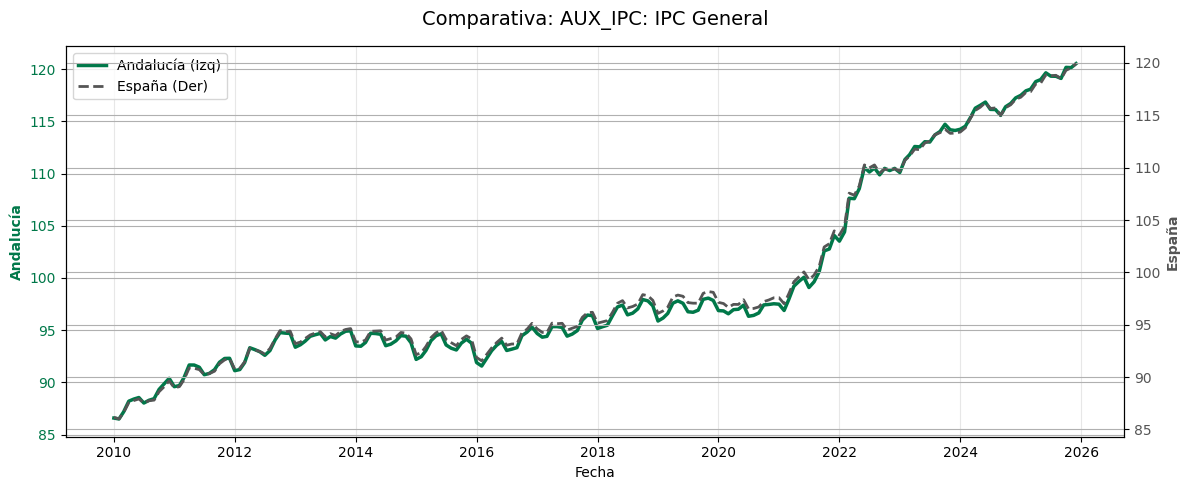

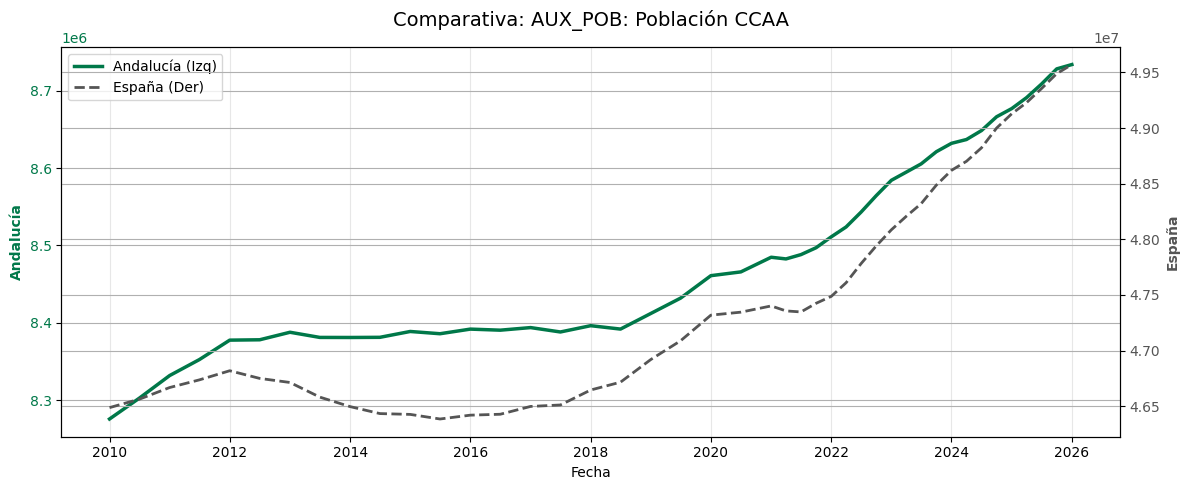

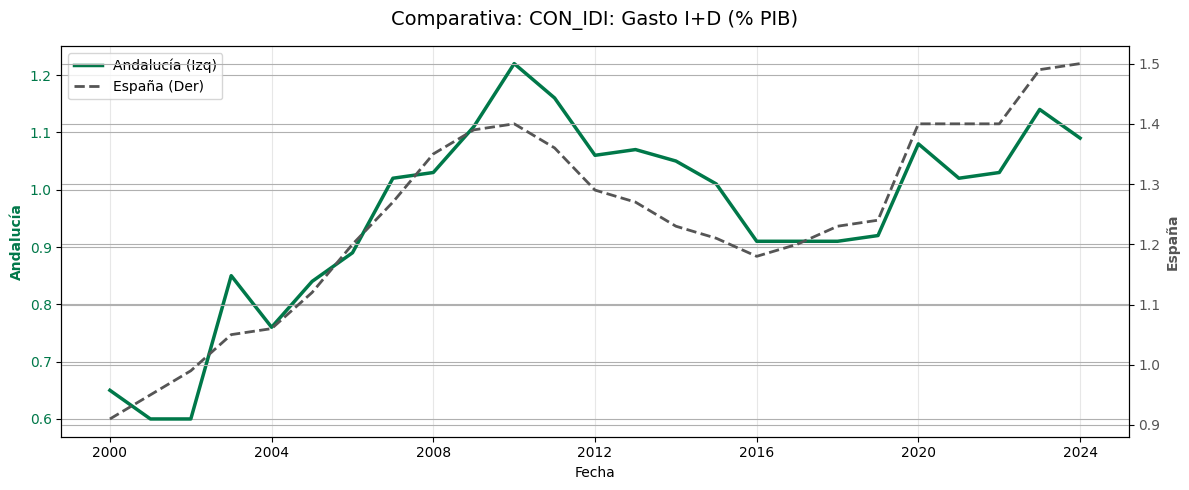

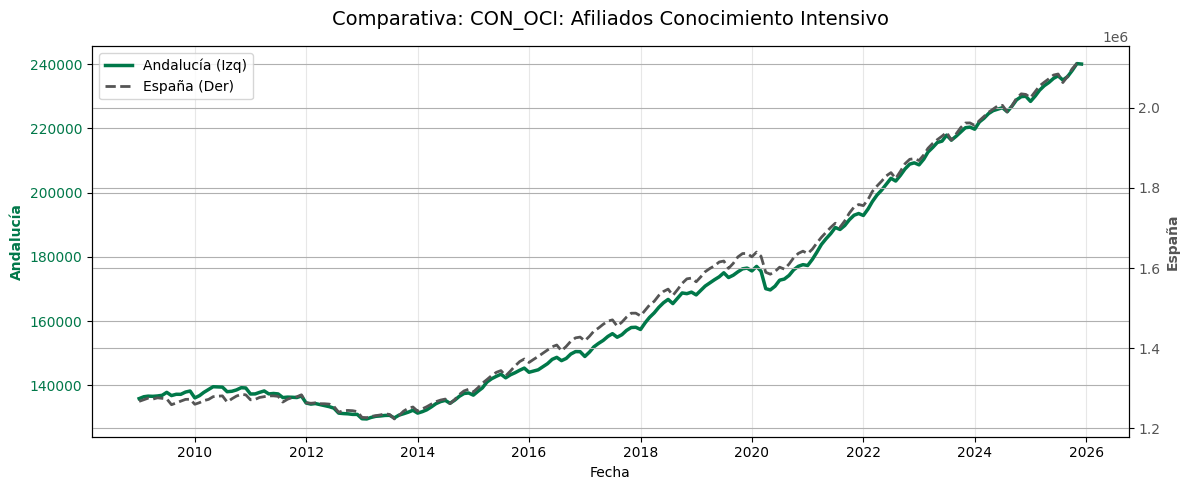

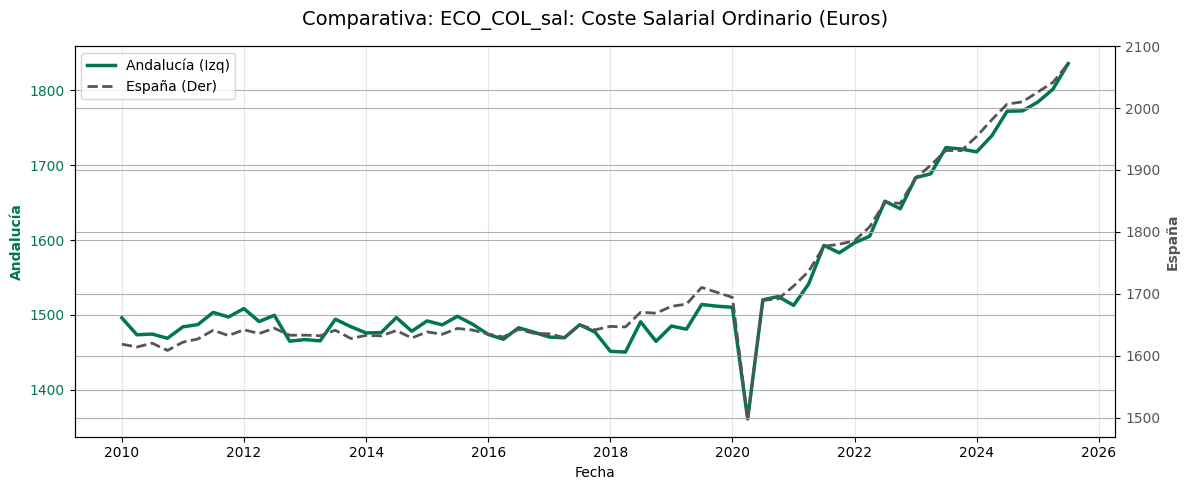

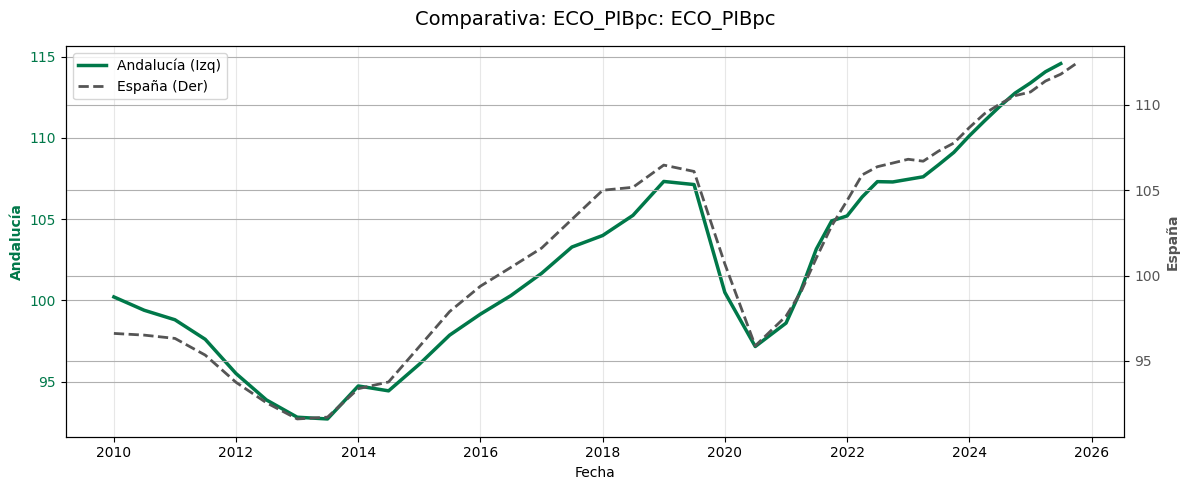

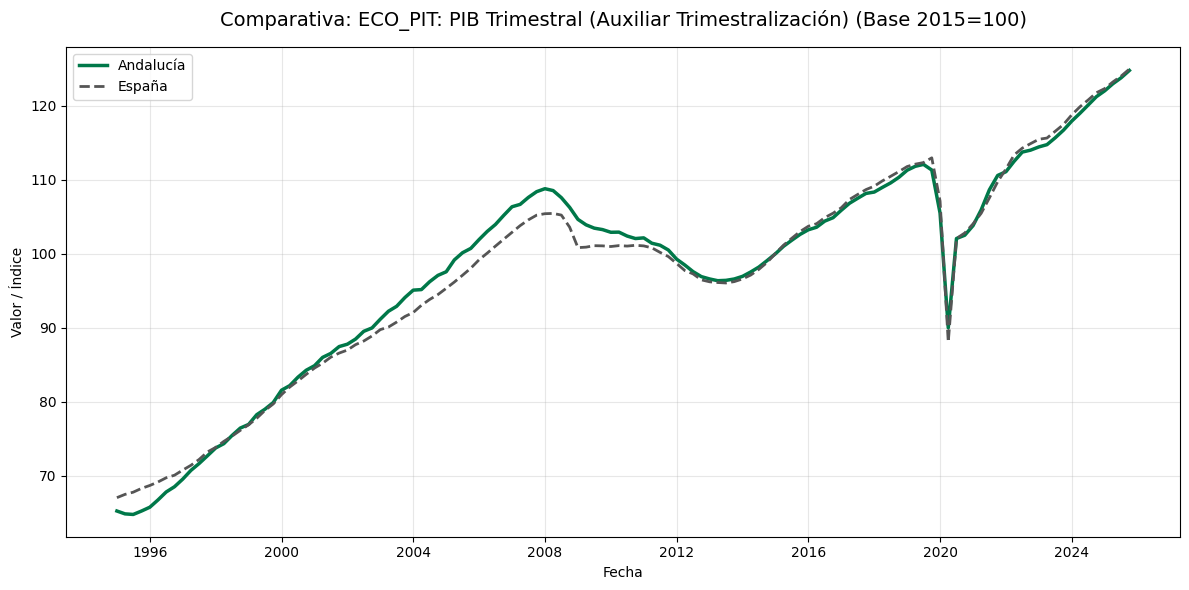

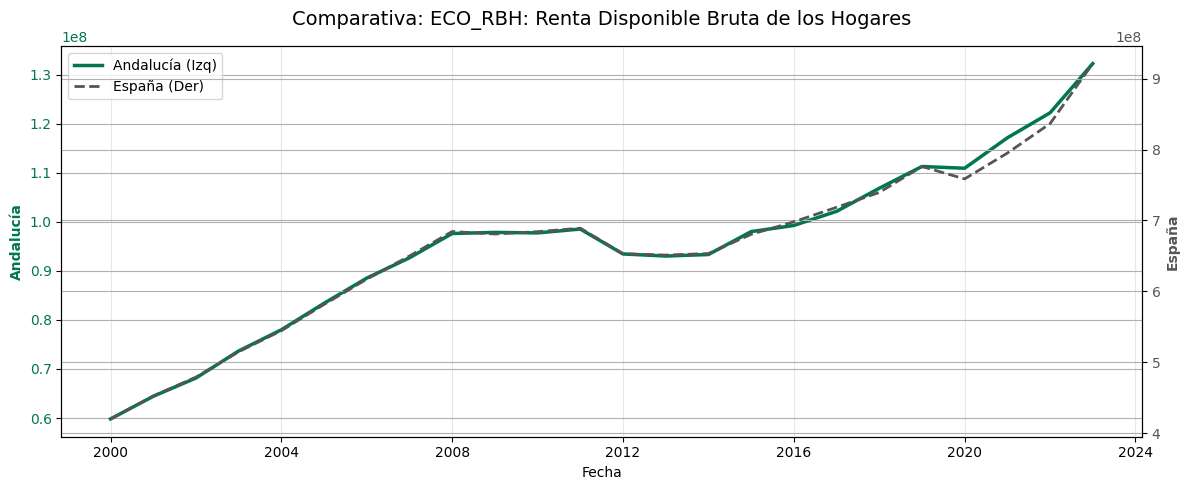

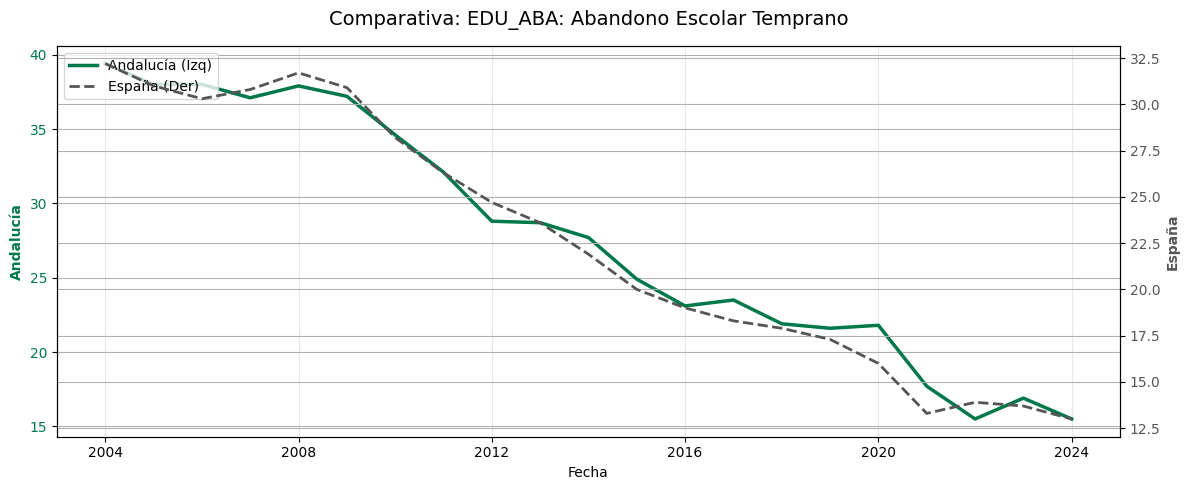

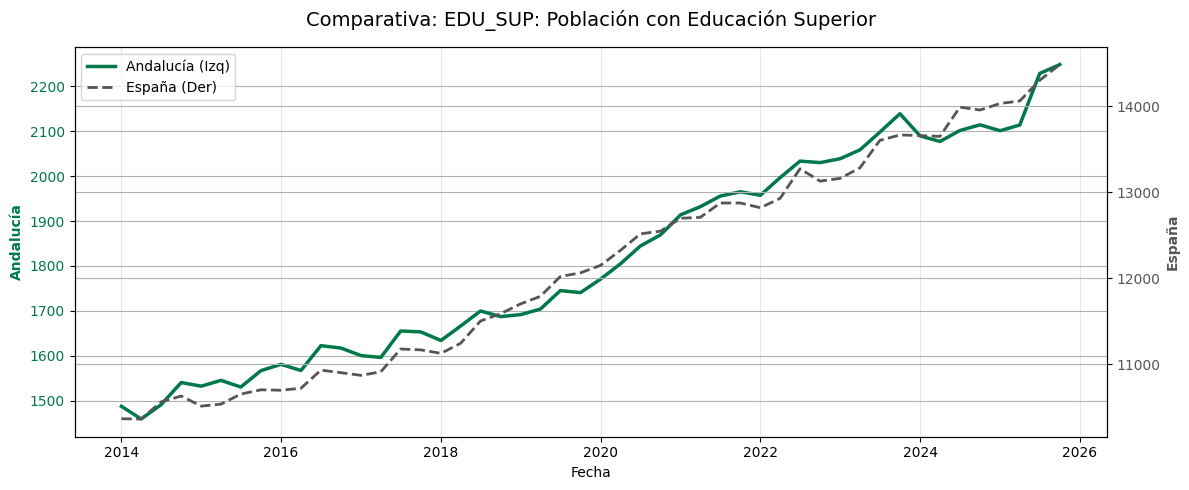

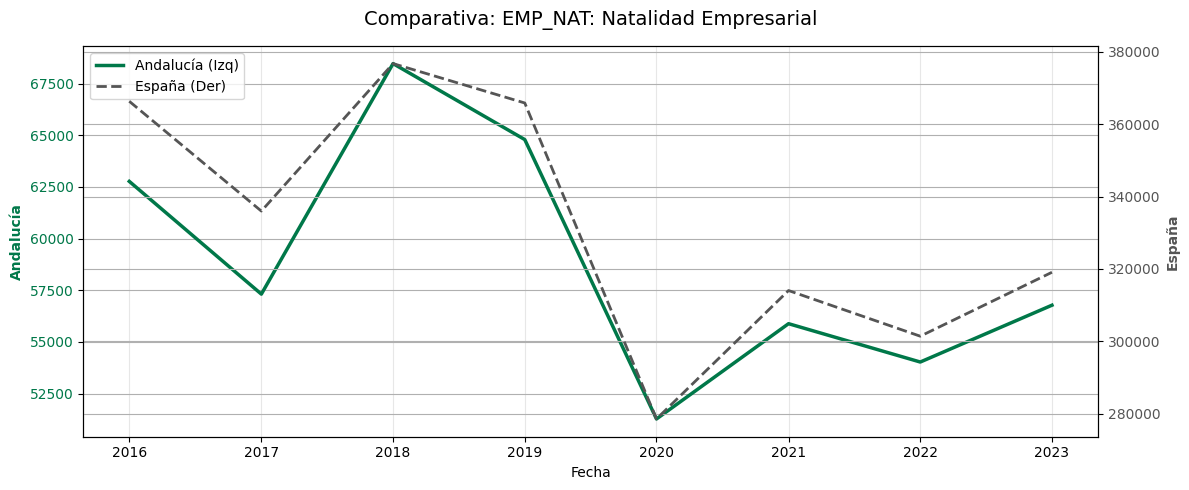

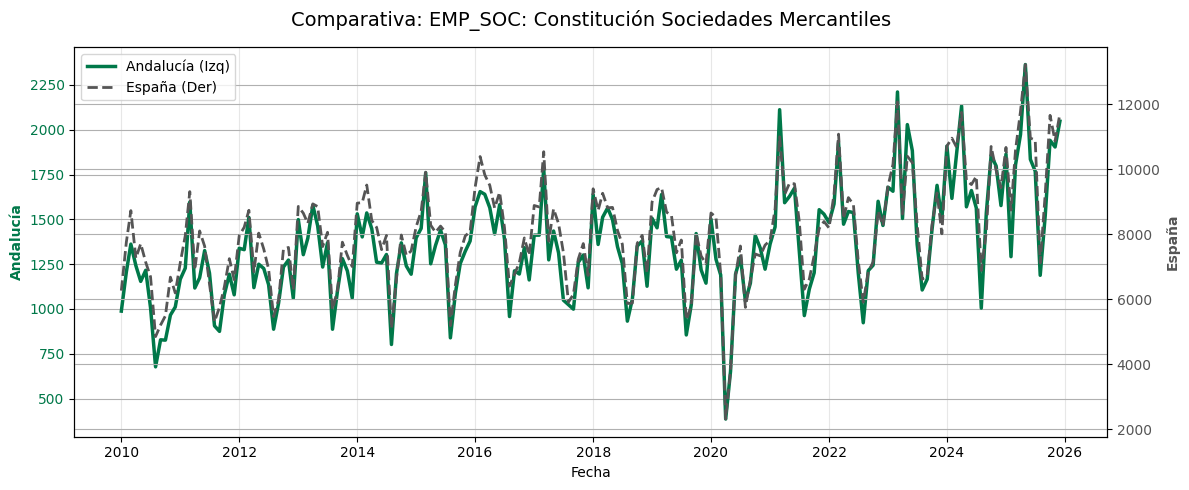

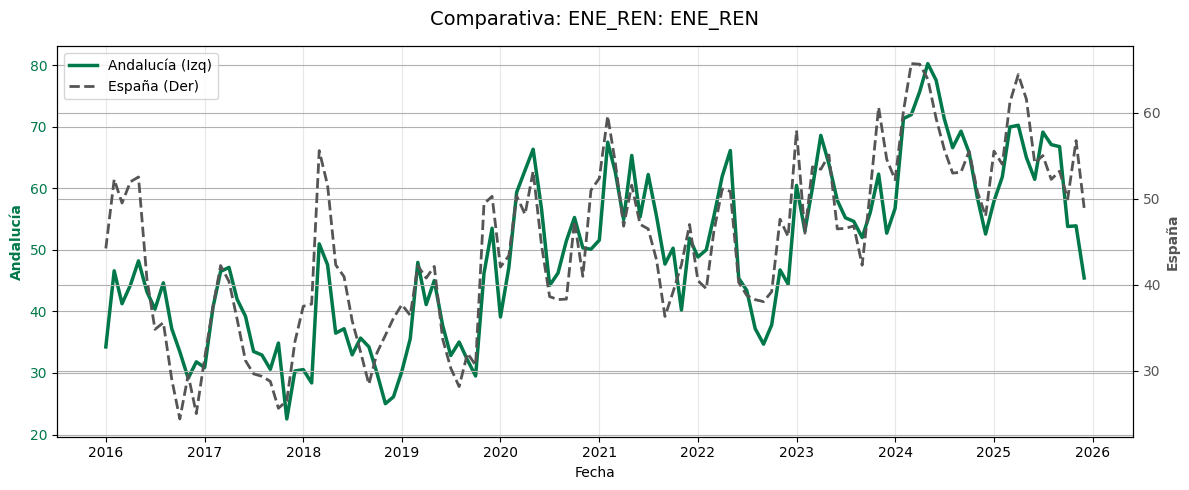

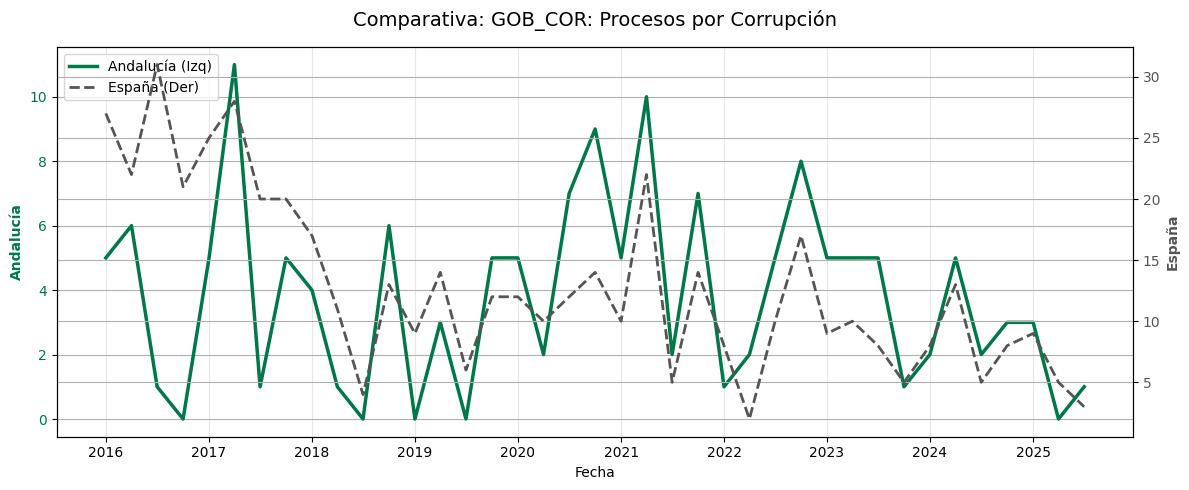

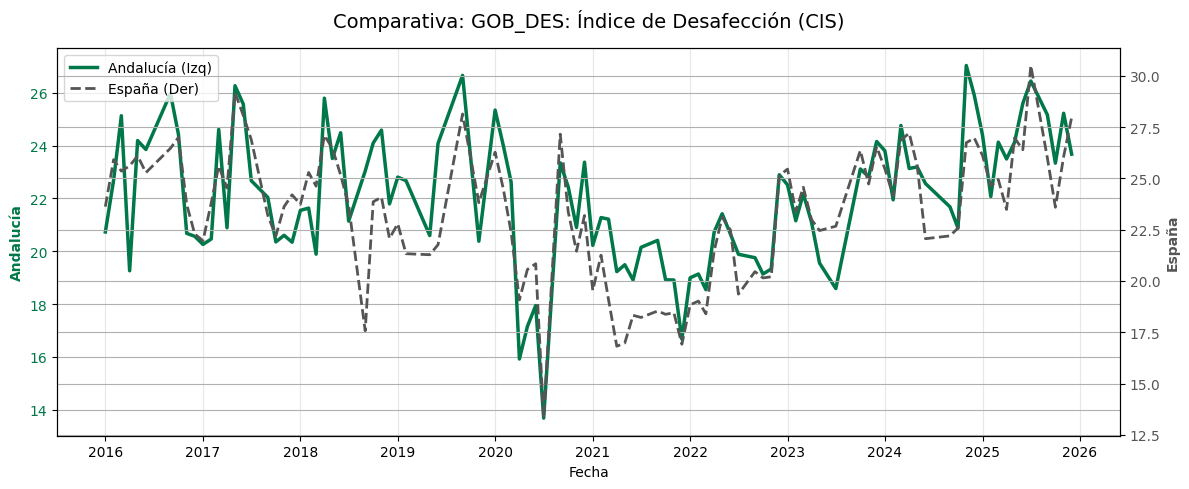

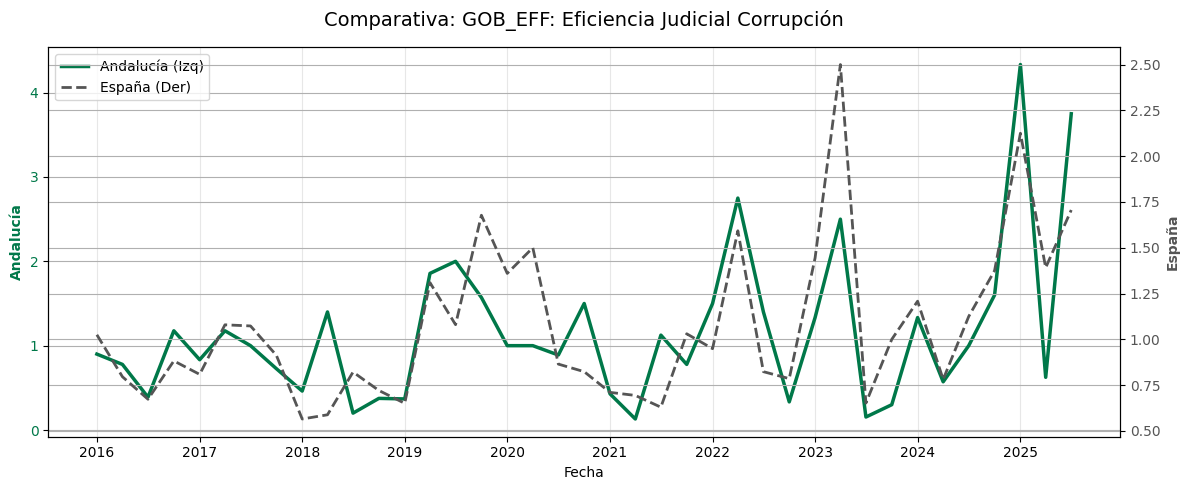

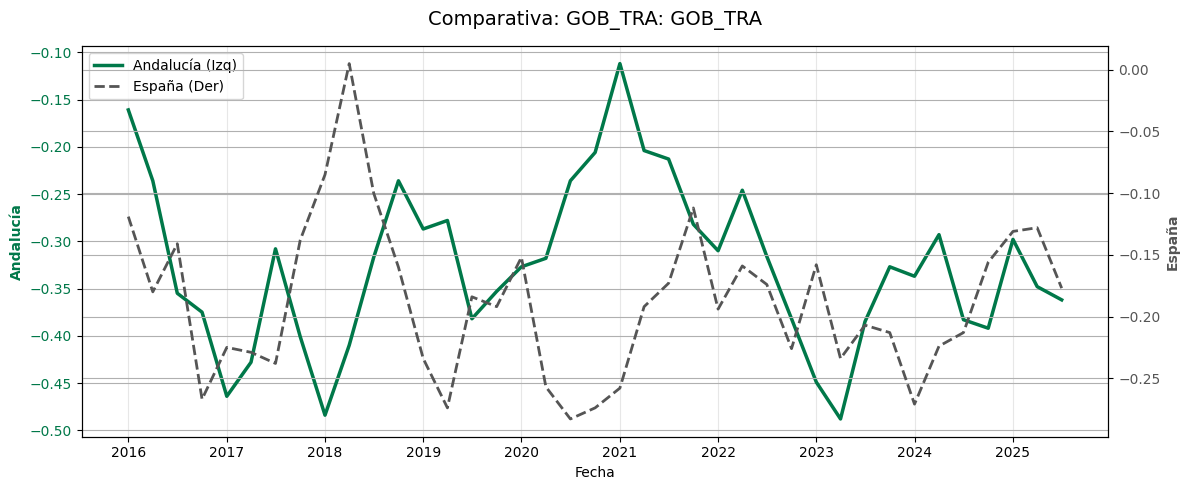

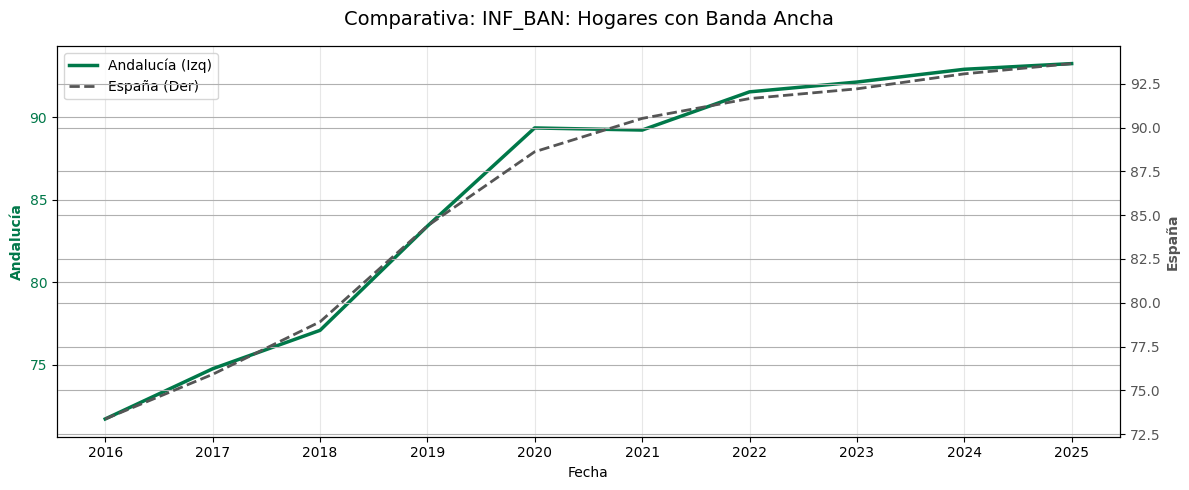

⚠️ Error al pivotar datos para: INF_TRA: Transporte Viajeros Urbano


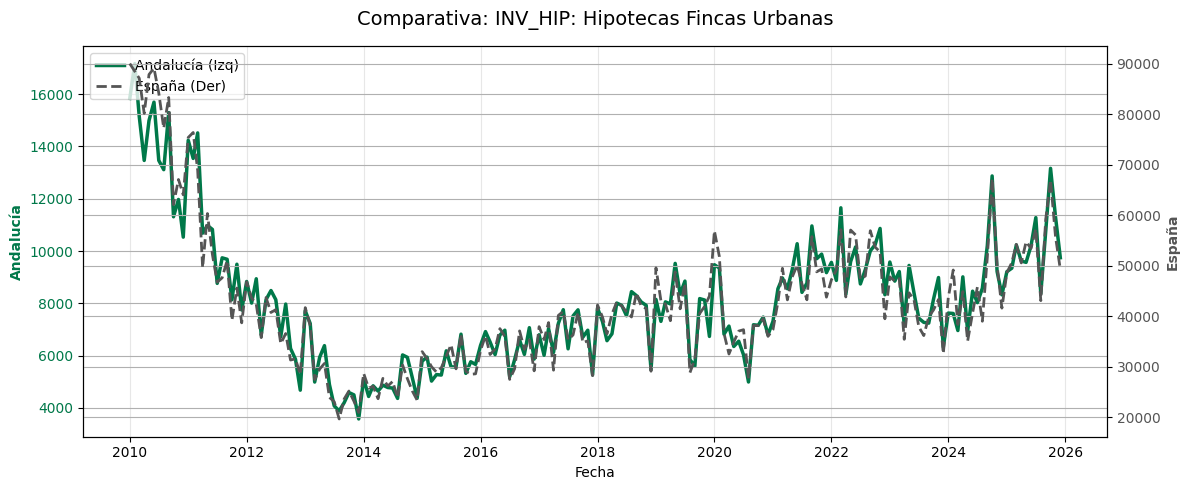

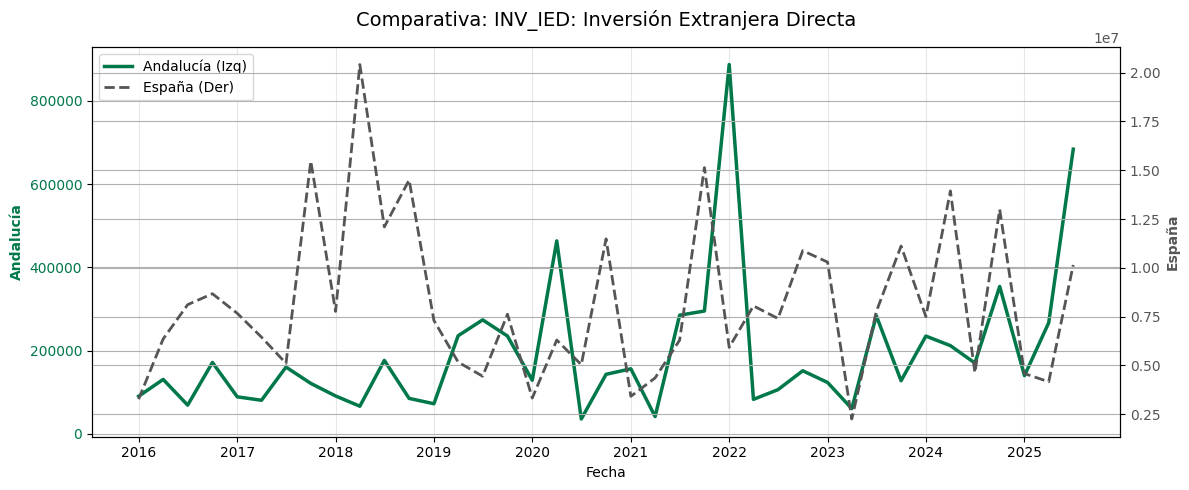

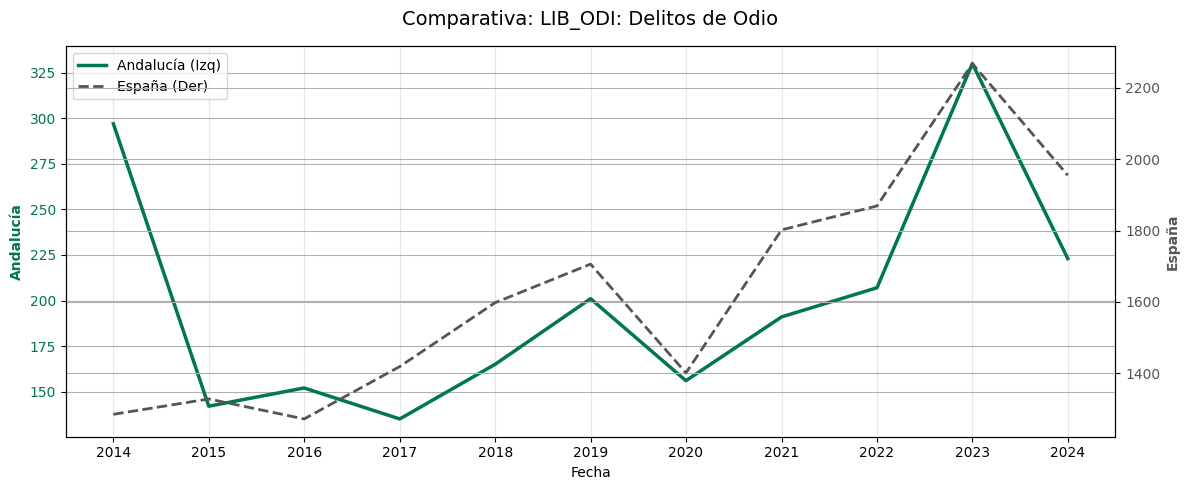

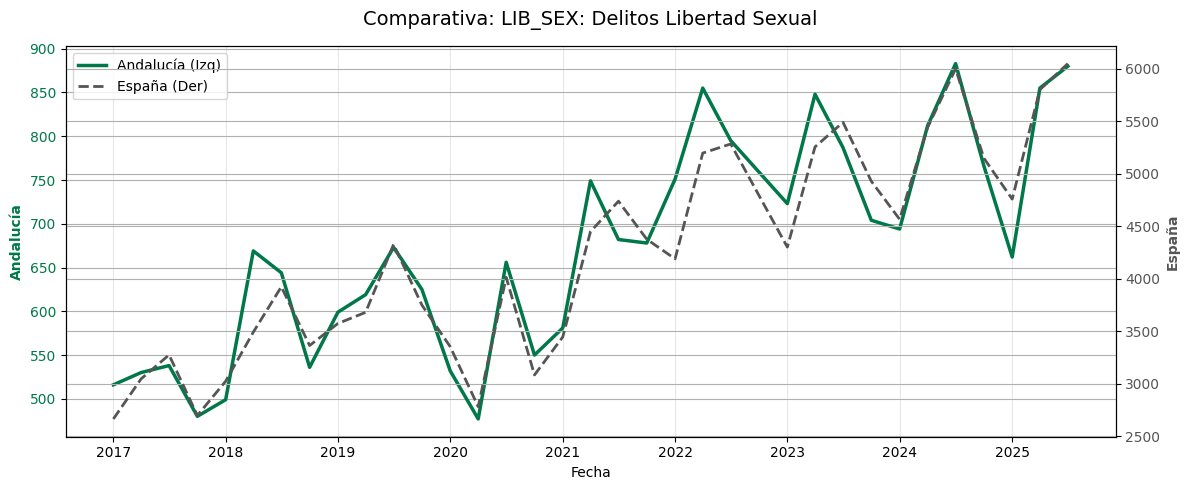

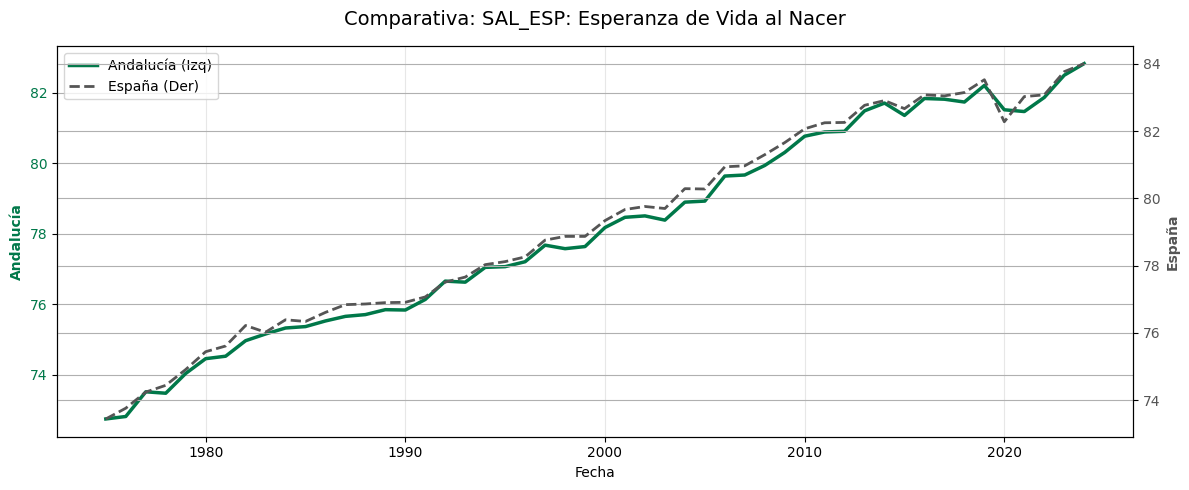

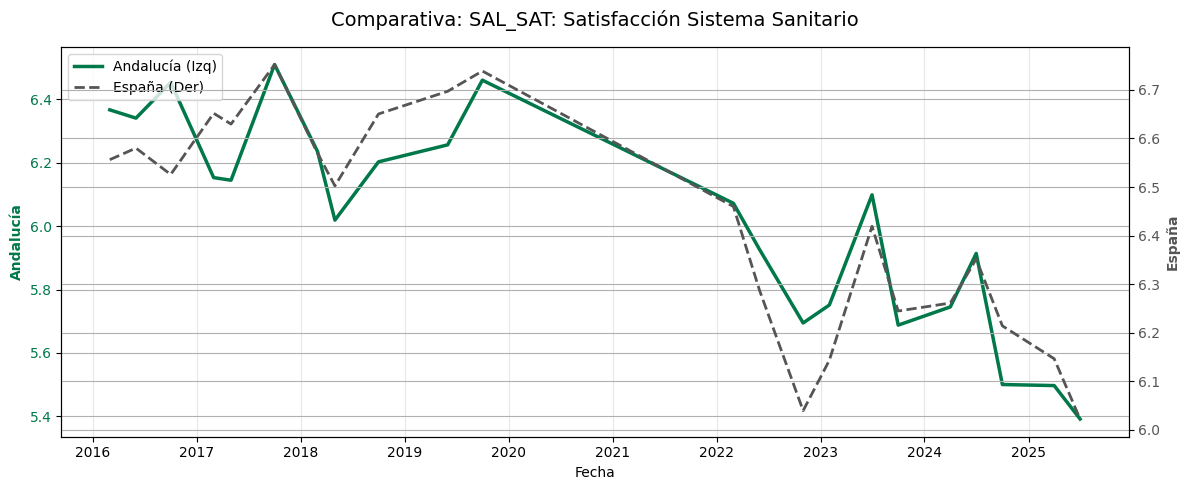

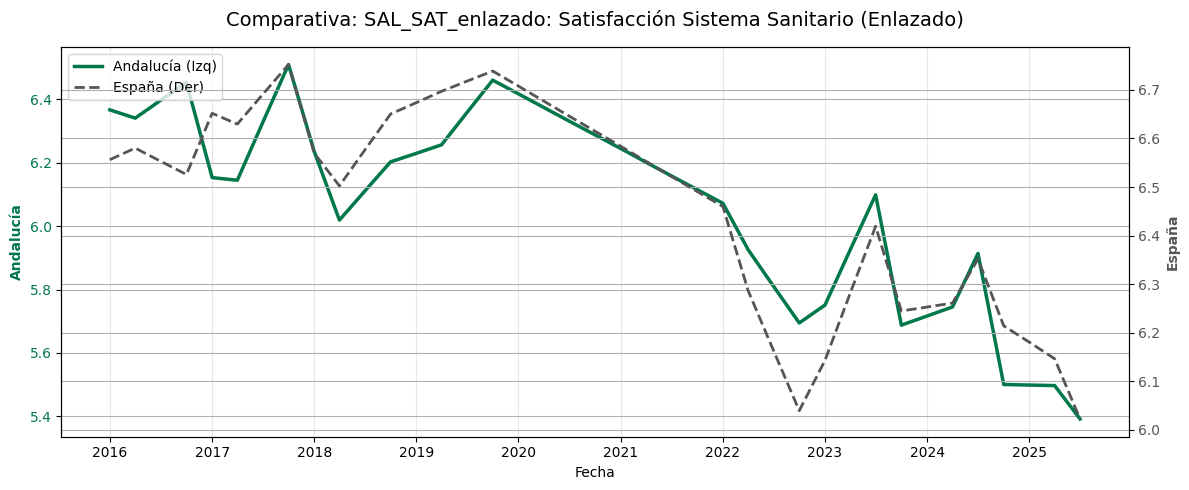

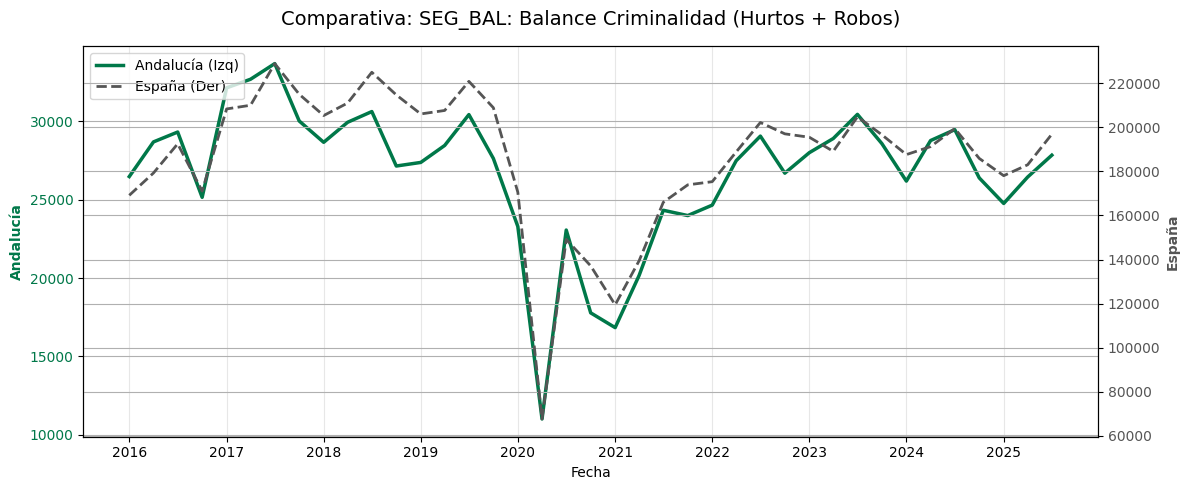

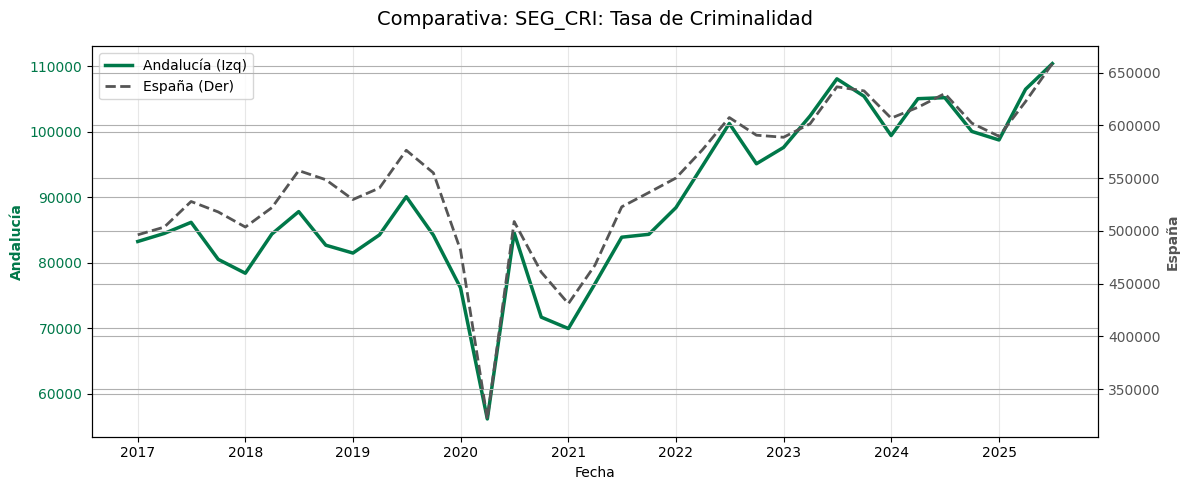

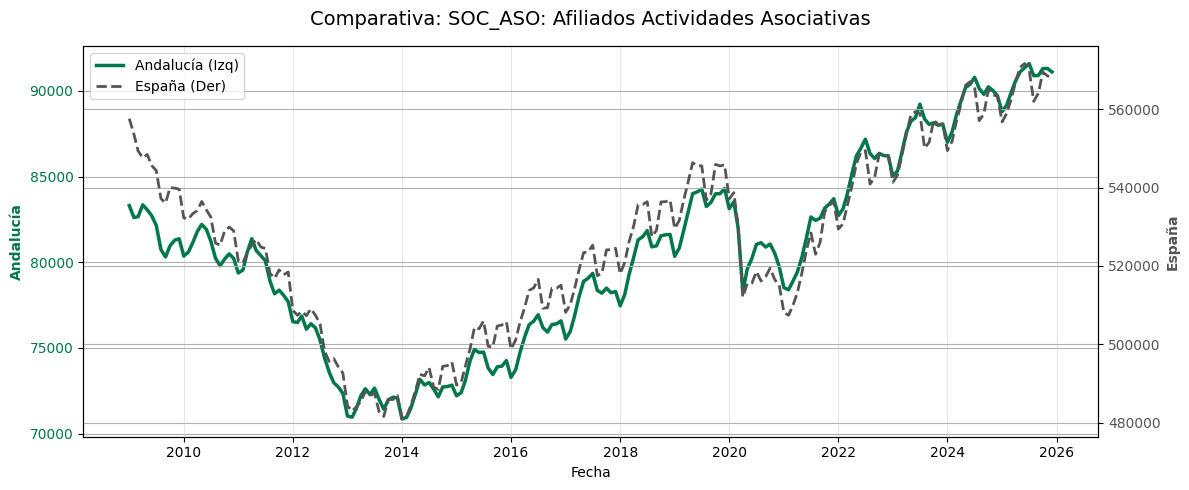

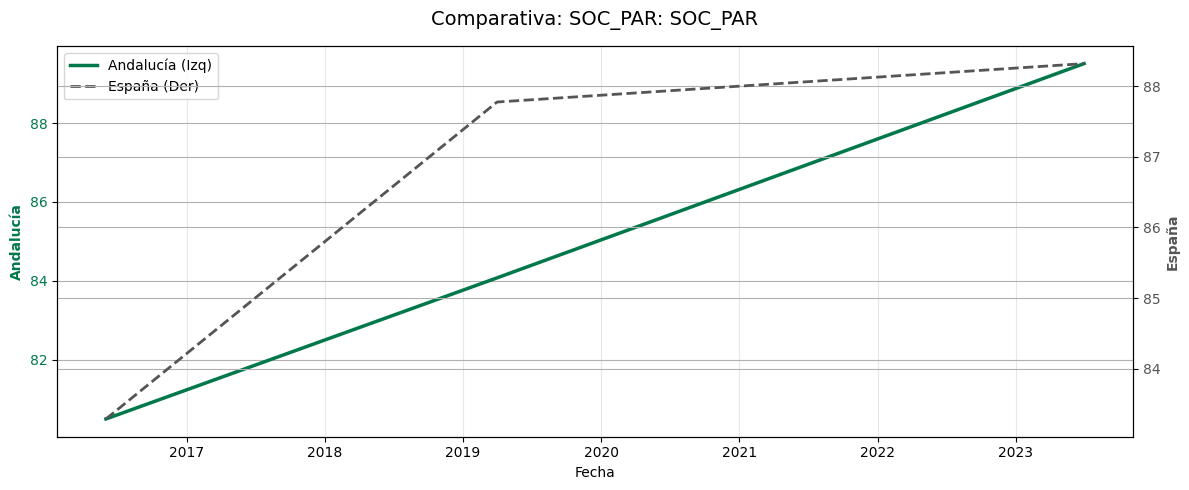

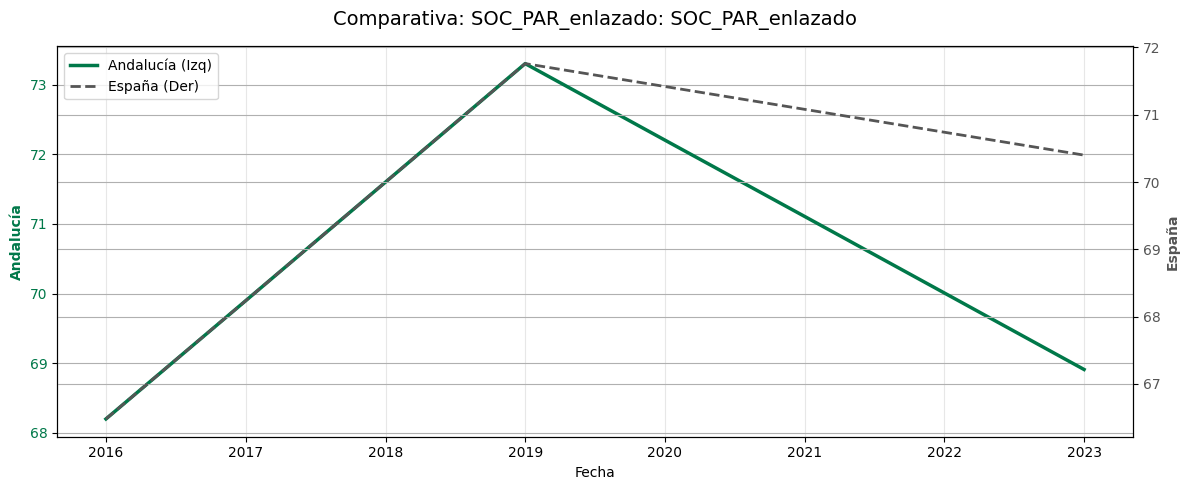

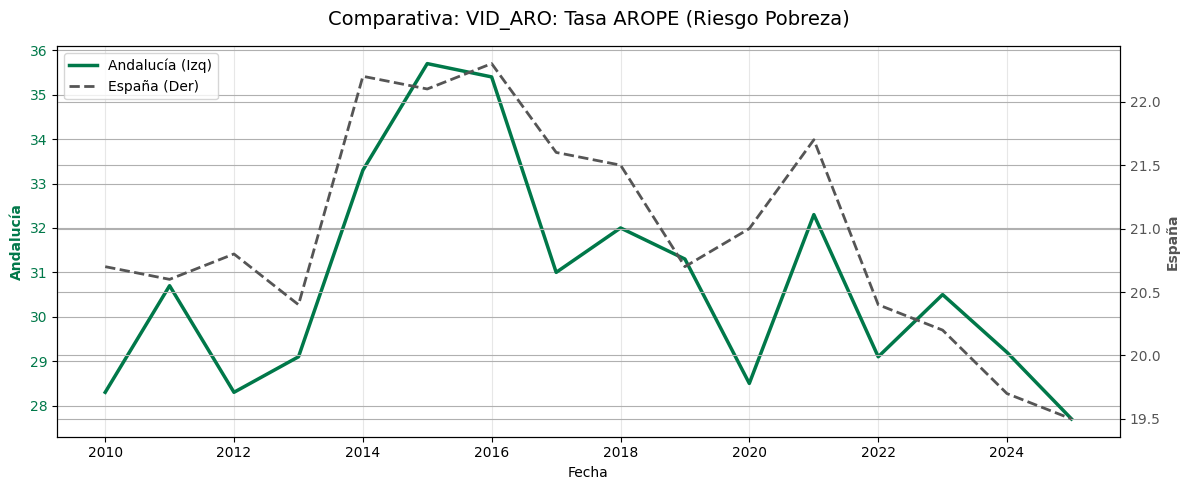

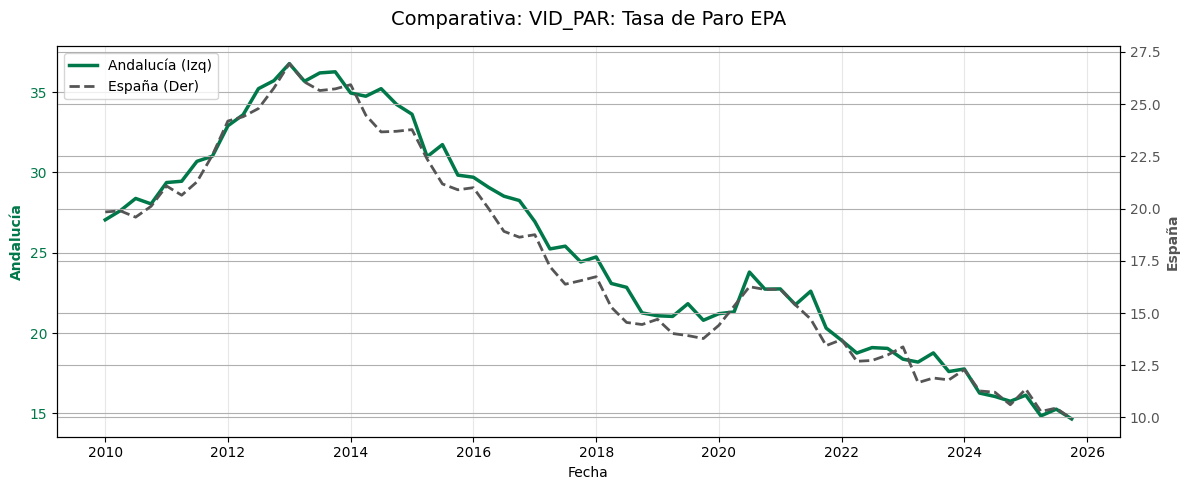


✅ Generados 34 gráficos
   📁 Guardados en: results/figures/indicators/


In [16]:
# 1. Descargar indicadores automáticos
resultados = descargar_todos()

# 2. Procesar indicadores manuales
resultados_manuales = procesar_todos_manuales()

# 3. Correcciones
corregir_lib_sex()

# 4. Nowcasting
ejecutar_nowcasting()

# 5. Validar
validar_todos()

# 6. Exportar
exportar_xlsx()

# 7. Gráficos
graficar_todos()
